In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import animation
from matplotlib.animation import PillowWriter

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

# Extract Data

In [2]:
name = 'K_50k_NOpert'

theta = 0.1
eps = 0.1

One can decide whether to extract time, positions, and velocities from a `.out` file or to import the data from previously-saved numpy arrays.

In [3]:
import_from_saved_nparrays = True
save_arrays = False

# Import the data from previously-saved numpy arrays...
if import_from_saved_nparrays:
    time = np.load('numpy_arrays/'+name+'_time.npy')
    masses = np.load('numpy_arrays/'+name+'_masses.npy')
    x = np.load('numpy_arrays/'+name+'_x.npy')
    y = np.load('numpy_arrays/'+name+'_y.npy')
    z = np.load('numpy_arrays/'+name+'_z.npy')
    vx = np.load('numpy_arrays/'+name+'_vx.npy')
    vy = np.load('numpy_arrays/'+name+'_vy.npy')
    vz = np.load('numpy_arrays/'+name+'_vz.npy')
    N = int(len(x[:,0]))

    print(f'This is the data of {N} particles at {len(time)} time intervals')
    
    
# or extract it from the '.out' file
else:
    # Extract the data by reading one line of the file at a time
    extension = '.out'

    file = open('./project_'+name+extension, 'r')

    N = int(file.readline())
    time = []
    masses = []
    x = []
    y = []
    z = []
    vx = []
    vy = []
    vz = []

    step = 3 + 3*N
    i = 1
    j = 0

    while(True):   
        line = file.readline()

        if line=='':
            file.close()
            break
        
        i += 1

        k = i-j*step
        if (k==3): time.append(float(line))
        elif (j==0 and (k > 3 and k <= 3+N)): 
            masses.append(float(line))
        elif (k > 3+N and k <= 3+2*N): 
            line = [float(x) for x in line.split()]
            x.append(line[0])
            y.append(line[1])
            z.append(line[2])
        elif (k > 3+2*N and k <= 3+3*N):
            line = [float(x) for x in line.split()]
            vx.append(line[0])
            vy.append(line[1])
            vz.append(line[2])

        if i%step==0: j += 1
        
    # Convert the data from lists to numpy arrays 
    time = np.array(time)
    masses = np.array(masses)
    x = np.array(x).reshape(len(time), N).T
    y = np.array(y).reshape(len(time), N).T
    z = np.array(z).reshape(len(time), N).T
    vx = np.array(vx).reshape(len(time), N).T
    vy = np.array(vy).reshape(len(time), N).T
    vz = np.array(vz).reshape(len(time), N).T

    print(f'This is the data of {N} particles at {len(time)} time intervals')
    
    
    # If you want, you can save the data in form of numpy arrays
    if save_arrays:
        np.save('numpy_arrays/'+name+'_time.npy', time)
        np.save('numpy_arrays/'+name+'_masses.npy', masses)
        np.save('numpy_arrays/'+name+'_x.npy', x)
        np.save('numpy_arrays/'+name+'_y.npy', y)
        np.save('numpy_arrays/'+name+'_z.npy', z)
        np.save('numpy_arrays/'+name+'_vx.npy', vx)
        np.save('numpy_arrays/'+name+'_vy.npy', vy)
        np.save('numpy_arrays/'+name+'_vz.npy', vz)
        
M = np.sum(masses)
m_particle = masses[0]
M_mbh = masses[-1]
print(f'M = {M:.4f}')
print(f'M_MBHs = {M_mbh:.4f}')

This is the data of 50000 particles at 3001 time intervals
M = 10000.0000
M_MBHs = 0.2000


# Convert the data from internal units to physical units

In [4]:
G_pu = 6.67430e-8             # cm^3 g^-1 s^-2
r_pu = 3.08567758128e18*1e3   # kpc in cm
m_pu = 1.989e33*1e7           # 10^7 M_sun in g

v_pu = np.sqrt(G_pu * m_pu / r_pu) #cm/s

time_pu = r_pu/v_pu #seconds

E_pu = G_pu*(m_pu**2)/r_pu #cm^2 g s^-2 = erg

In [5]:
v_pu = v_pu/1e5 #km/s
print(f"v_pu/v_iu = {v_pu:.2f} (km/s)/iu")

time_pu = time_pu/(3.156e7*1e6) #megayears
print(f"time_pu/time_iu = {time_pu:.3f} Myr/iu")

print(f"E_pu/E_iu = {E_pu:.2e} erg/iu")

v_pu/v_iu = 6.56 (km/s)/iu
time_pu/time_iu = 149.063 Myr/iu
E_pu/E_iu = 8.56e+51 erg/iu


In [6]:
# Time in mega years
time = time * time_pu 

In [7]:
# Masses in solar masses
masses = masses*1e7
M = M*1e7
m_particle = m_particle*1e7
M_mbh = M_mbh*1e7

In [8]:
# Distances in parsecs
x = x*1e3
y = y*1e3
z = z*1e3

In [9]:
# Velocities in km/s
vx = vx * v_pu
vy = vy * v_pu
vz = vz * v_pu

In [10]:
# cm^3 g^-1 s^-2  -->  pc km^2 M_sun^-1 s^-2
G_pu = G_pu / 3.08567758128e18 / (1e5)**2 * 1.989e33
print(f'The Schwarzschild radius of the sun is: {(3.08567758128e18 / 1e5)*2*G_pu*1/(3e5)**2:.2f} km.')

The Schwarzschild radius of the sun is: 2.95 km.


# Motion of the CM

Compute the distance of each particle from the origin at each time

In [11]:
def Dist(x1, y1, z1, x2, y2, z2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    #The following looks more elegant, but it is less memory-efficient, especially for large arrays
    #return np.linalg.norm(np.array([x1-x2, y1-y2, z1-z2]), axis=0)

dist_particle = Dist(x, y, z, 0, 0, 0)
print(dist_particle.shape)

(50000, 3001)


Compute the position and the velocity of the center of mass as a function of time

$$\vec{r}_\text{CM}(t) = \dfrac{\sum_{i=1}^{N} m_i \vec{r}_i(t)}{\sum_{i=1}^{N} m_i} \:\:\: , \:\:\: \vec{r'}_i(t) = \vec{r}_i(t) - \vec{r}_\text{CM} (t)$$

$$\vec{v}_\text{CM} (t) = \dfrac{\sum_{i=1}^{N} m_i \vec{v}_i(t)}{\sum_{i=1}^{N} m_i} \:\:\: , \:\:\: \vec{v'}_i(t) = \vec{v}_i(t) - \vec{v}_\text{CM} (t)$$

In [12]:
CMpos_vector = np.array([np.dot(masses, x), np.dot(masses, y), np.dot(masses, z)])/M
CMpos = np.linalg.norm(CMpos_vector, axis=0)

CMvel_vector = np.array([np.dot(masses, vx), np.dot(masses, vy), np.dot(masses, vz)])/M
CMvel = np.linalg.norm(CMvel_vector, axis=0)

Compute the position and velocity of the center of mass, neglecting the 10% furthest particles

In [13]:
CMpos_q90_vector = np.zeros((3, len(time)))
CMvel_q90_vector = np.zeros((3, len(time)))

for i in tqdm(range(len(time))):
    mask = dist_particle[:,i]<np.quantile(dist_particle[:,i], 0.9)
    CMpos_q90_vector[:,i] = np.array([np.dot(masses[mask], x[:,i][mask]), 
                                      np.dot(masses[mask], y[:,i][mask]), 
                                      np.dot(masses[mask], z[:,i][mask])])/np.sum(masses[mask])
    
    CMvel_q90_vector[:,i] = np.array([np.dot(masses[mask], vx[:,i][mask]), 
                                      np.dot(masses[mask], vy[:,i][mask]), 
                                      np.dot(masses[mask], vz[:,i][mask])])/np.sum(masses[mask])
    
CMpos_q90 = np.linalg.norm(CMpos_q90_vector, axis=0)
CMvel_q90 = np.linalg.norm(CMvel_q90_vector, axis=0)

100%|██████████| 3001/3001 [00:05<00:00, 565.35it/s]


Plot the position of the center of mass as a function of time

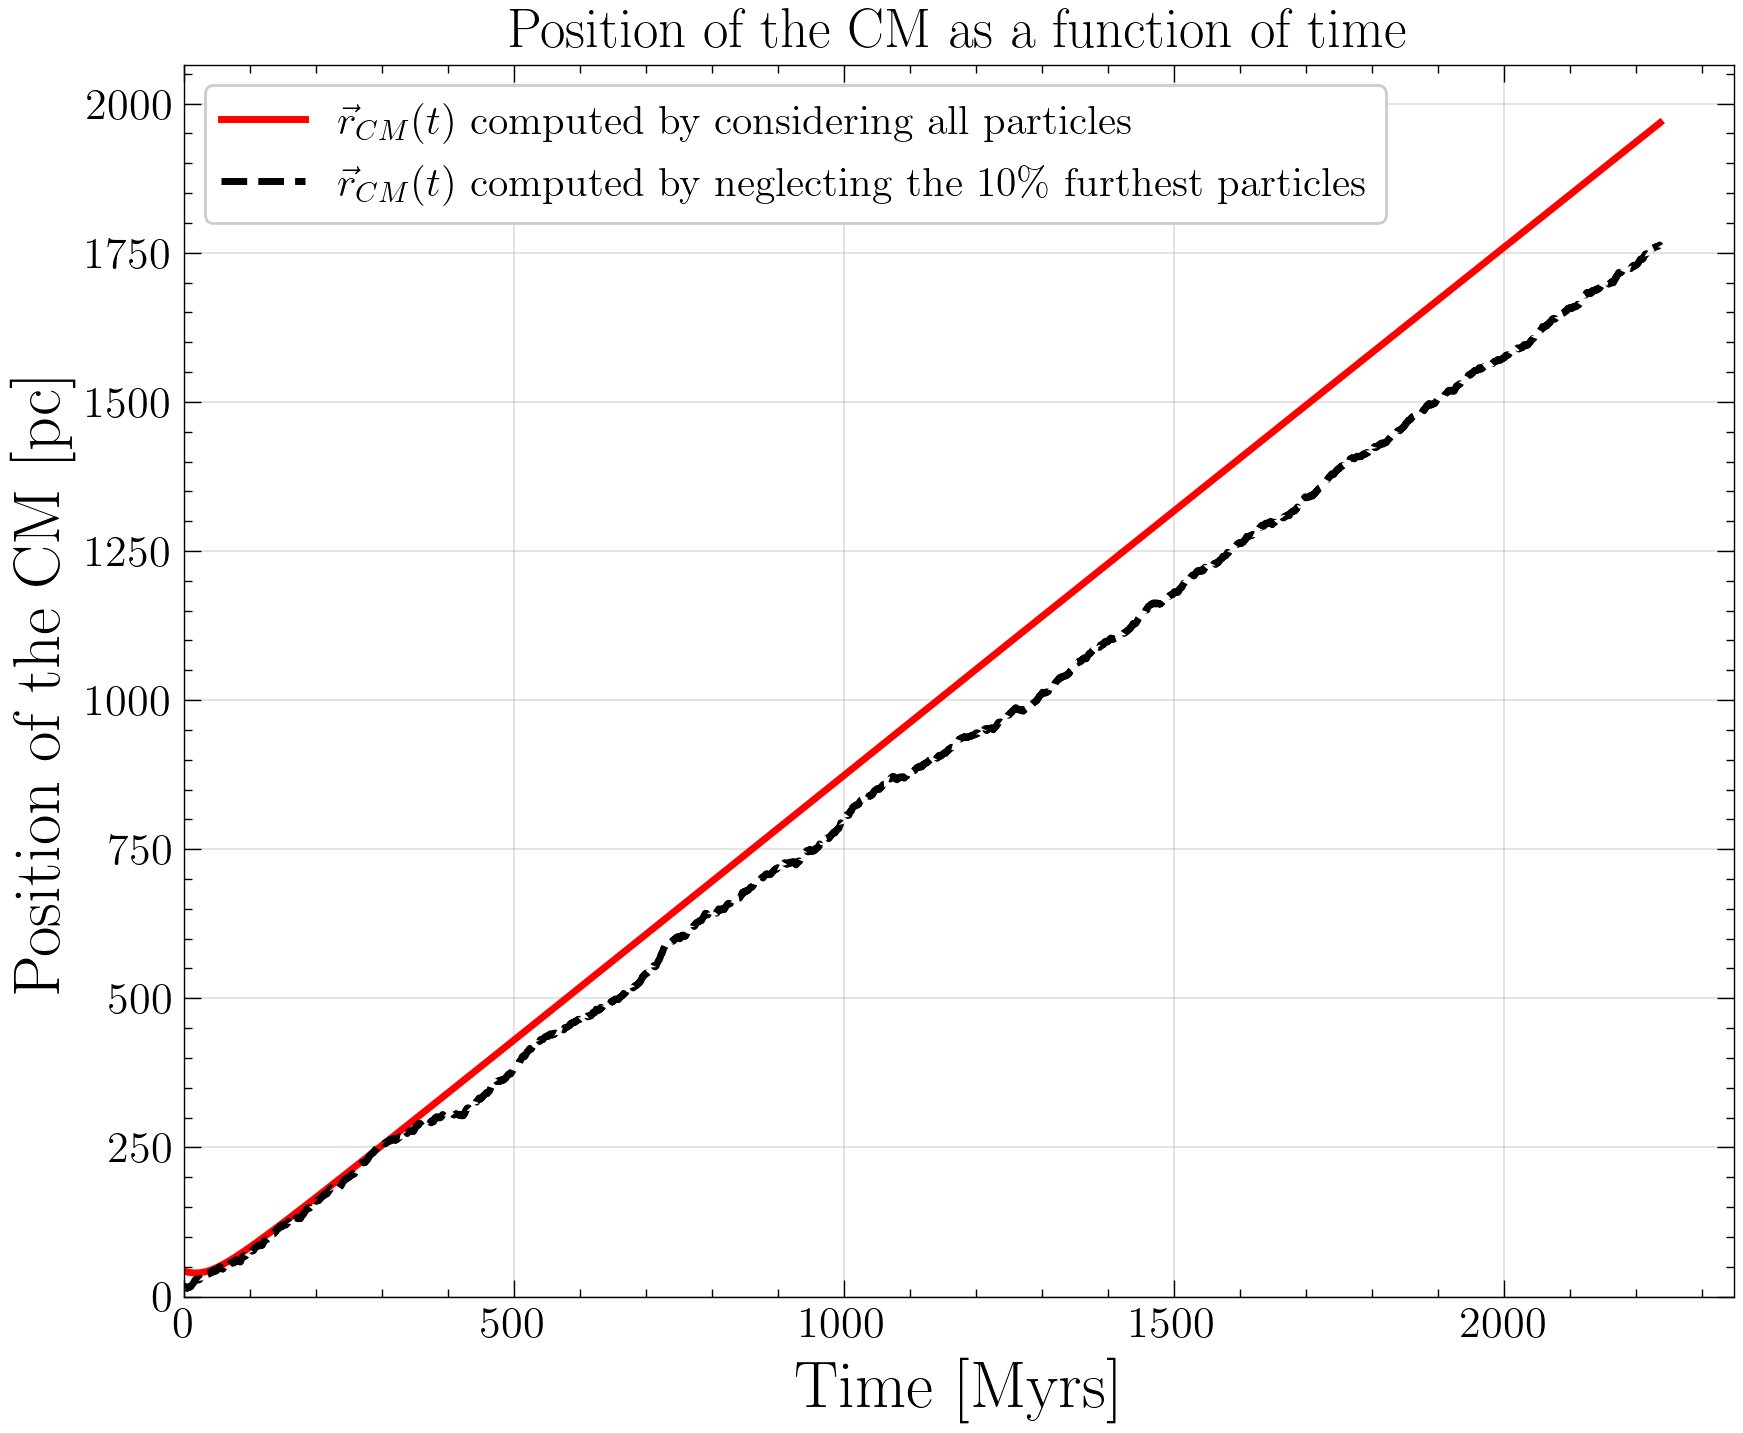

In [14]:
plt.plot(time, CMpos, color='red', lw=2.5, label='$\\vec{r}_{CM}(t)$ computed by considering all particles')
plt.plot(time, CMpos_q90, color='black', ls='--', lw=2.5, label='$\\vec{r}_{CM}(t)$ computed by neglecting the 10\% furthest particles')
plt.xlim(0)
plt.ylim(0)
plt.title('Position of the CM as a function of time', fontsize=20)
plt.xlabel('Time [Myrs]')
plt.ylabel('Position of the CM [pc]')
plt.legend(fontsize = 15);

Plot the velocity of the center of mass as a function of time

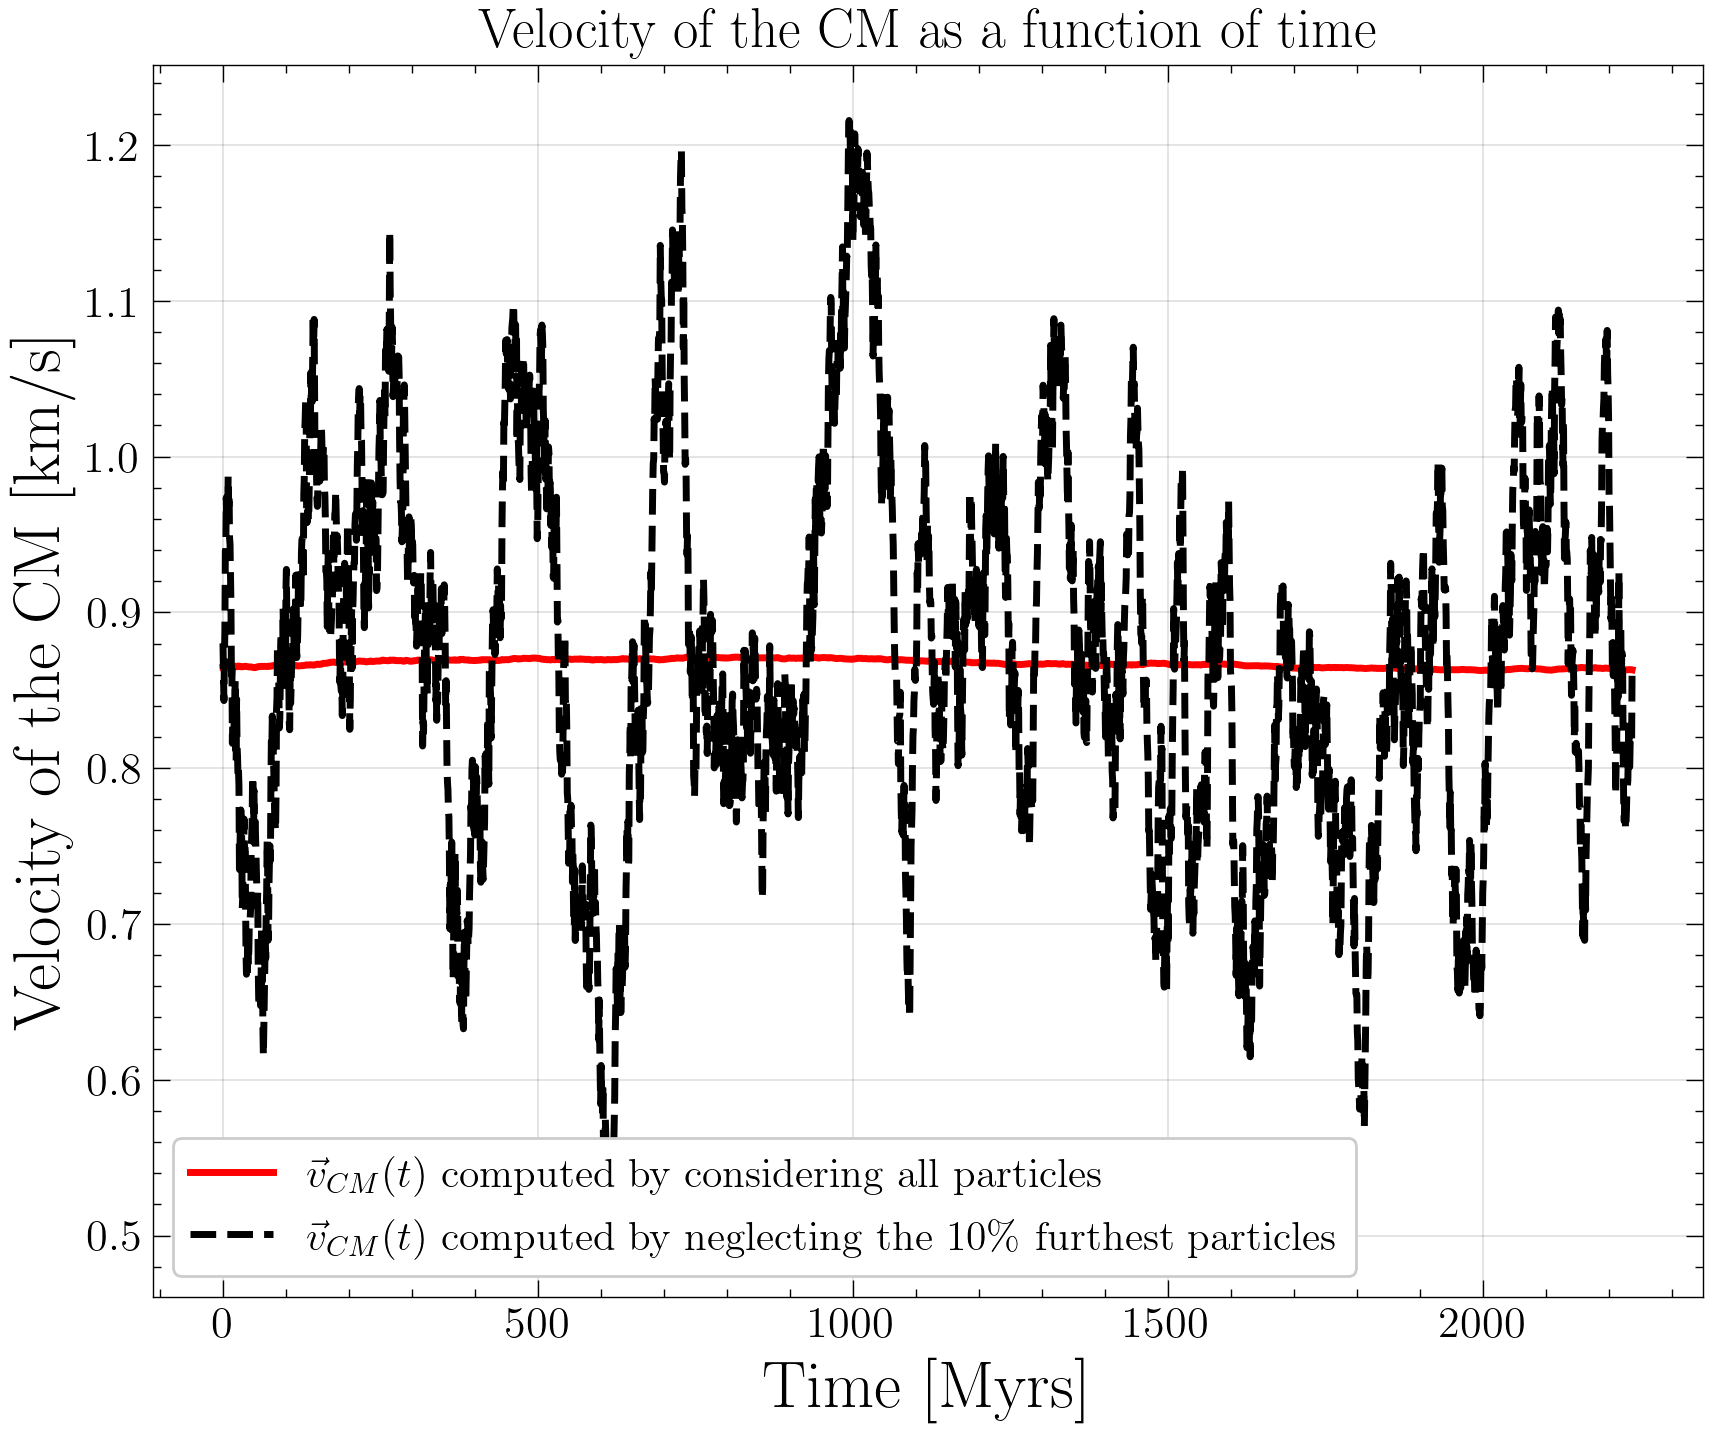

In [15]:
plt.plot(time, CMvel, color='red', lw=2.5, label='$\\vec{v}_{CM}(t)$ computed by considering all particles')
plt.plot(time, CMvel_q90, color='black', ls='--', lw=2.5, label='$\\vec{v}_{CM}(t)$ computed by neglecting the 10\% furthest particles')
plt.title('Velocity of the CM as a function of time', fontsize=20)
plt.xlabel('Time [Myrs]')
plt.ylabel('Velocity of the CM [km/s]')
plt.legend(fontsize = 15);

Redefine positions and velocities in the CM frame, considering the CM position and velocity computed by neglecting the 10% furthest particles (more robust)

In [16]:
# Re-assign the CM variables
CMpos_vector = CMpos_q90_vector
CMpos = CMpos_q90
CMvel_vector = CMvel_q90_vector
CMvel = CMvel_q90

# Delete unnecessary variables to save memory
del CMpos_q90_vector
del CMpos_q90
del CMvel_q90_vector
del CMvel_q90
del mask

In [17]:
# Redefine the position and velocity vectors of the particles in the CM frame
x = x - CMpos_vector[0]
y = y - CMpos_vector[1]
z = z - CMpos_vector[2]
vx = vx - CMvel_vector[0]
vy = vy - CMvel_vector[1]
vz = vz - CMvel_vector[2]

In [18]:
# Recompute the distance of the particles from the CM
dist_particle = None
dist_particle = Dist(x, y, z, 0, 0, 0)

We constrain our plots to boxes of length `dist_plotlimits` in each direction, which is defined as the maximum in time of the 90%-quantiles of the distances between the particles and the CM

In [19]:
dist_plotlimits = np.max(np.quantile(dist_particle, 0.9, axis=0))
dist_plotlimits

8949.039770724043

# Distance quantiles

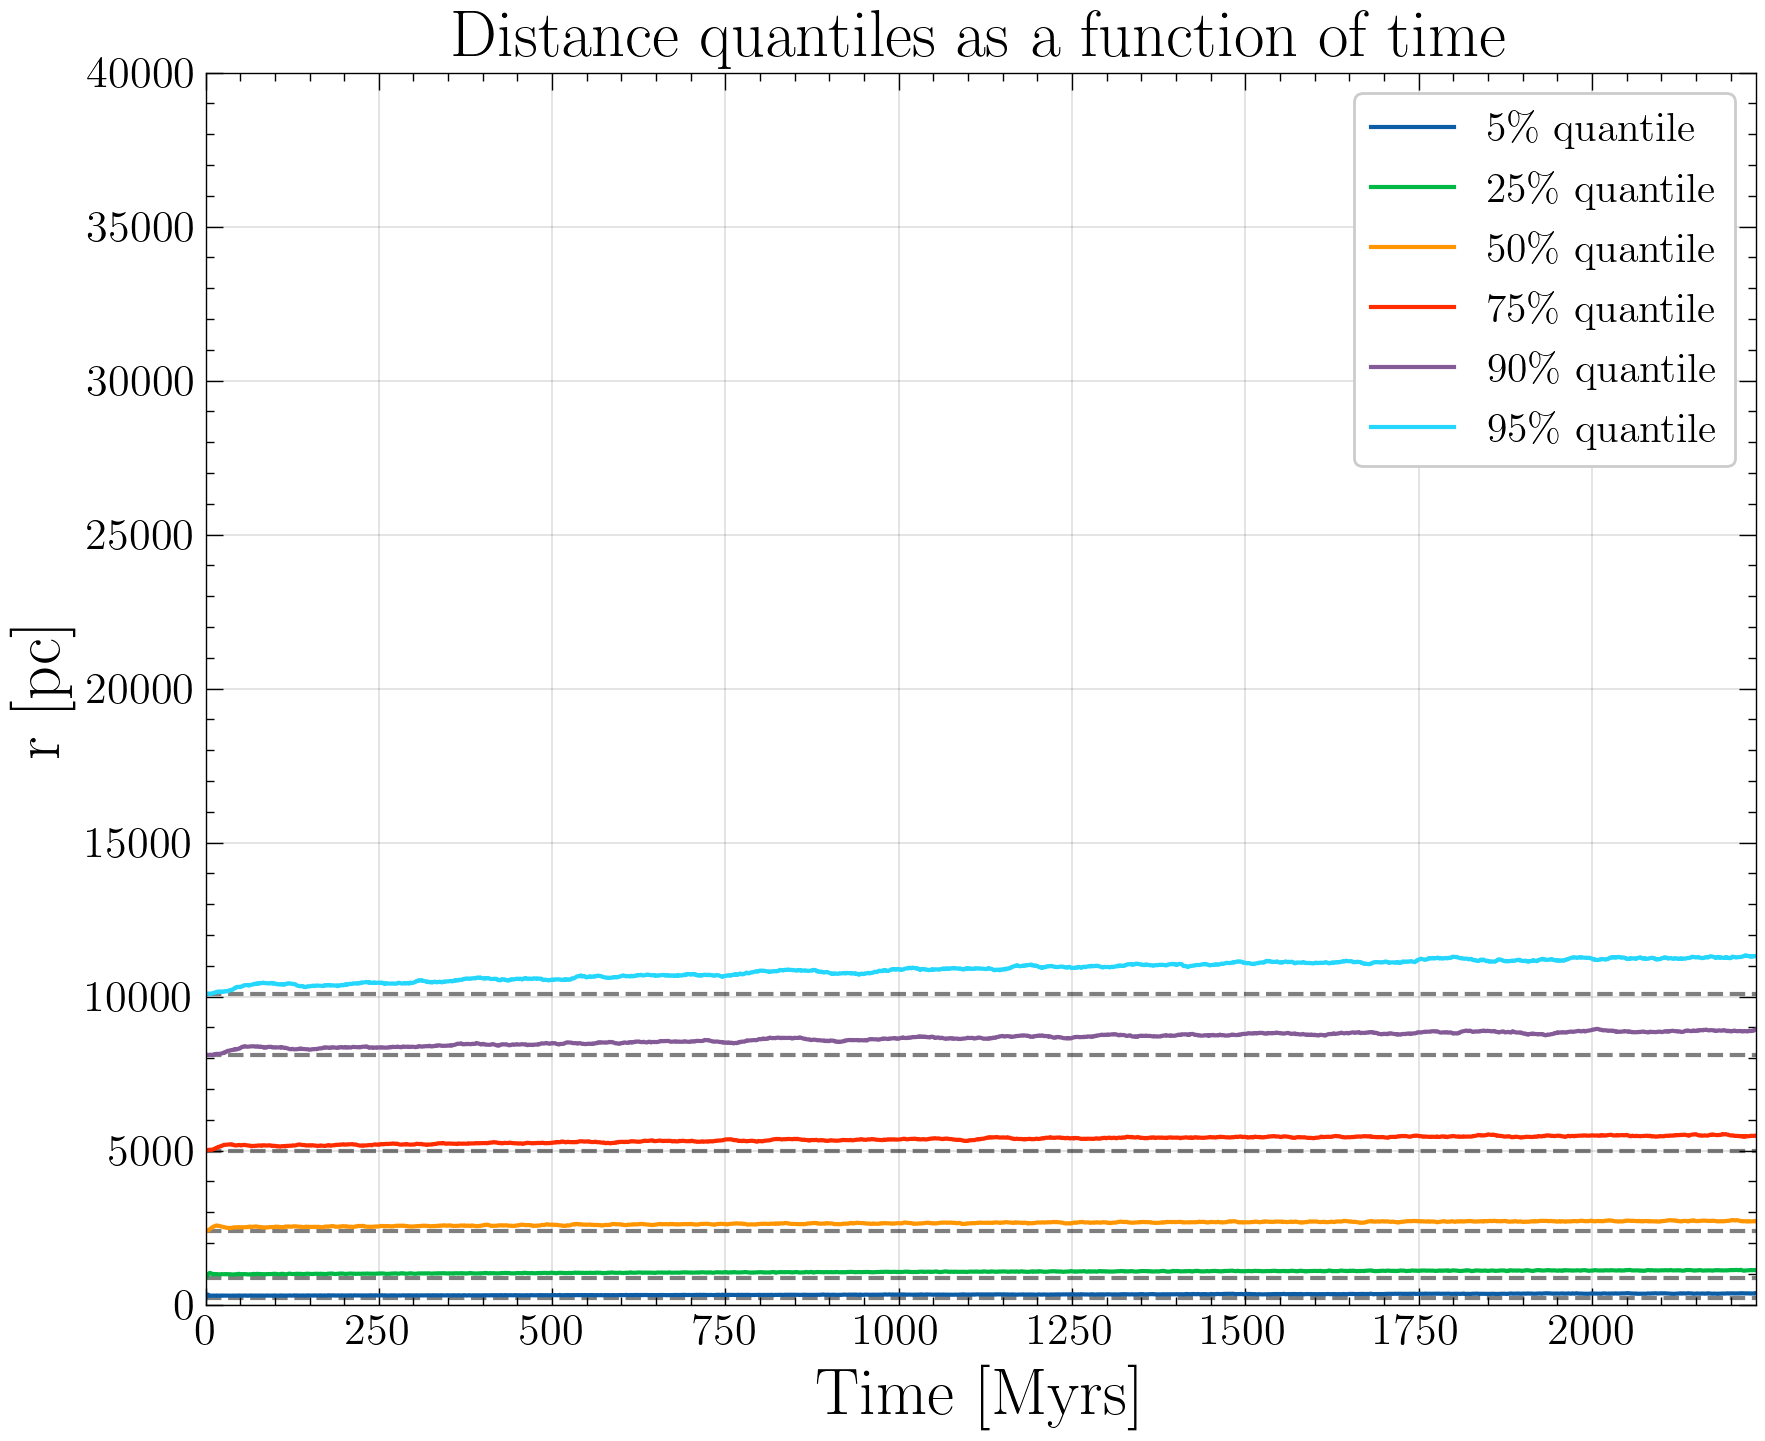

In [63]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.9, 0.95]
dist_quantiles = np.quantile(dist_particle, quantiles, axis=0)
for i in range(len(quantiles)):
    plt.axhline(dist_quantiles[i][0], ls='--', color='black', alpha=0.5)
    plt.plot(time, dist_quantiles[i], label=f'{int(100*quantiles[i])}\% quantile')
plt.xlim(0, time[-1])
plt.ylim(0, 40000)#1.3*np.max(dist_quantiles[:,0]))
plt.title('Distance quantiles as a function of time')
plt.xlabel('Time [Myrs]')
plt.ylabel('r [pc]')
plt.legend(loc='upper right', fontsize=15);

del dist_quantiles

# Orbits of the MBHs

Compute the distance, the velocity, and the angular momentum of the two MBHs in the CM frame as a function of time

In [21]:
dist_mbh1 = dist_particle[-1]
dist_mbh2 = dist_particle[-2]

v_mbh1 = np.sqrt(vx[-1]**2 + vy[-1]**2 + vz[-1]**2)
v_mbh2 = np.sqrt(vx[-2]**2 + vy[-2]**2 + vz[-2]**2)

angmom_mbh1 = np.linalg.norm(np.cross(np.array([x[-1,:], y[-1,:], z[-1,:]]).T, np.array((vx[-1,:], vy[-1,:], vz[-1,:])).T), axis=1)
angmom_mbh2 = np.linalg.norm(np.cross(np.array([x[-2,:], y[-2,:], z[-2,:]]).T, np.array((vx[-2,:], vy[-2,:], vz[-2,:])).T), axis=1)

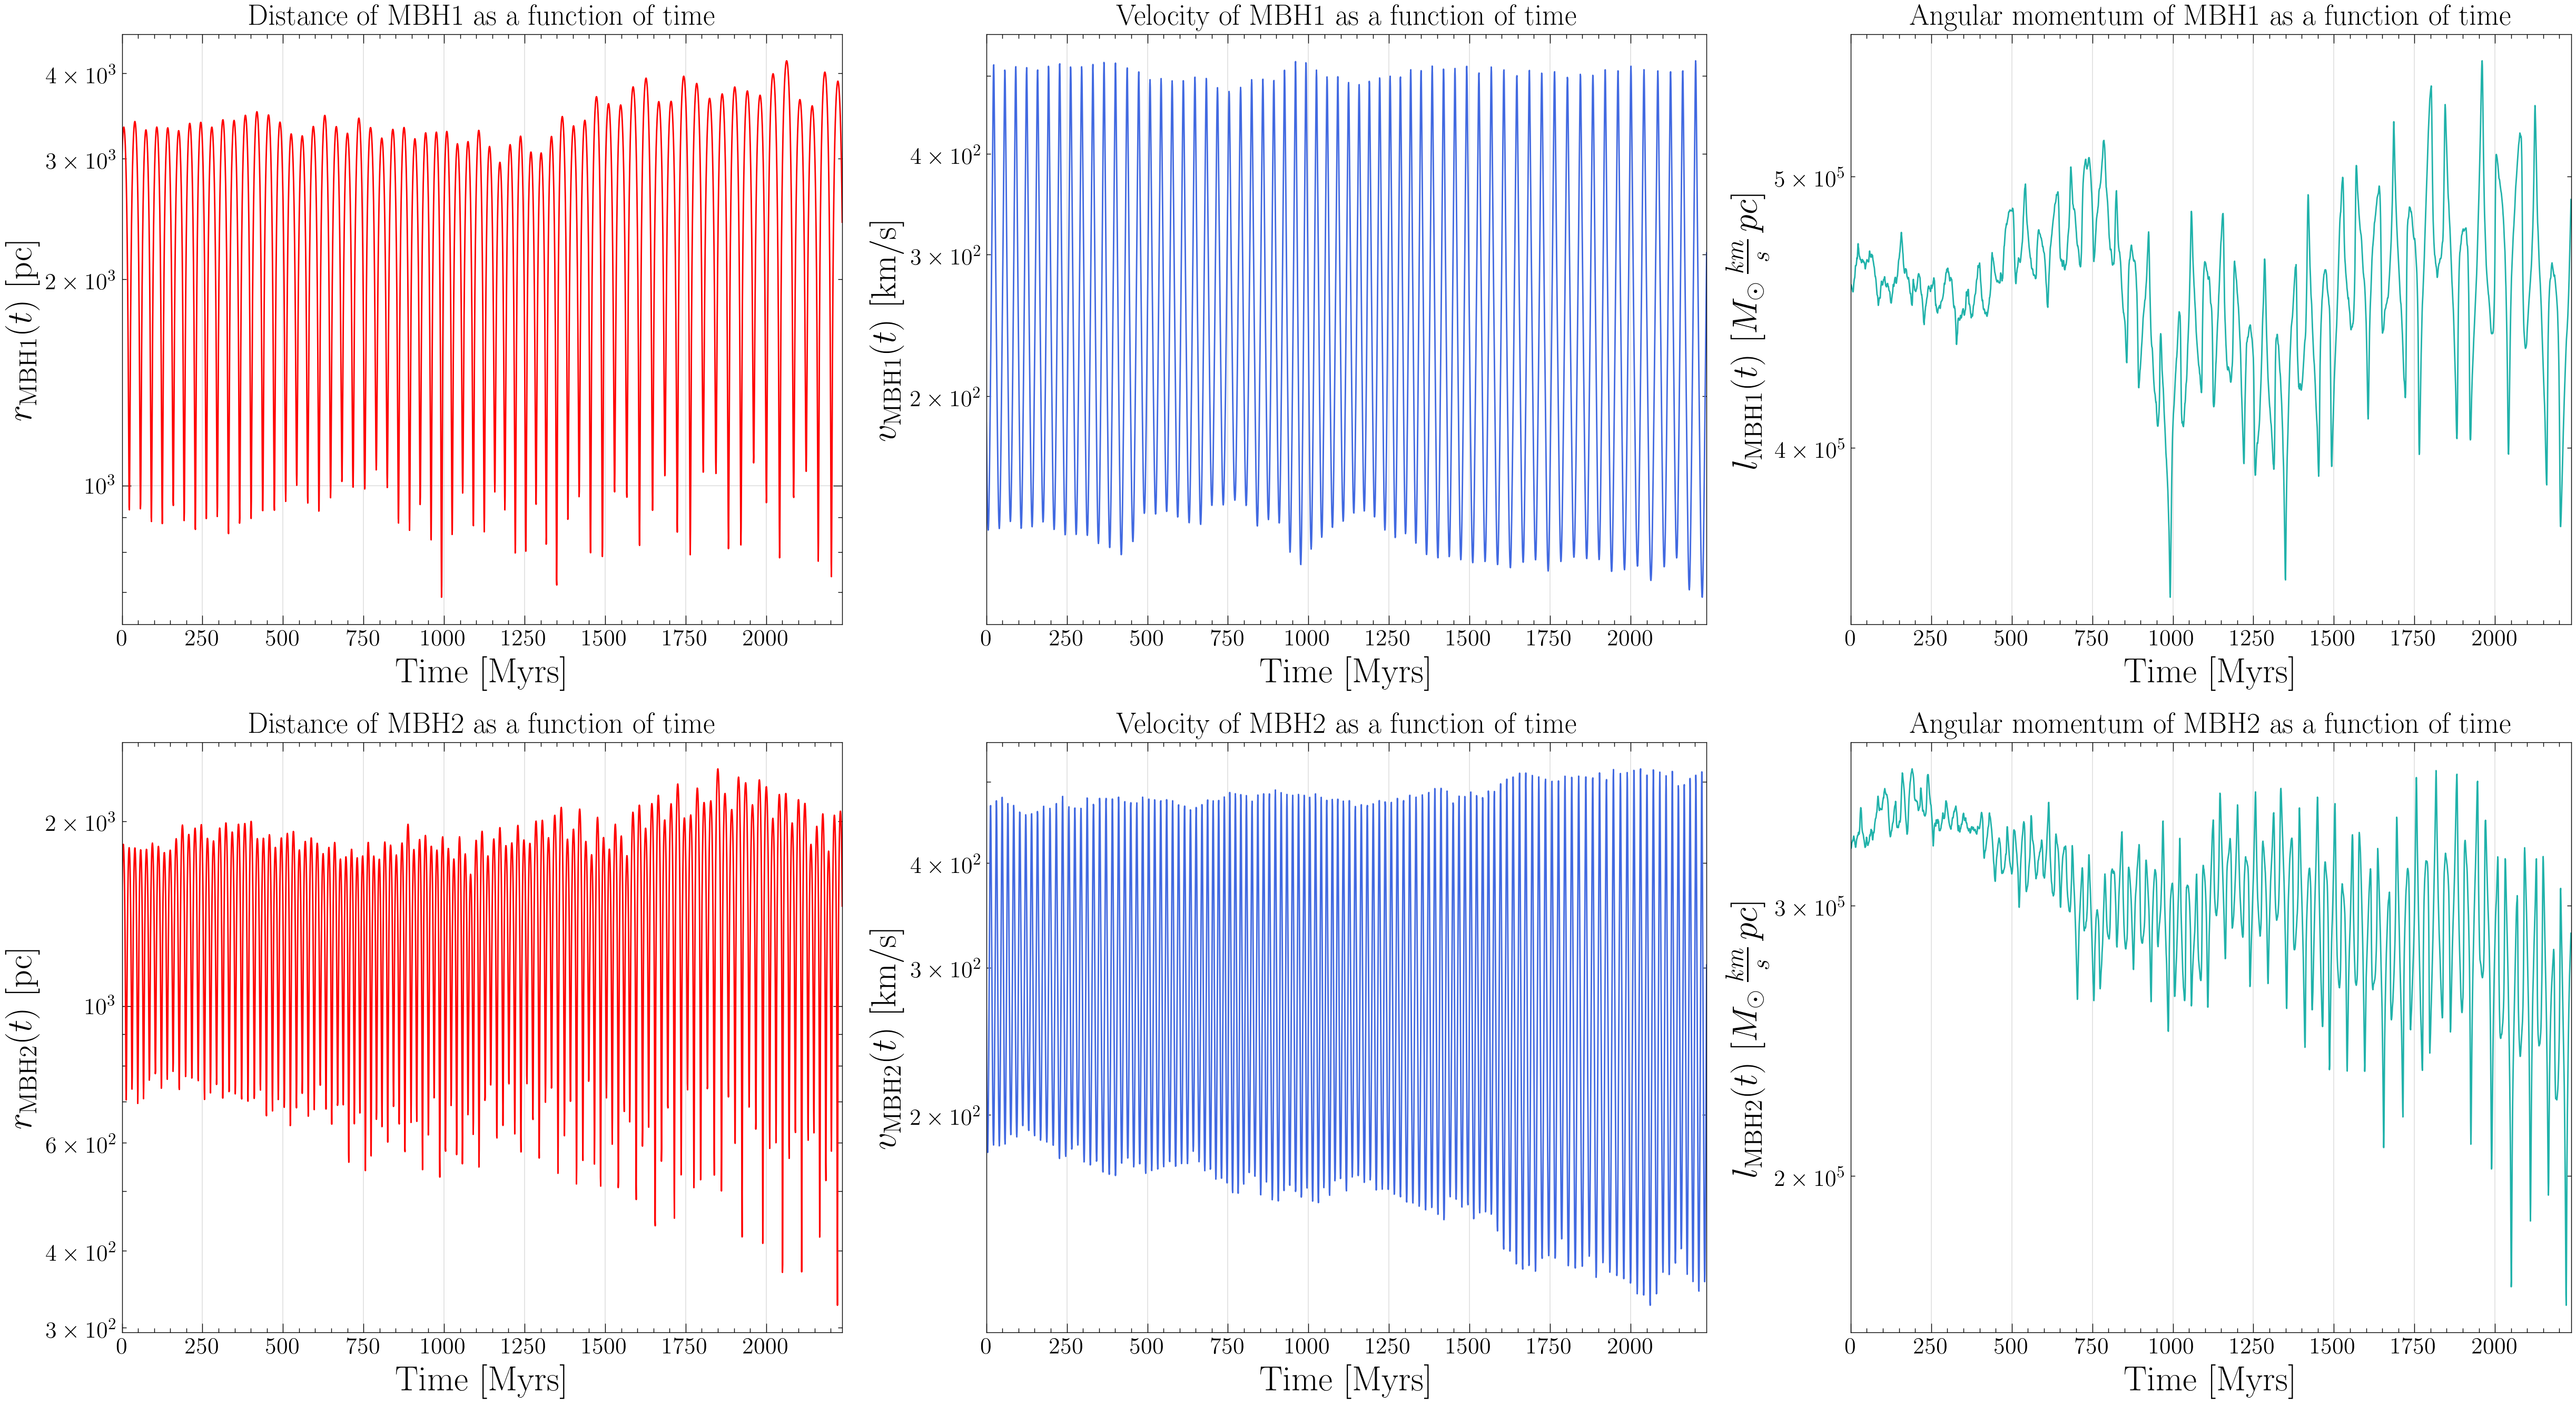

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(30, 16))

ax = axes[0,0]
ax.plot(time, dist_mbh1, color='red', lw=1)
ax.set_xlim(0, time[-1])
ax.set_yscale('log')
ax.set_title('Distance of MBH1 as a function of time', fontsize=20)
ax.set_xlabel('Time [Myrs]')
ax.set_ylabel('$r_{\\rm{MBH1}} (t)$ [pc]')

ax = axes[0,1]
ax.plot(time, v_mbh1, color='royalblue', lw=1)
ax.set_xlim(0, time[-1])
ax.set_yscale('log')
ax.set_title('Velocity of MBH1 as a function of time', fontsize=20)
ax.set_xlabel('Time [Myrs]')
ax.set_ylabel('$v_{\\rm{MBH1}} (t)$ [km/s]')

ax = axes[0,2]
ax.plot(time, angmom_mbh1, color='lightseagreen', lw=1)
ax.set_xlim(0, time[-1])
ax.set_yscale('log')
ax.set_title('Angular momentum of MBH1 as a function of time', fontsize=20)
ax.set_xlabel('Time [Myrs]')
ax.set_ylabel('$l_{\\rm{MBH1}} (t)$ $[M_\odot \, \\frac{km}{s} \, pc]$')

ax = axes[1,0]
ax.plot(time, dist_mbh2, color='red', lw=1)
ax.set_xlim(0, time[-1])
ax.set_yscale('log')
ax.set_title('Distance of MBH2 as a function of time', fontsize=20)
ax.set_xlabel('Time [Myrs]')
ax.set_ylabel('$r_{\\rm{MBH2}} (t)$ [pc]')

ax = axes[1,1]
ax.plot(time, v_mbh2, color='royalblue', lw=1)
ax.set_xlim(0, time[-1])
ax.set_yscale('log')
ax.set_title('Velocity of MBH2 as a function of time', fontsize=20)
ax.set_xlabel('Time [Myrs]')
ax.set_ylabel('$v_{\\rm{MBH2}} (t)$ [km/s]')

ax = axes[1,2]
ax.plot(time, angmom_mbh2, color='lightseagreen', lw=1)
ax.set_xlim(0, time[-1])
ax.set_yscale('log')
ax.set_title('Angular momentum of MBH2 as a function of time', fontsize=20)
ax.set_xlabel('Time [Myrs]')
ax.set_ylabel('$l_{\\rm{MBH2}} (t)$ $[M_\odot \, \\frac{km}{s} \, pc]$');

# Binary separation

We can estimate the influence radius of a black hole as:

$r_\text{influence}(t) \, = \, \dfrac{GM}{\sigma^2(t)}$, where $\sigma$ is the velocity dispersion of the surrounding stars.\
We can consider the particles in a shell surrouding the black holes (not too close, nor to far) at each time-step $t_i$ and compute $r_\text{influence} (t_i)$

100%|██████████| 3001/3001 [00:04<00:00, 749.53it/s]


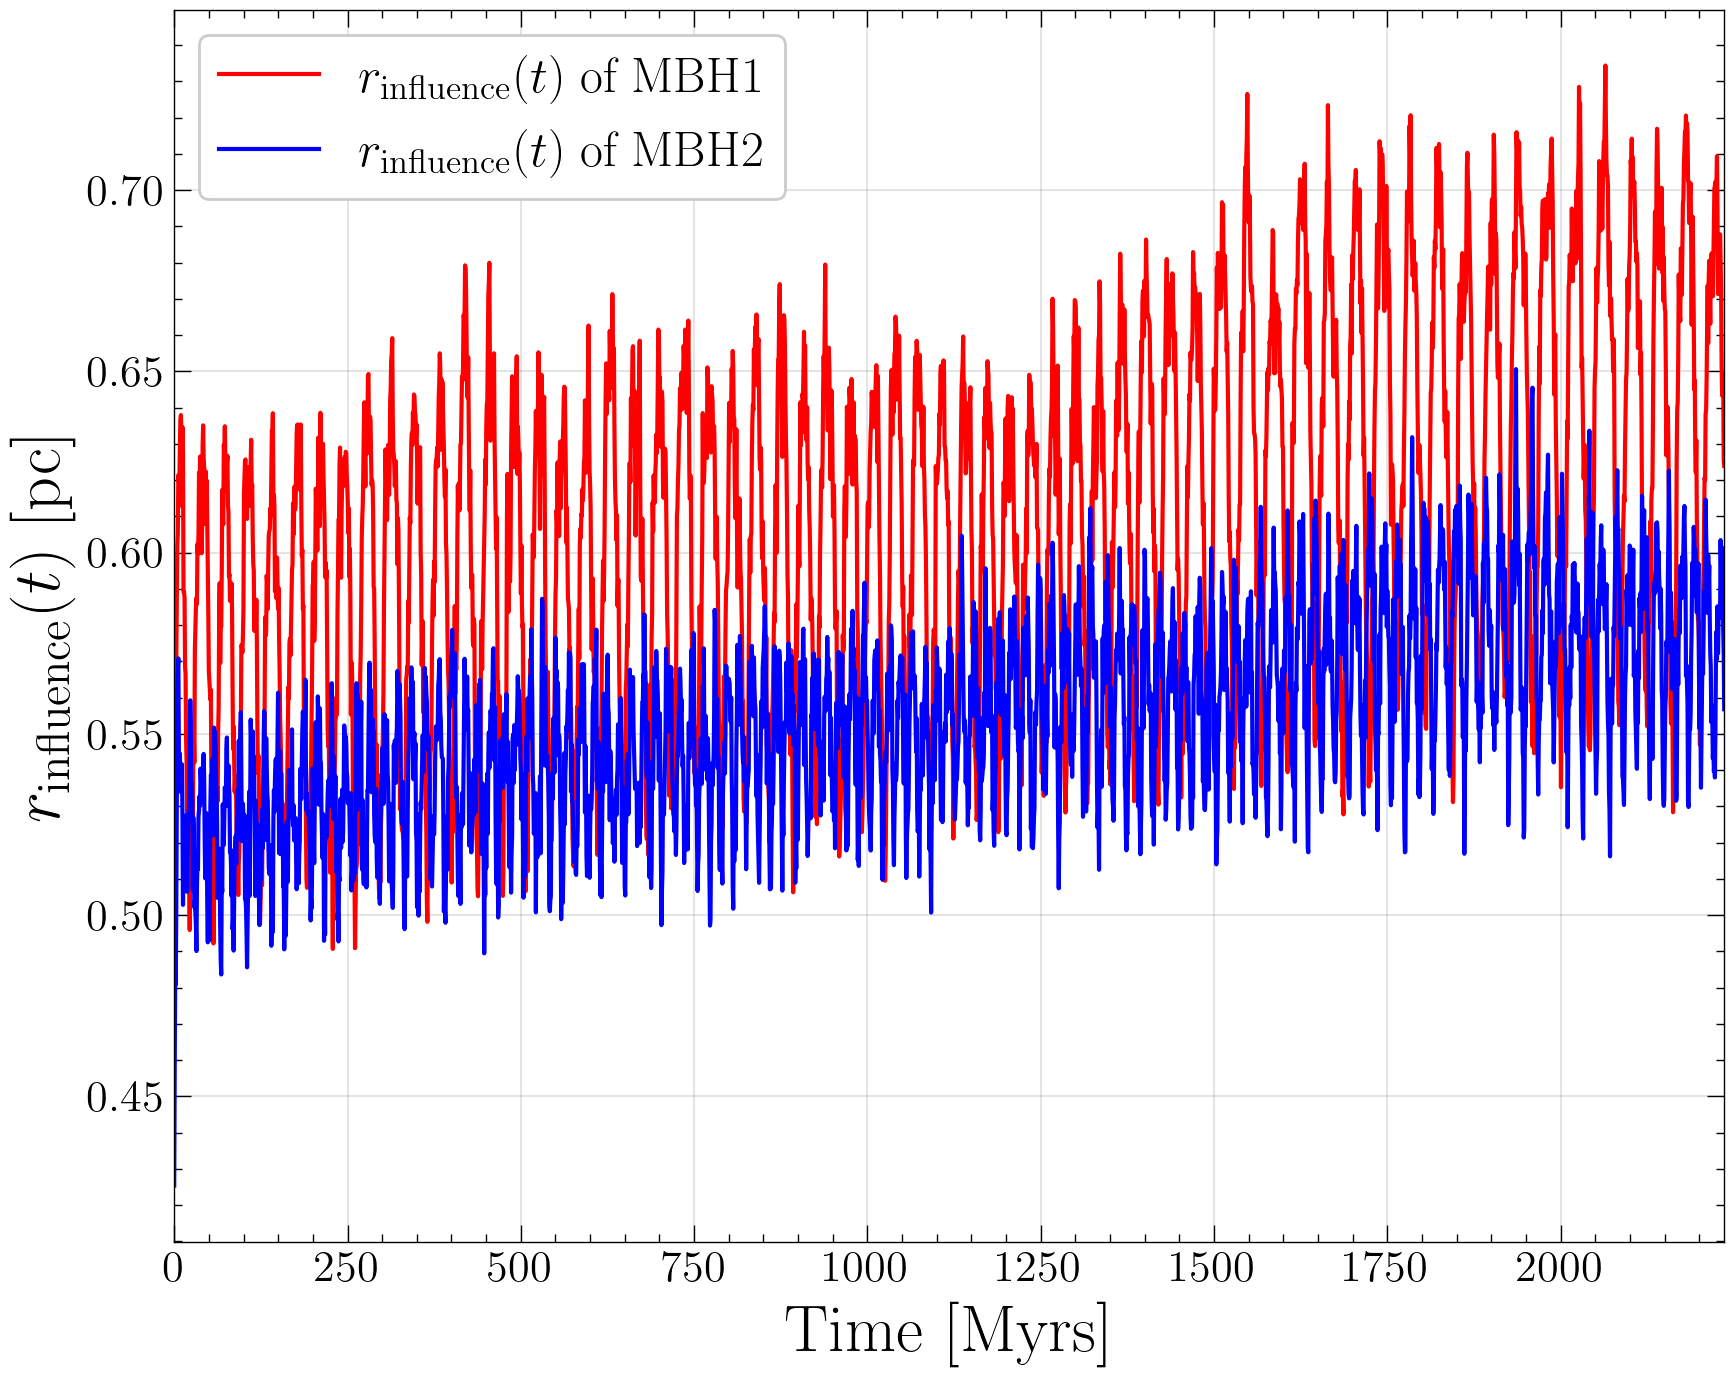

In [23]:
def Influence_Radius(x, y, z, vx, vy, vz, time, index_perturber=-1, radius=500):
    sigma = np.zeros(len(time))
    r_influence = np.zeros(len(time))
    
    # This will be useful later 
    volume = (4/3)*np.pi*radius**3
    number_density = np.zeros(len(time))
    #########################################

    for i in tqdm(range(len(time))):
        dist_particle_i = Dist(x[:-2,i], y[:-2,i], z[:-2,i], x[index_perturber,i], y[index_perturber,i], z[index_perturber,i])
        mask = np.logical_and(np.quantile(dist_particle_i, 0.05)<dist_particle_i, dist_particle_i<np.quantile(dist_particle_i, 0.15)) 

        sigma[i] = np.std(np.sqrt(vx[:-2,i][mask]**2 + vy[:-2,i][mask]**2 + vz[:-2,i][mask]**2))
        
        r_influence[i] = G_pu*M_mbh/sigma[i]**2
        
        # This will be useful later 
        mask = dist_particle_i<radius
        number_density[i] = np.sum(mask)/volume
        #########################################
        
        
    return r_influence, sigma, number_density
    

r_influence_mbh1, sigma_mbh1, number_density_mbh1 = Influence_Radius(x, y, z, vx, vy, vz, time, index_perturber=-1, radius=500)
r_influence_mbh2, sigma_mbh2, number_density_mbh2 = Influence_Radius(x, y, z, vx, vy, vz, time, index_perturber=-2, radius=500)

plt.plot(time, r_influence_mbh1, color='red', label='$r_{\\text{influence}} (t)$ of MBH1')
plt.plot(time, r_influence_mbh2, color='blue', label='$r_{\\text{influence}} (t)$ of MBH2')
plt.xlim(0, time[-1])
plt.xlabel('Time [Myrs]')
plt.ylabel('$r_{\\text{influence}} (t)$ [pc]')
plt.legend();

In [24]:
r_influence = np.mean(np.array([r_influence_mbh1, r_influence_mbh2]), axis=0)
del r_influence_mbh1, r_influence_mbh2

Compute the separation of the two MBHs

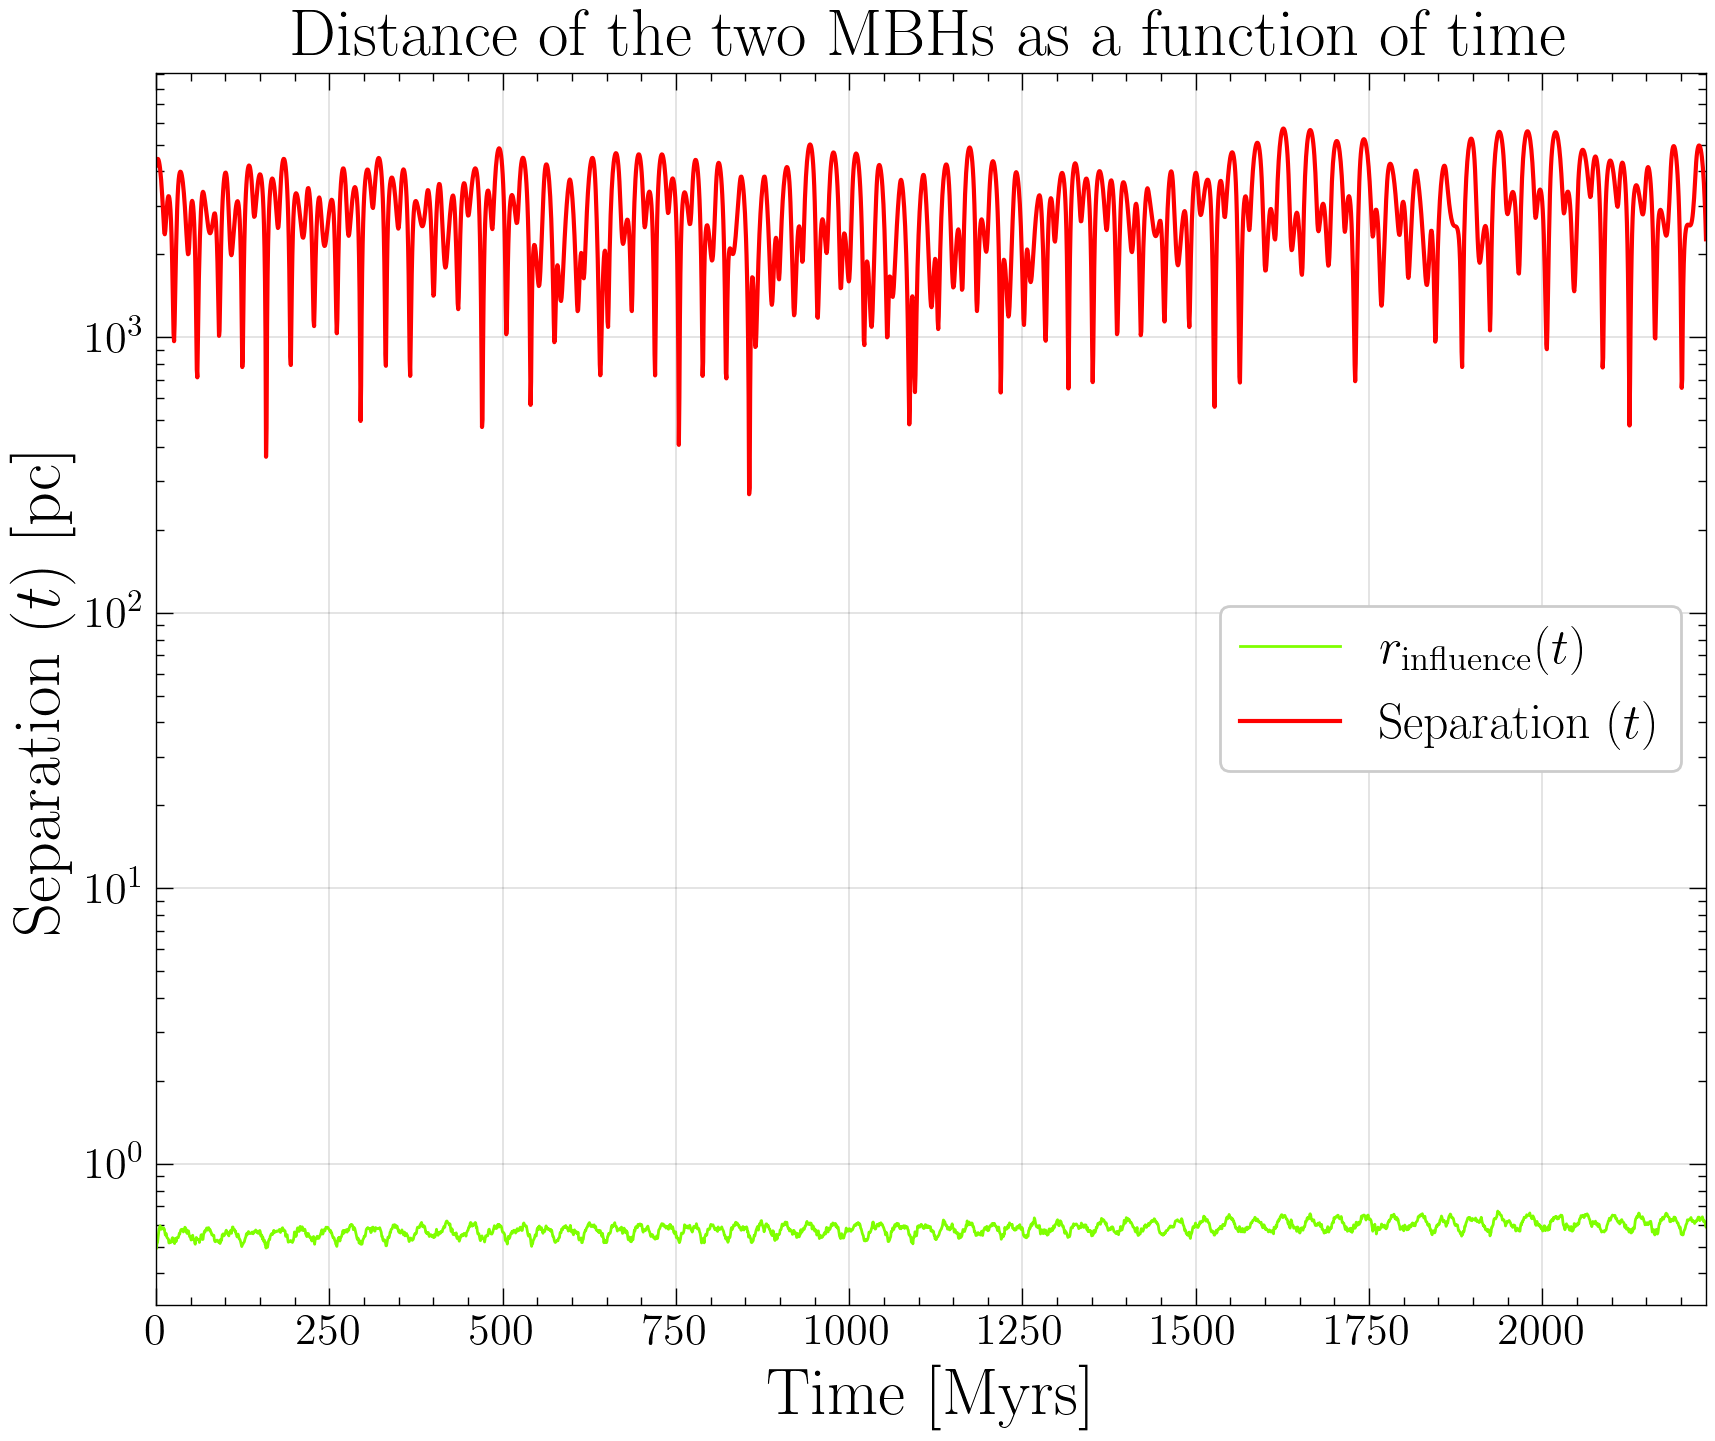

In [25]:
dist_mbhs = Dist(x[-1,:], y[-1,:], z[-1,:], x[-2,:], y[-2,:], z[-2,:])

plt.plot(time, r_influence, color='chartreuse', lw=1, label='$r_{\\text{influence}}(t)$')
plt.plot(time, dist_mbhs, color='red', label='Separation $(t)$')
plt.xlim(0, time[-1])
plt.yscale('log')
plt.title('Distance of the two MBHs as a function of time')
plt.xlabel('Time [Myrs]')
plt.ylabel('Separation $(t)$ [pc]')
plt.legend();

If the velocity vectors and the radial separation vector lie in the same plane, then $\hat{v_1} \cdot \left[\hat{v_2} \times (\hat{r_1} - \hat{r_2})\right] \simeq 0$

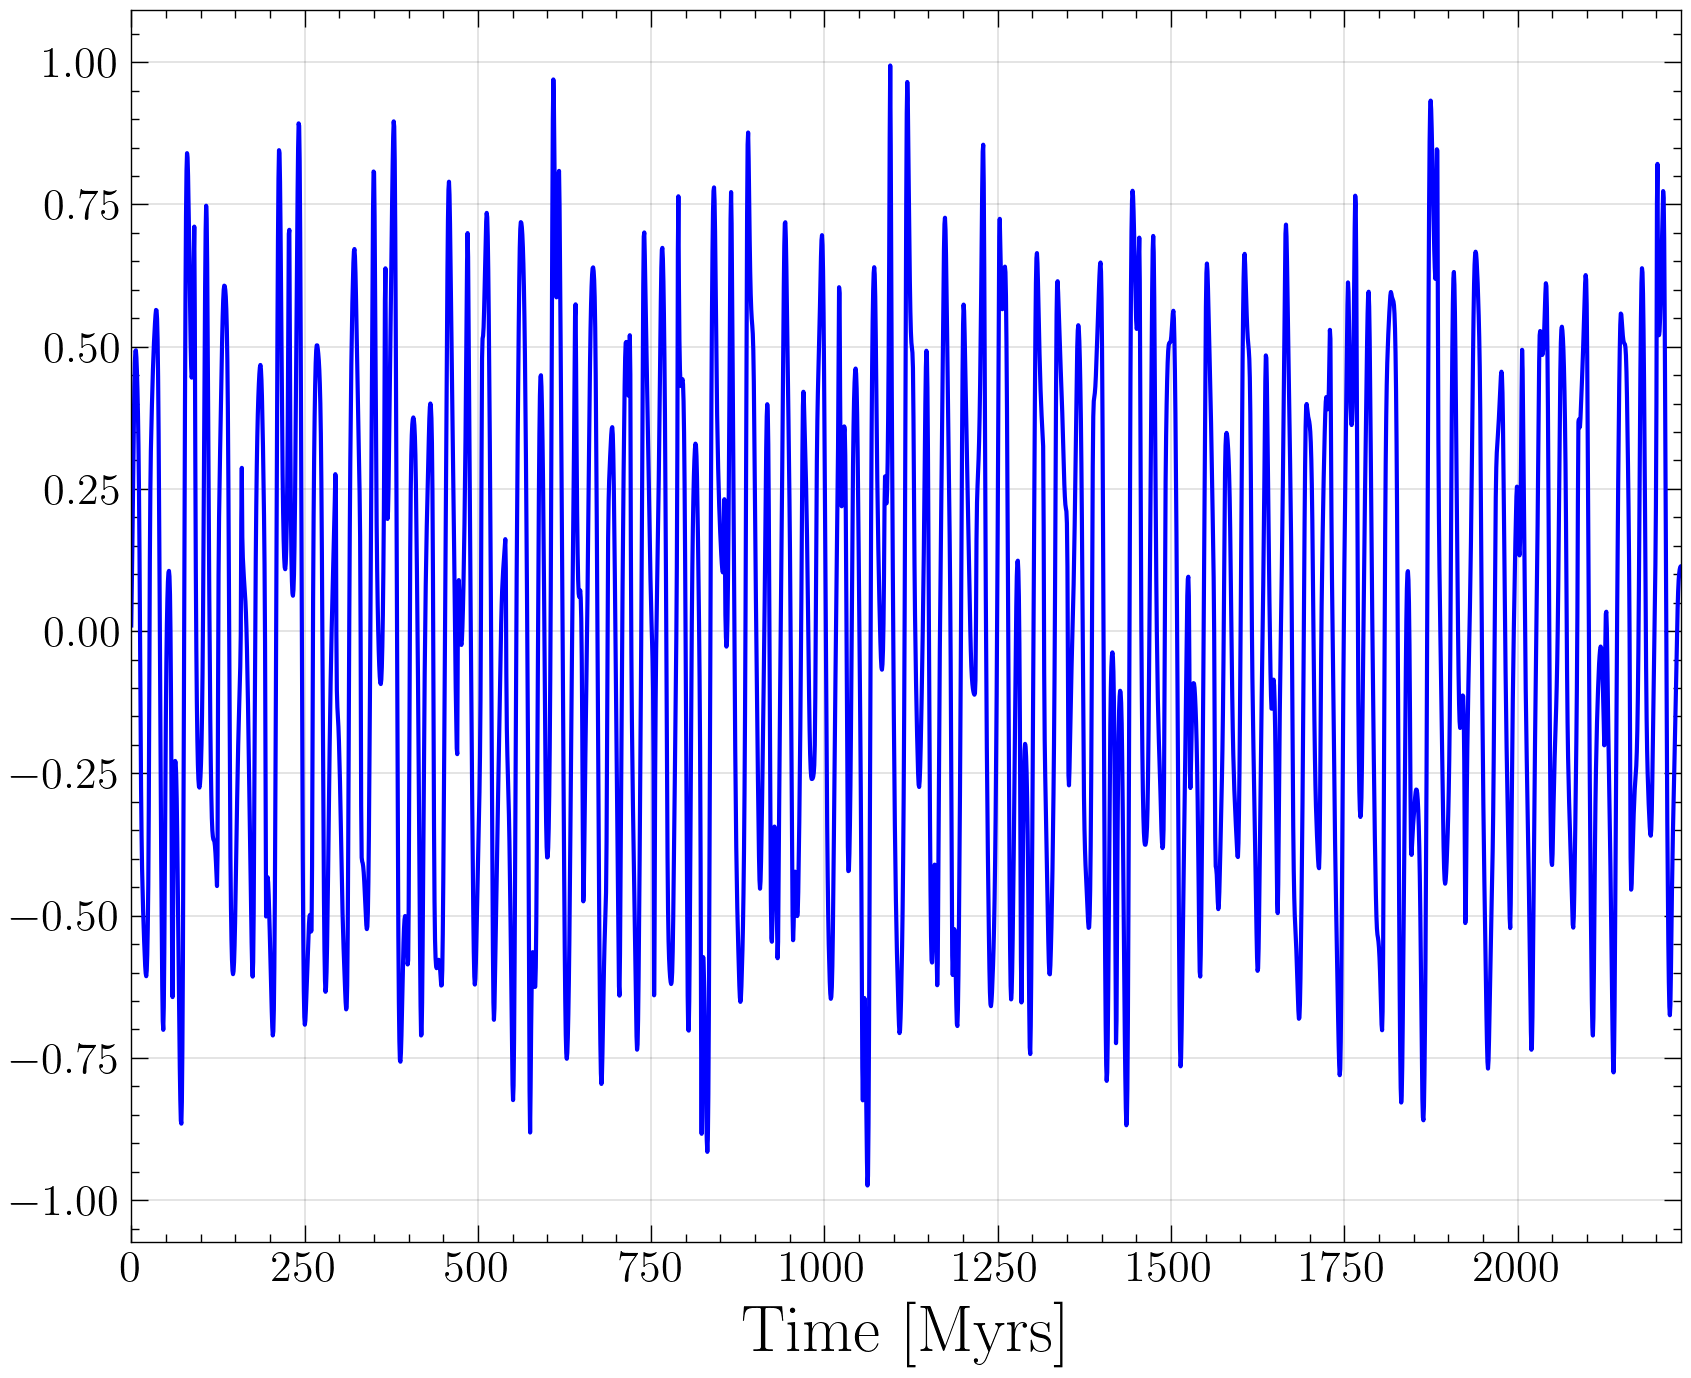

In [26]:
def Check_Coplanarity(x1, x2, v1, v2):
    coplanarity = np.zeros(len(time))

    for i in range(len(time)):
        v1_i = v1[:,i]
        v1_i = v1_i / np.linalg.norm(v1_i)

        v2_i = v2[:,i]
        v2_i = v2_i / np.linalg.norm(v2_i)

        r_rel_i = x1[:,i] - x2[:,i]
        r_rel_i = r_rel_i / np.linalg.norm(r_rel_i)

        coplanarity[i] = np.dot(v1_i, np.cross(v2_i, r_rel_i))
        
    return coplanarity
    
    
coplanarity = Check_Coplanarity(np.array([x[-1], y[-1], z[-1]]), 
                                np.array([x[-2], y[-2], z[-2]]), 
                                np.array([vx[-1], vy[-1], vz[-1]]), 
                                np.array([vx[-2], vy[-2], vz[-2]]))     
plt.plot(time, coplanarity, color='blue')
plt.xlim(0, time[-1])
plt.xlabel('Time [Myrs]');

# Binary reference frame

In [27]:
CMbinary_pos_vector = (np.array([x[-1], y[-1], z[-1]]) + np.array([x[-2], y[-2], z[-2]]))/2
CMbinary_v_vector = (np.array([vx[-1], vy[-1], vz[-1]]) + np.array([vx[-2], vy[-2], vz[-2]]))/2

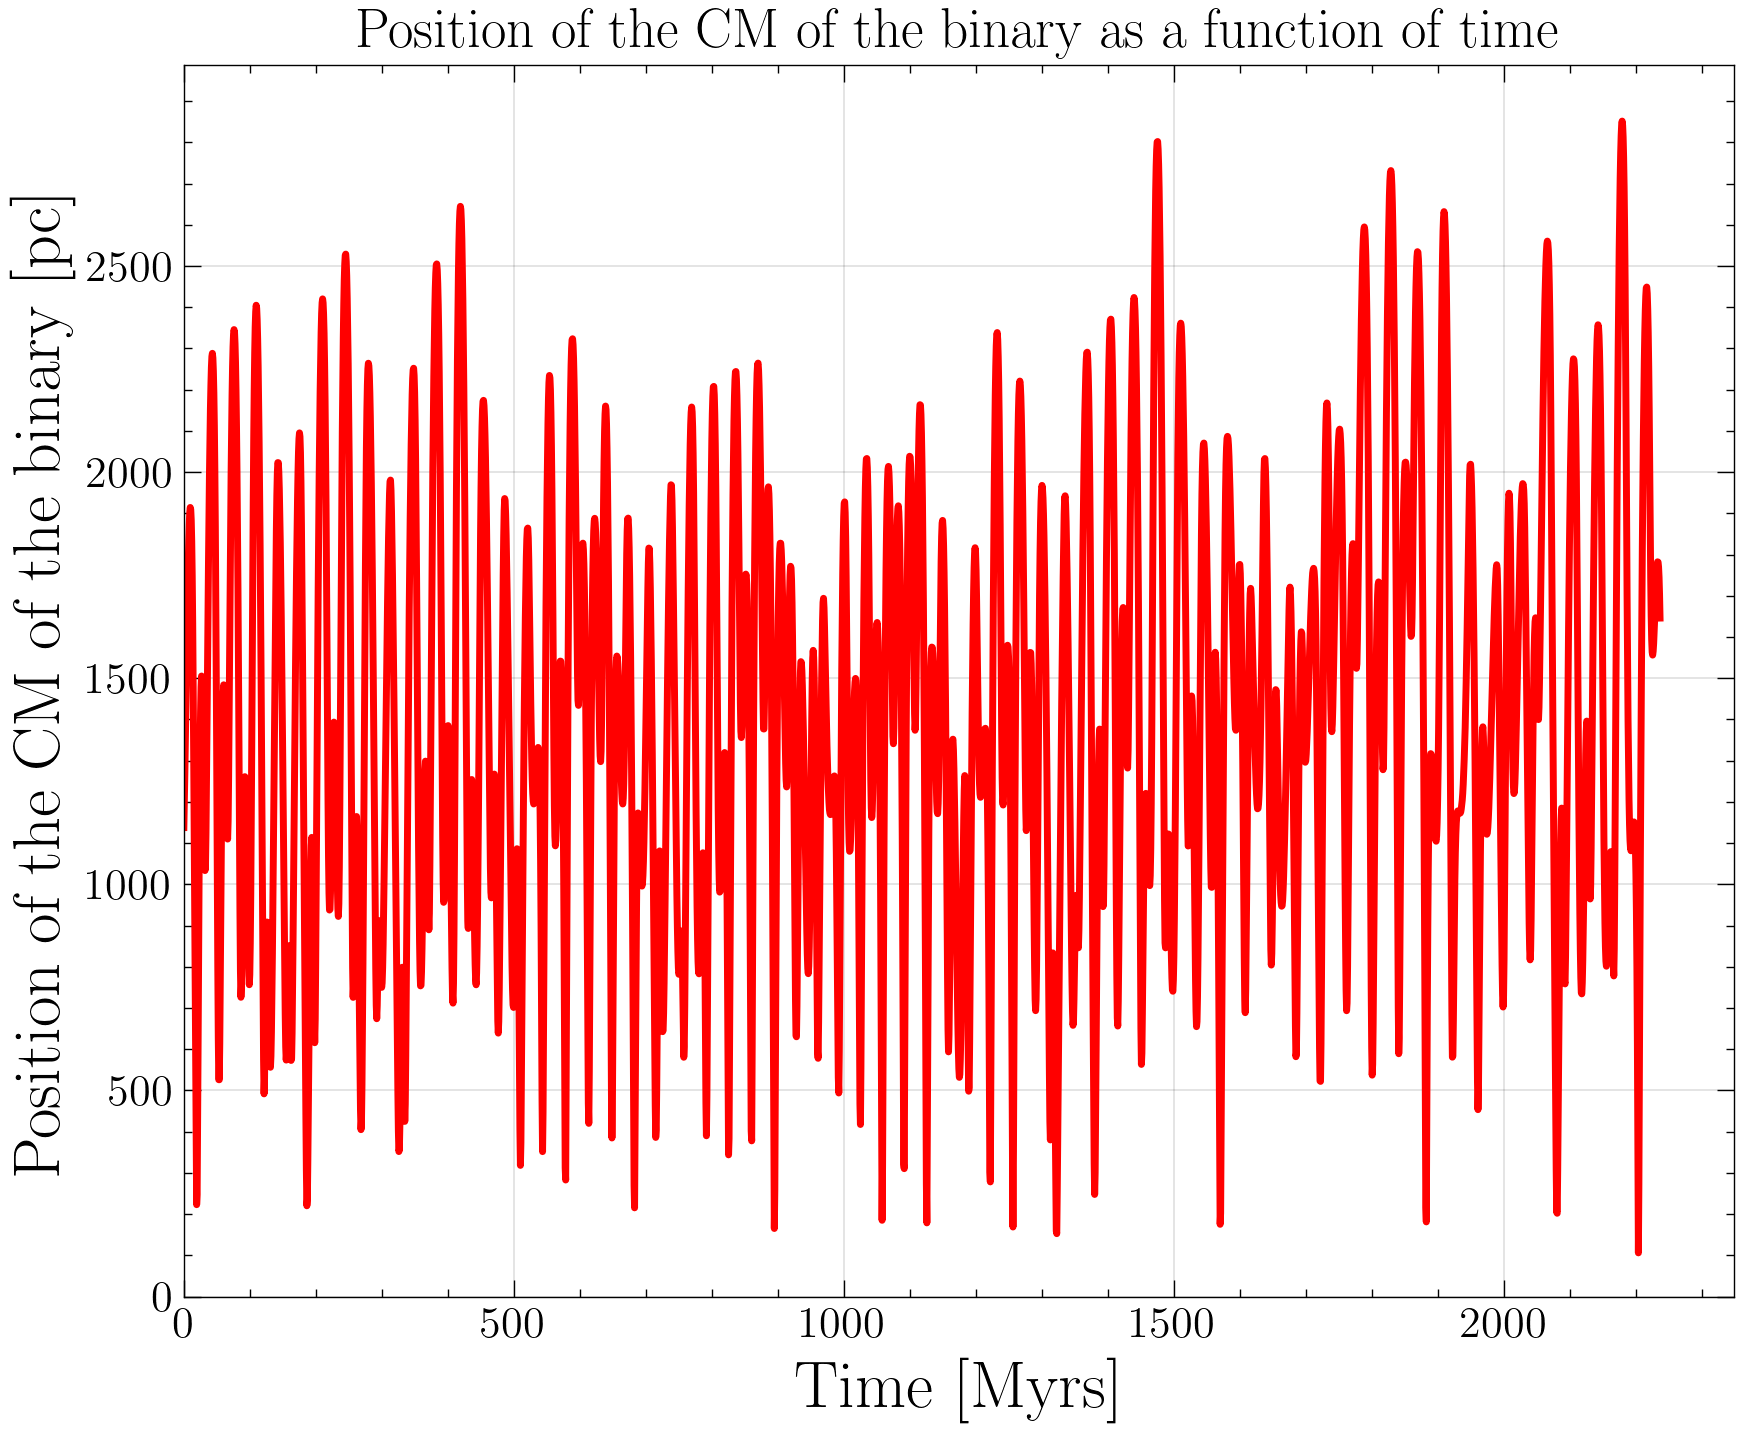

In [28]:
plt.plot(time, np.linalg.norm(CMbinary_pos_vector, axis=0), color='red', lw=2.5)
plt.xlim(0)
plt.ylim(0)
plt.title('Position of the CM of the binary as a function of time', fontsize=20)
plt.xlabel('Time [Myrs]')
plt.ylabel('Position of the CM of the binary [pc]');

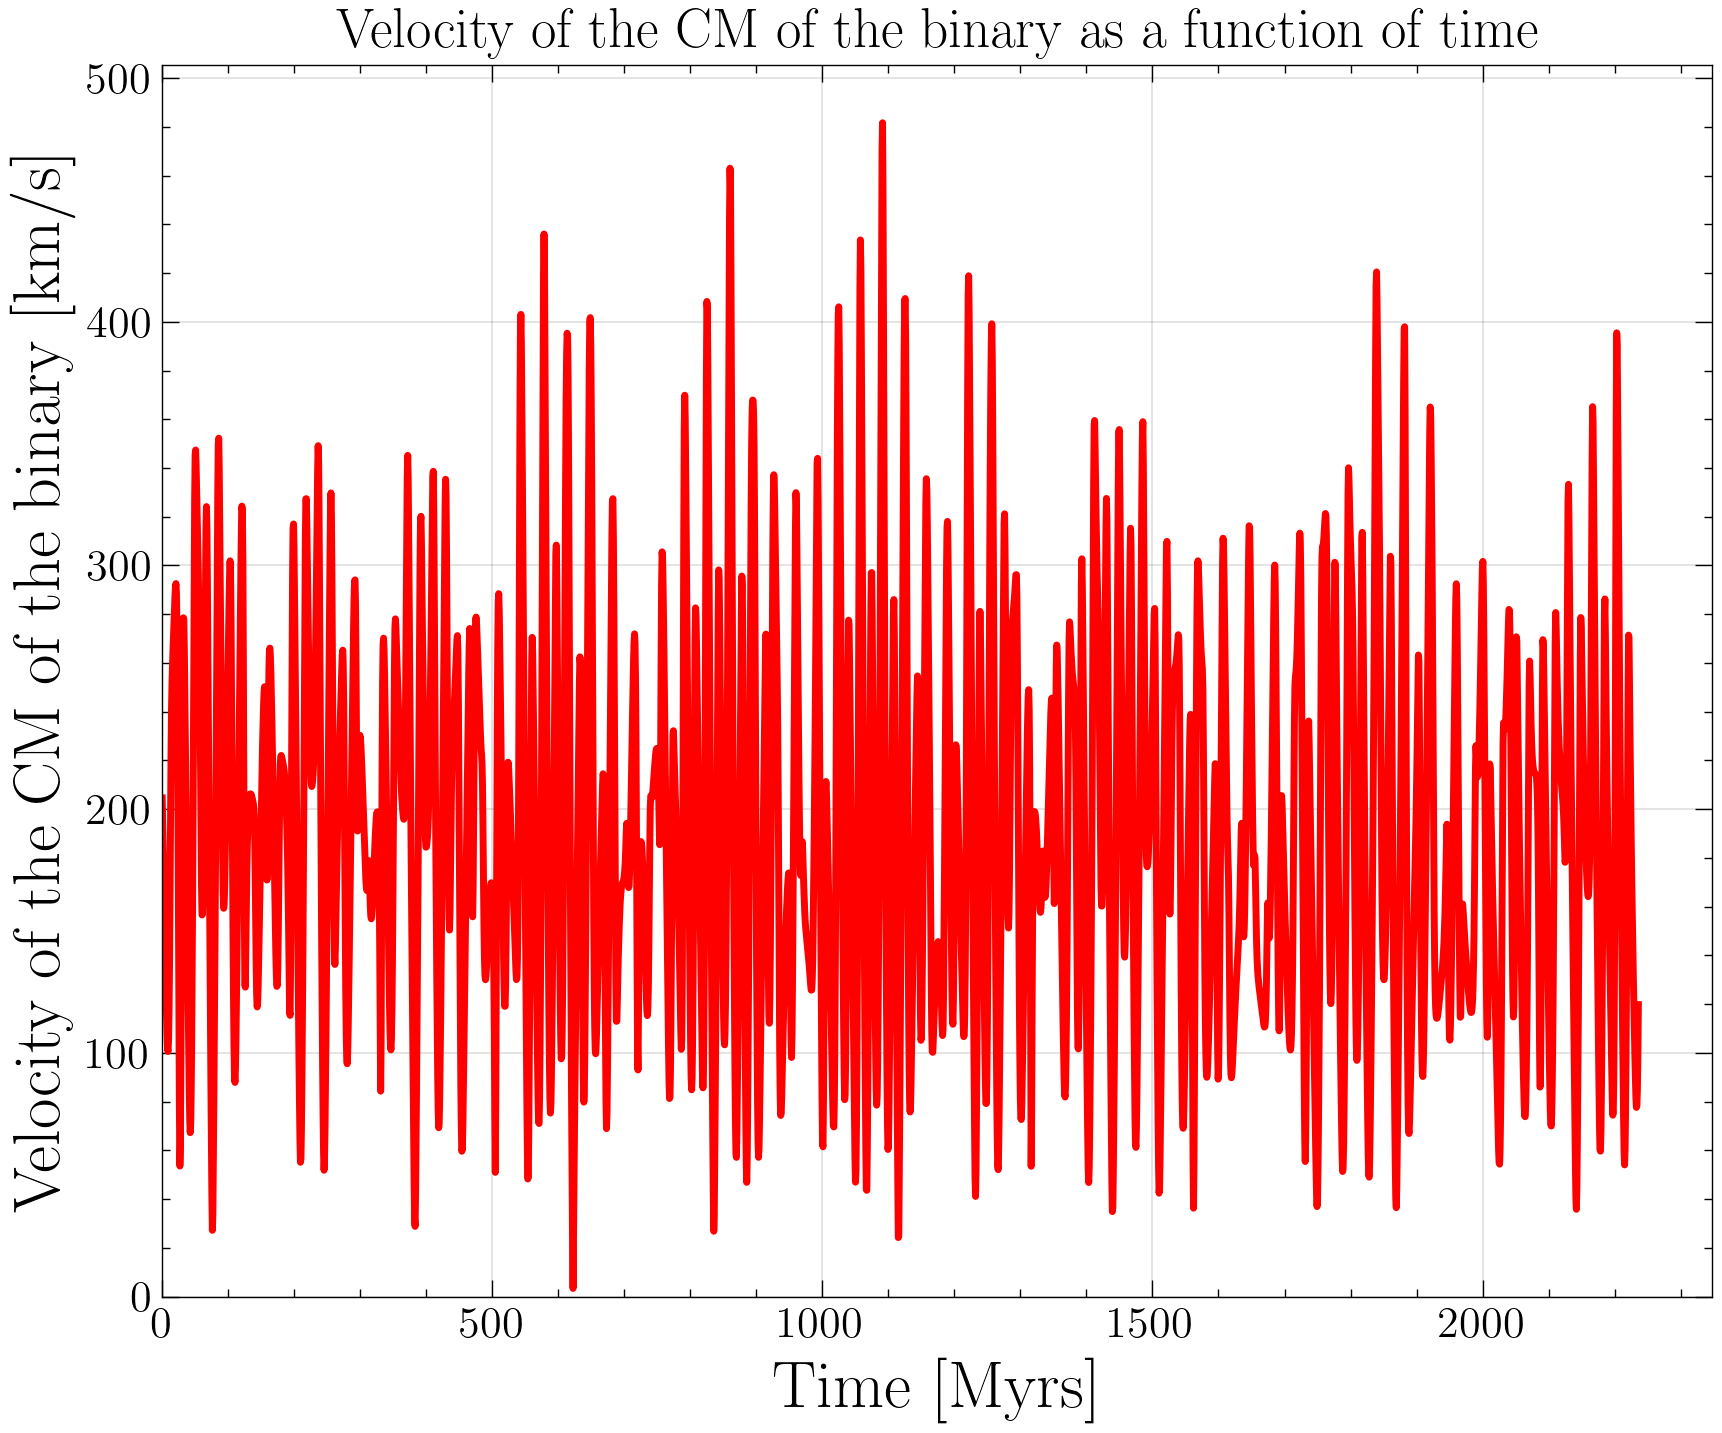

In [29]:
plt.plot(time, np.linalg.norm(CMbinary_v_vector, axis=0), color='red', lw=2.5)
plt.xlim(0)
plt.ylim(0)
plt.title('Velocity of the CM of the binary as a function of time', fontsize=20)
plt.xlabel('Time [Myrs]')
plt.ylabel('Velocity of the CM of the binary [km/s]');

In [30]:
pos_CMbinary_mbh1 = np.array([x[-1], y[-1], z[-1]]) - CMbinary_pos_vector
pos_CMbinary_mbh2 =  np.array([x[-2], y[-2], z[-2]]) - CMbinary_pos_vector
v_CMbinary_mbh1 = np.array([vx[-1], vy[-1], vz[-1]]) - CMbinary_v_vector
v_CMbinary_mbh2 = np.array([vx[-2], vy[-2], vz[-2]]) - CMbinary_v_vector

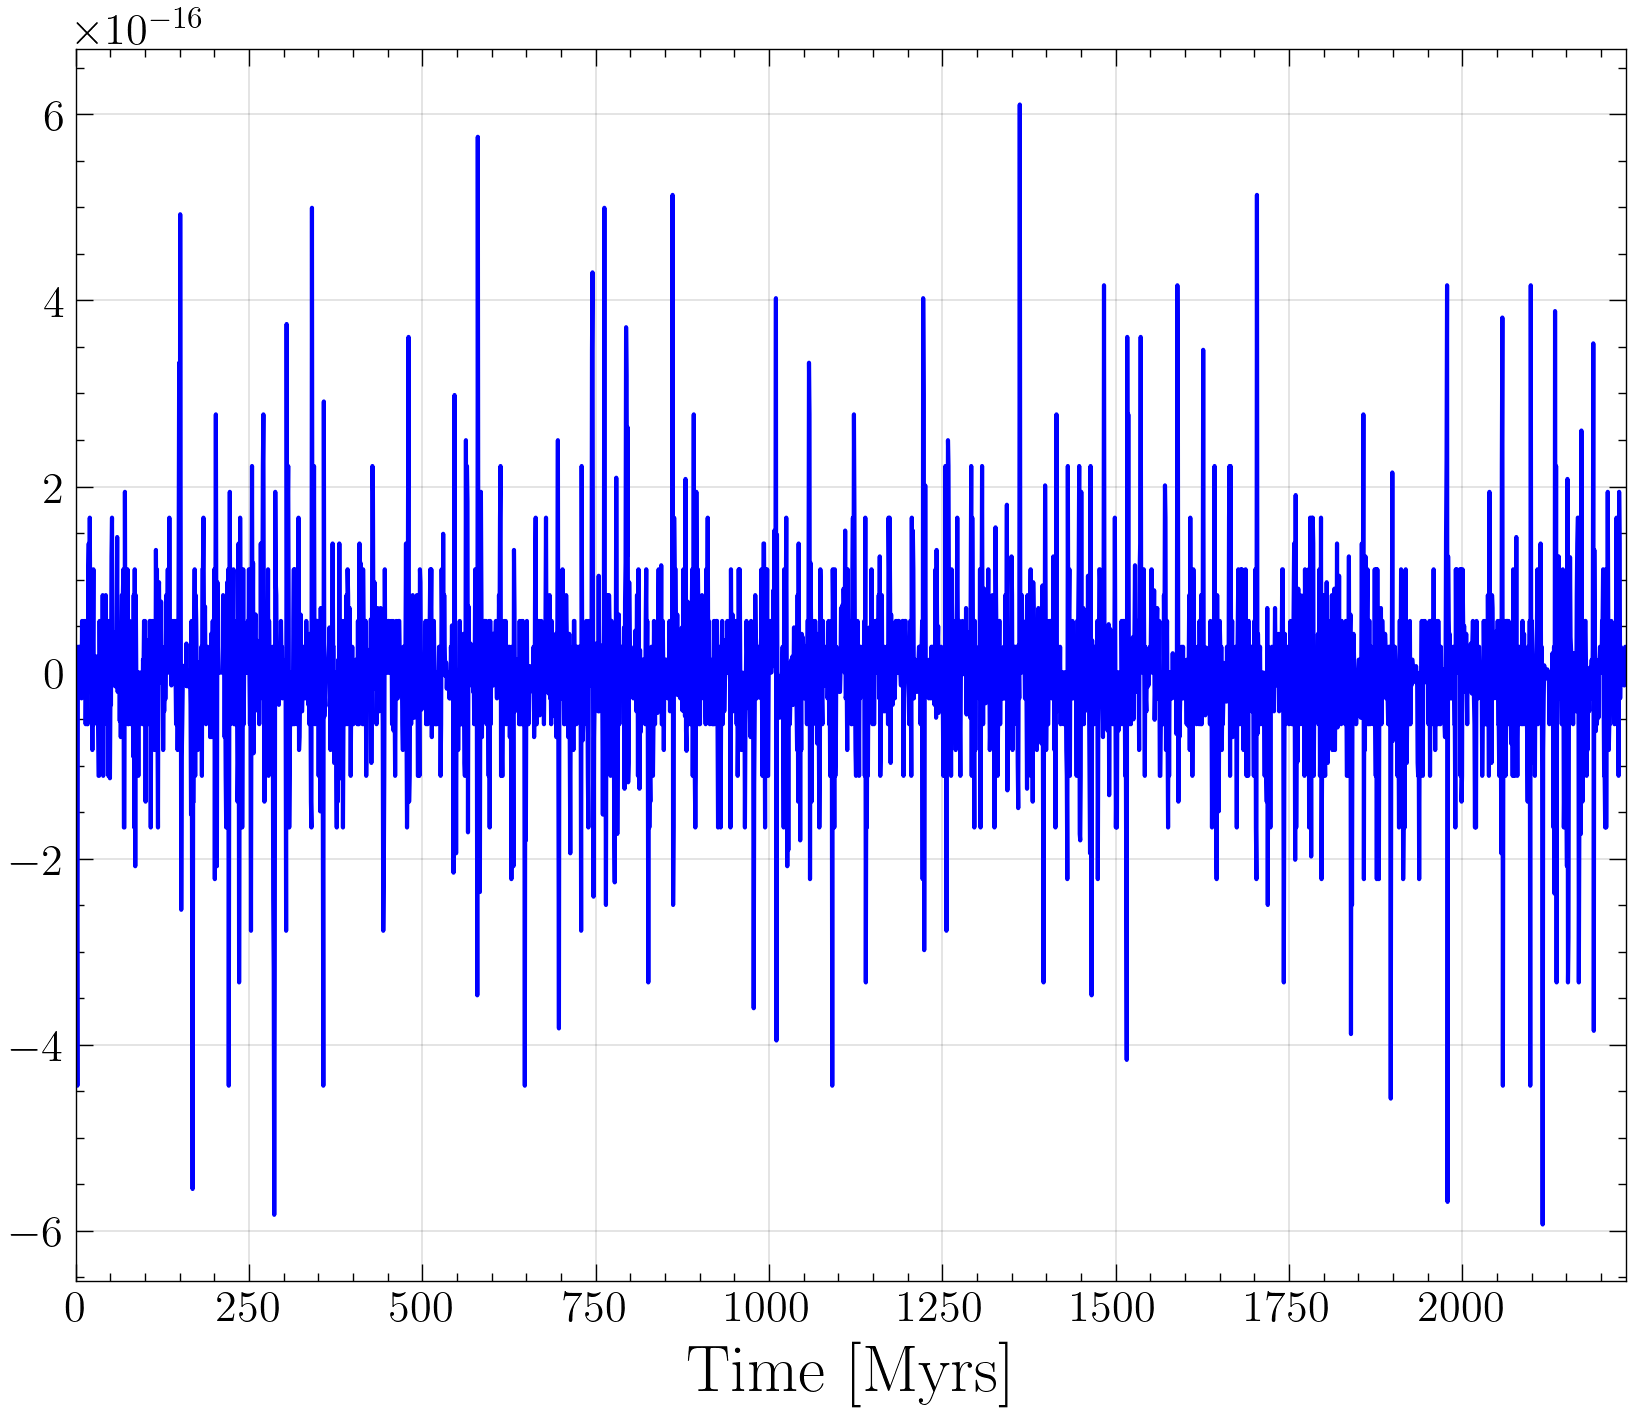

In [31]:
coplanarity = Check_Coplanarity(pos_CMbinary_mbh1, 
                                pos_CMbinary_mbh2, 
                                v_CMbinary_mbh1, 
                                v_CMbinary_mbh2)     
plt.plot(time, coplanarity, color='blue')
plt.xlim(0, time[-1])
plt.xlabel('Time [Myrs]');

In [32]:
angmom_CMbinary_mbh1 = np.cross(pos_CMbinary_mbh1.T, v_CMbinary_mbh1.T).T
angmom_CMbinary_mbh2 = np.cross(pos_CMbinary_mbh2.T, v_CMbinary_mbh2.T).T

angmom_binary = angmom_CMbinary_mbh1 + angmom_CMbinary_mbh2

del CMbinary_pos_vector, CMbinary_v_vector, coplanarity, angmom_CMbinary_mbh1, angmom_CMbinary_mbh2

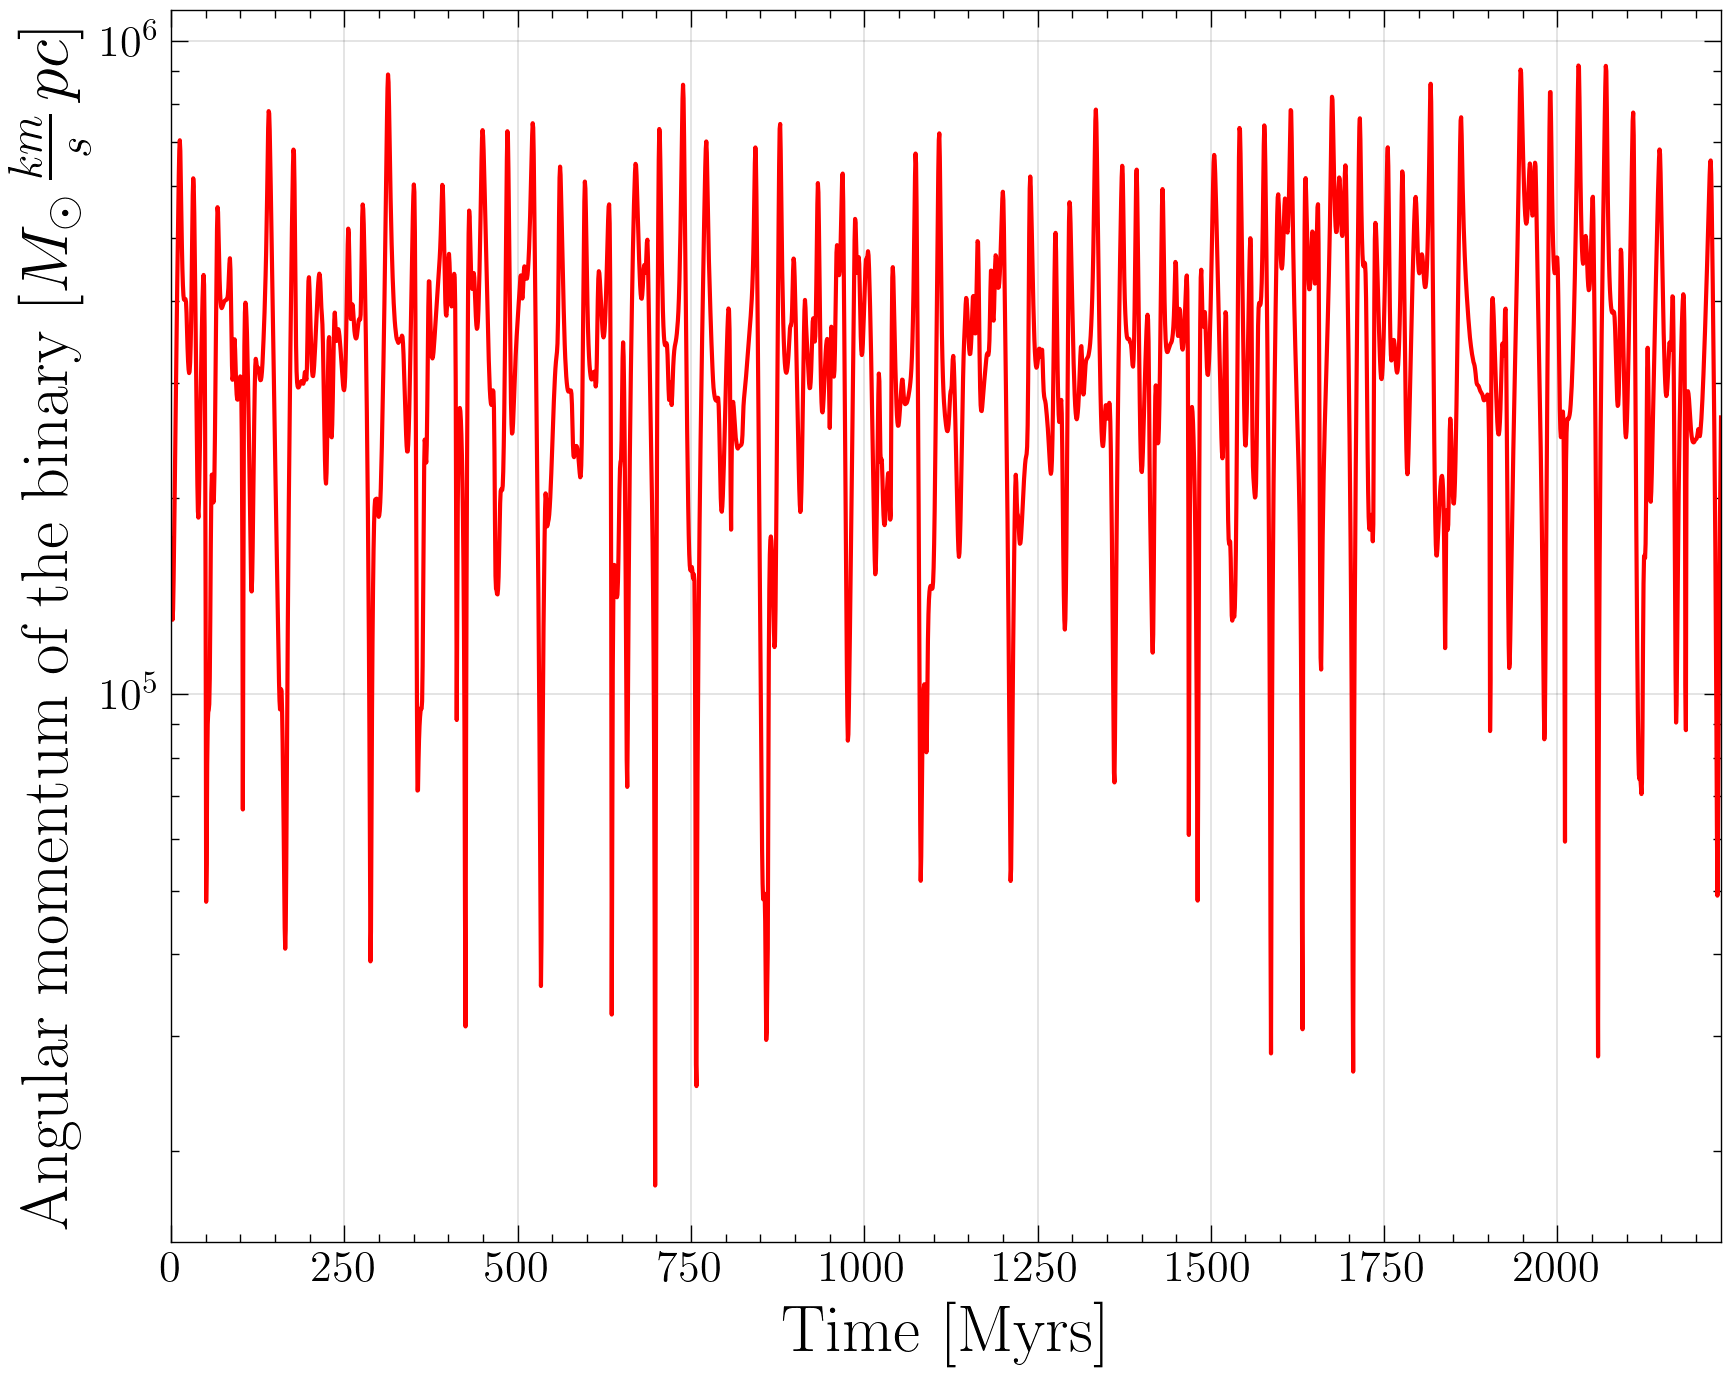

In [33]:
plt.plot(time, np.linalg.norm(angmom_binary, axis=0), color='red')
plt.xlim(0, time[-1])
plt.yscale('log')
plt.xlabel('Time [Myrs]')
plt.ylabel('Angular momentum of the binary $[M_\odot \, \\frac{km}{s} \, pc]$');

We can compute the critical radius $r_\text{crit}$ at which the energy of the binary becomes negative:

$E_\text{binary} (r_\text{crit}) \, = \, \dfrac{1}{2} M_\text{MBH} v^2_\text{MBH,1} + \dfrac{1}{2} M_\text{MBH} v^2_\text{MBH,2} - \dfrac{G M^2_\text{MBH}}{r_\text{crit}} = 0$

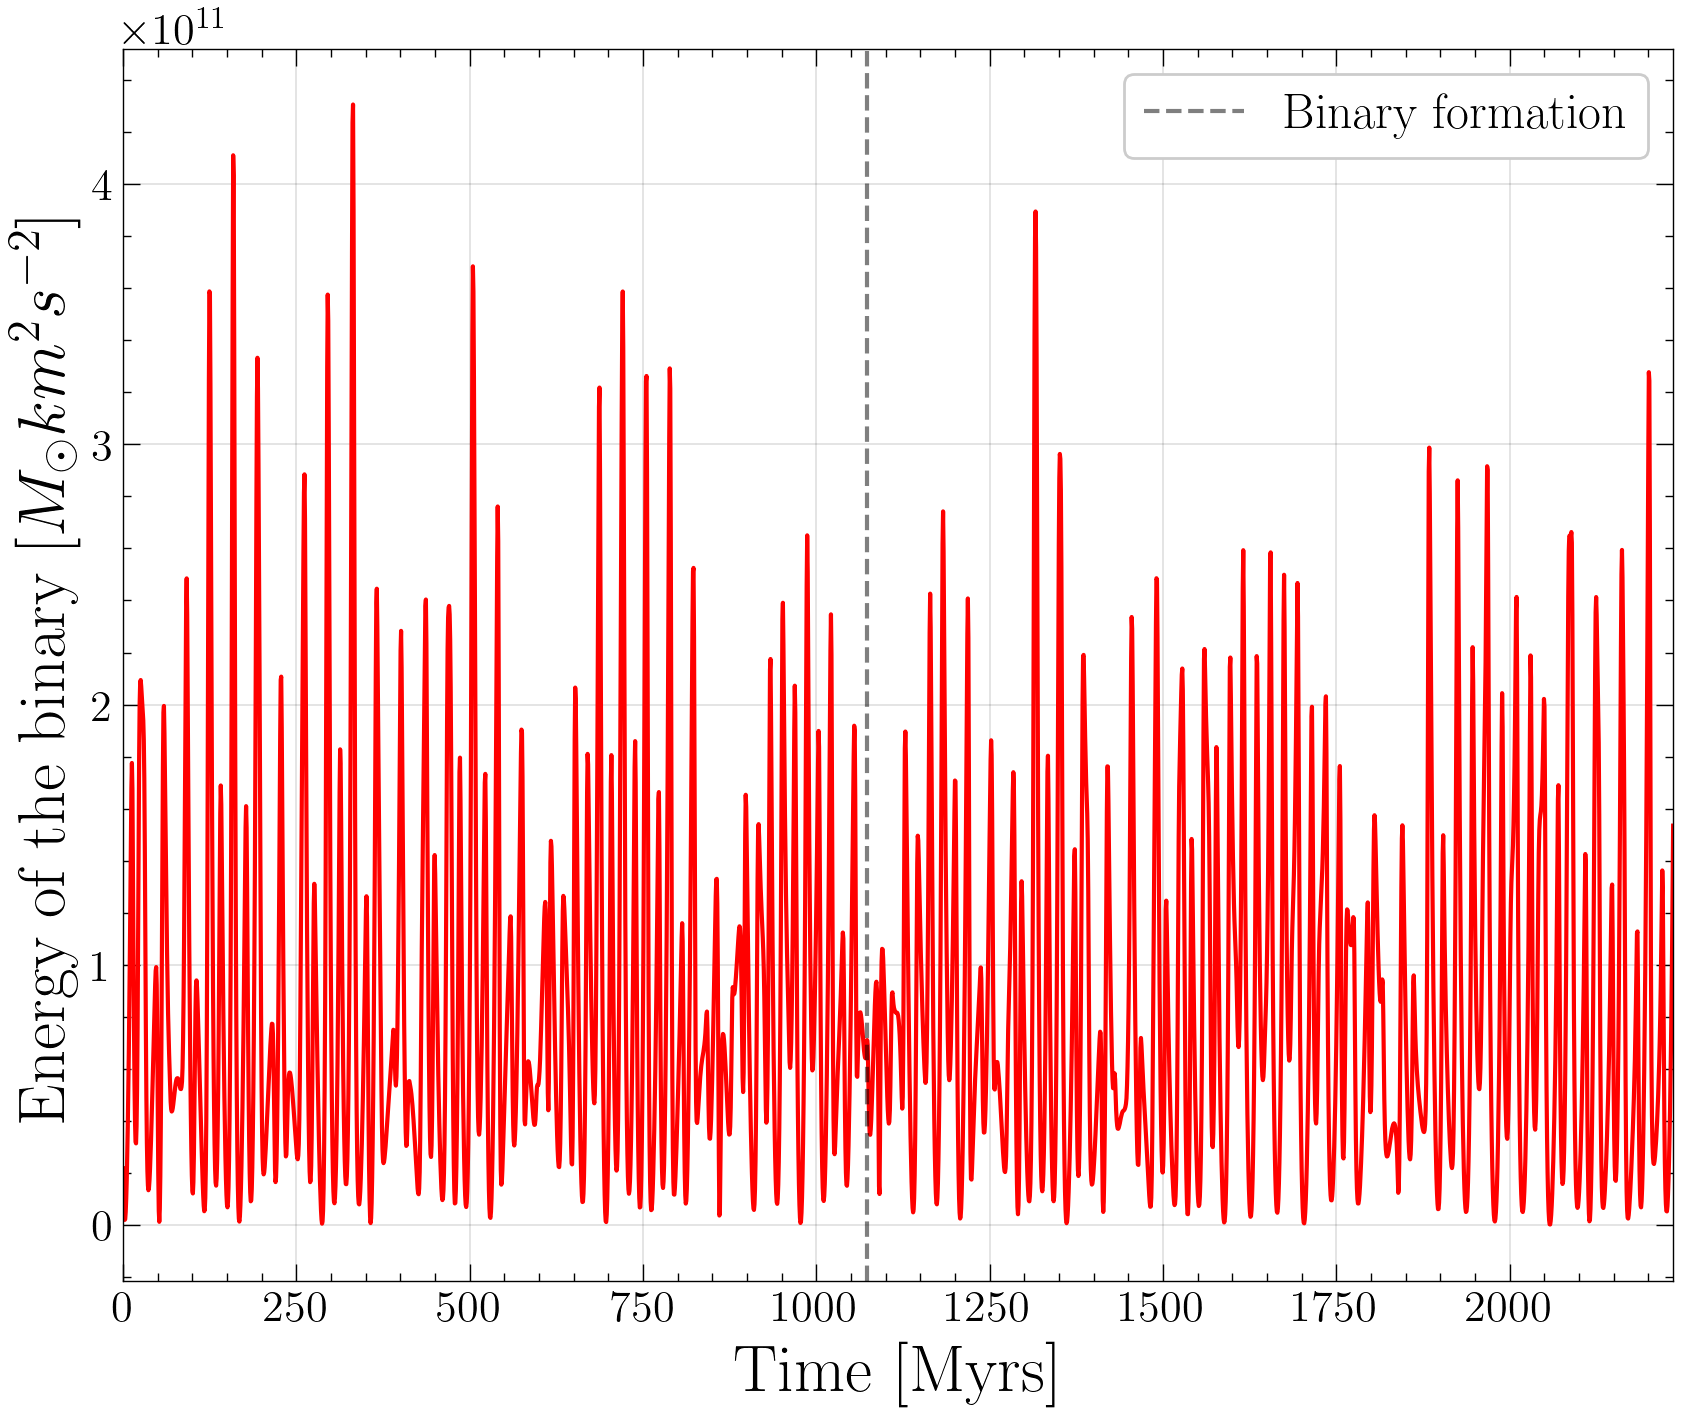

In [34]:
E_binary = 0.5*M_mbh*np.linalg.norm(v_CMbinary_mbh1, axis=0)**2 + 0.5*M_mbh*np.linalg.norm(v_CMbinary_mbh2, axis=0)**2 - G_pu*M_mbh**2/dist_mbhs
index_binary_formation = 1440 #np.where(np.diff(np.sign(E_binary)))[0][-1]

plt.plot(time, E_binary, color='red')
plt.axvline(time[index_binary_formation], ls='--', color='black', alpha=0.5, label='Binary formation')
plt.xlim(0, time[-1])
plt.xlabel('Time [Myrs]')
plt.ylabel('Energy of the binary $[M_\odot km^2 s^{-2}]$')
plt.legend();

In [35]:
r_crit = dist_mbhs[index_binary_formation]
print(f'The critical radius for the binary is: {r_crit:.2f} pc')

The critical radius for the binary is: 3604.38 pc


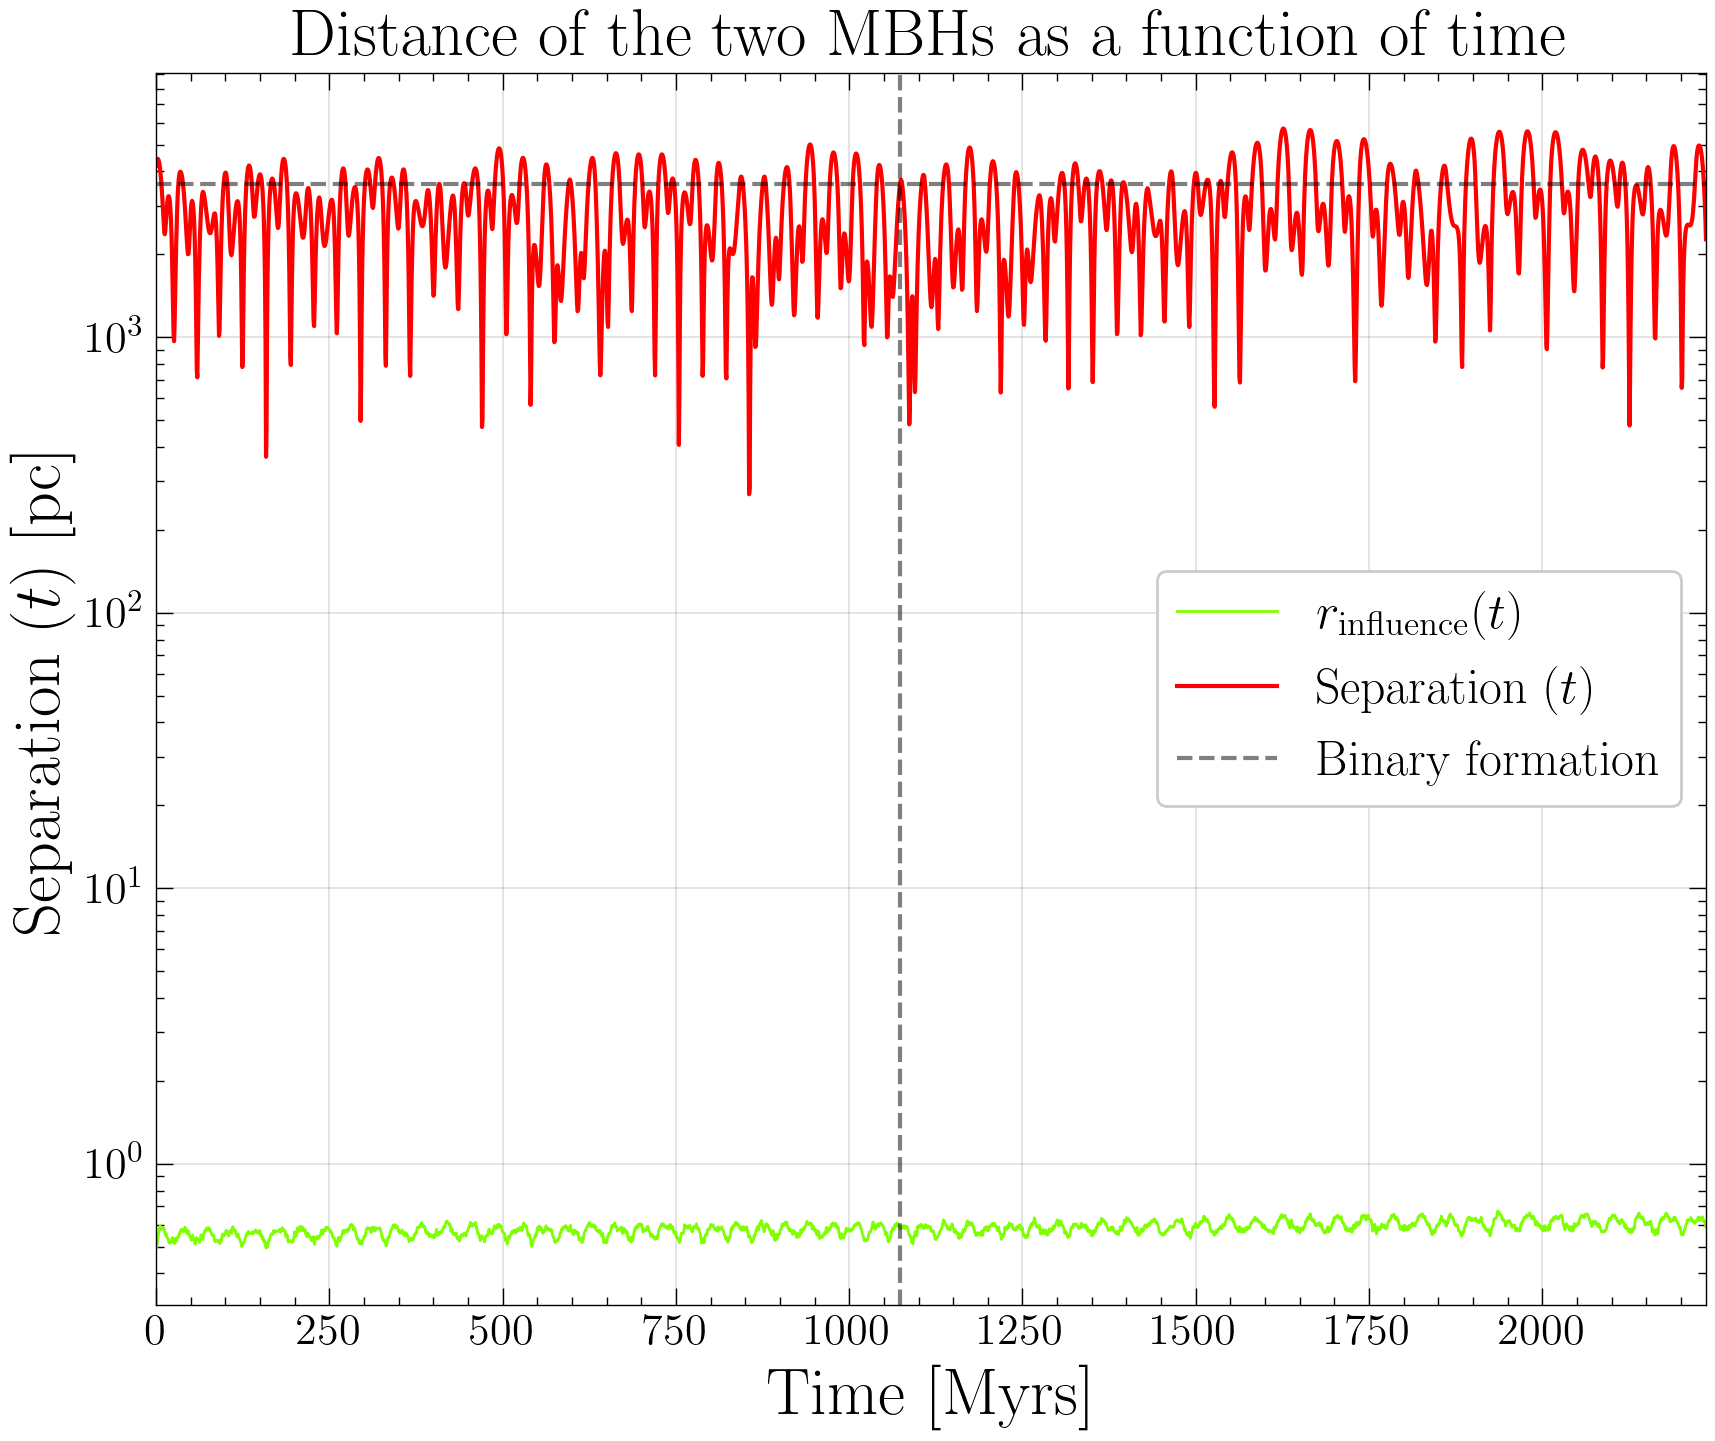

In [36]:
plt.plot(time, r_influence, color='chartreuse', lw=1, label='$r_{\\text{influence}}(t)$')
plt.plot(time, dist_mbhs, color='red', label='Separation $(t)$')
plt.axvline(time[index_binary_formation], ls='--', color='black', alpha=0.5, label='Binary formation')
plt.axhline(r_crit, ls='--', color='black', alpha=0.5)
plt.xlim(0, time[-1])
plt.yscale('log')
plt.title('Distance of the two MBHs as a function of time')
plt.xlabel('Time [Myrs]')
plt.ylabel('Separation $(t)$ [pc]')
plt.legend();

In [37]:
def Rotate_Frame(pos_CMbinary_mbh1, pos_CMbinary_mbh2, v_CMbinary_mbh1, v_CMbinary_mbh2):
    # Define the relative position and velocity vectors
    r_rel = pos_CMbinary_mbh1 - pos_CMbinary_mbh2 # shape [3, N]      
    v_rel = v_CMbinary_mbh1 - v_CMbinary_mbh2  


    # Define the versors in the frame of the binary
    angmom_rel = np.cross(r_rel.T, v_rel.T).T
    z_BF_hat = angmom_rel/np.linalg.norm(angmom_rel, axis=0)

    x_BF_hat = np.tile(r_rel[:,0]/np.linalg.norm(r_rel[:,0], axis=0), (pos_CMbinary_mbh1.shape[1], 1)).T

    y_BF_hat = np.cross(z_BF_hat.T, x_BF_hat.T).T
    y_BF_hat = y_BF_hat/np.linalg.norm(y_BF_hat, axis=0)

    x_BF_hat = np.cross(y_BF_hat.T, z_BF_hat.T).T #re-orthogonalize x_BF_hat


    # Define the transformation matrix
    Rot = np.stack([x_BF_hat, y_BF_hat, z_BF_hat], axis=1)  # shape [3, 3, N]


    # Apply the transformation to the position and velocity vectors
    pos_BF_mbh1 = np.zeros_like(pos_CMbinary_mbh1)
    pos_BF_mbh2 = np.zeros_like(pos_CMbinary_mbh2)
    v_BF_mbh1 = np.zeros_like(v_CMbinary_mbh1)
    v_BF_mbh2 = np.zeros_like(v_CMbinary_mbh2)

    for i in range(len(time)):
        pos_BF_mbh1[:, i] = Rot[:, :, i].T @ pos_CMbinary_mbh1[:, i]
        pos_BF_mbh2[:, i] = Rot[:, :, i].T @ pos_CMbinary_mbh2[:, i]
        v_BF_mbh1[:, i] = Rot[:, :, i].T @ v_CMbinary_mbh1[:, i]
        v_BF_mbh2[:, i] = Rot[:, :, i].T @ v_CMbinary_mbh2[:, i]
        
    return pos_BF_mbh1, pos_BF_mbh2, v_BF_mbh1, v_BF_mbh2

pos_BF_mbh1, pos_BF_mbh2, v_BF_mbh1, v_BF_mbh2 = Rotate_Frame(pos_CMbinary_mbh1, pos_CMbinary_mbh2, v_CMbinary_mbh1, v_CMbinary_mbh2)

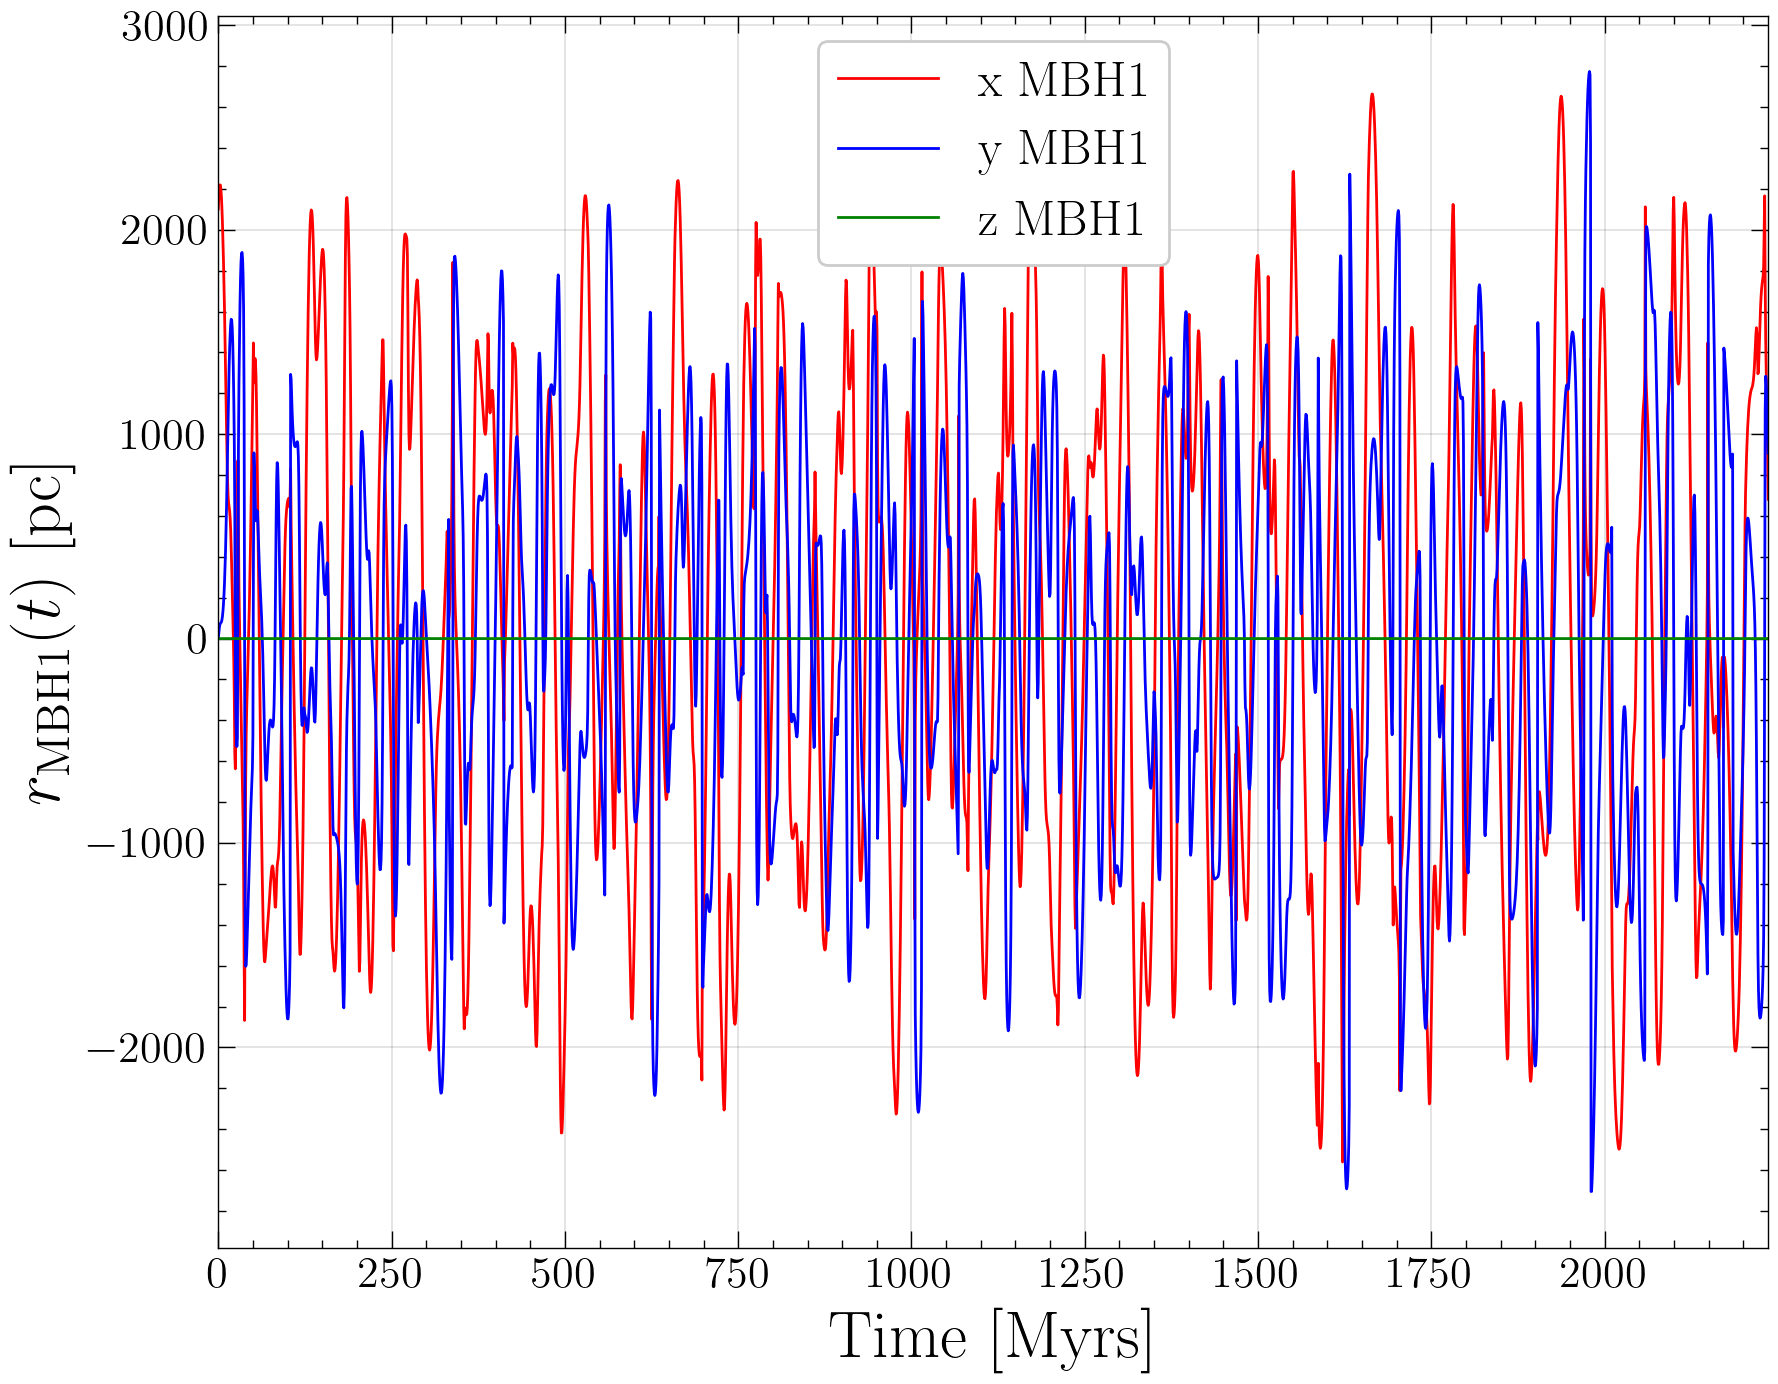

In [38]:
plt.plot(time, pos_BF_mbh1[0], color='red', lw=1, label='x MBH1')
plt.plot(time, pos_BF_mbh1[1], color='blue', lw=1, label='y MBH1')
plt.plot(time, pos_BF_mbh1[2], color='green', lw=1, label='z MBH1')
plt.xlim(0, time[-1])
plt.xlabel('Time [Myrs]')
plt.ylabel('$r_{\\rm{MBH1}} (t)$ [pc]')
plt.legend();

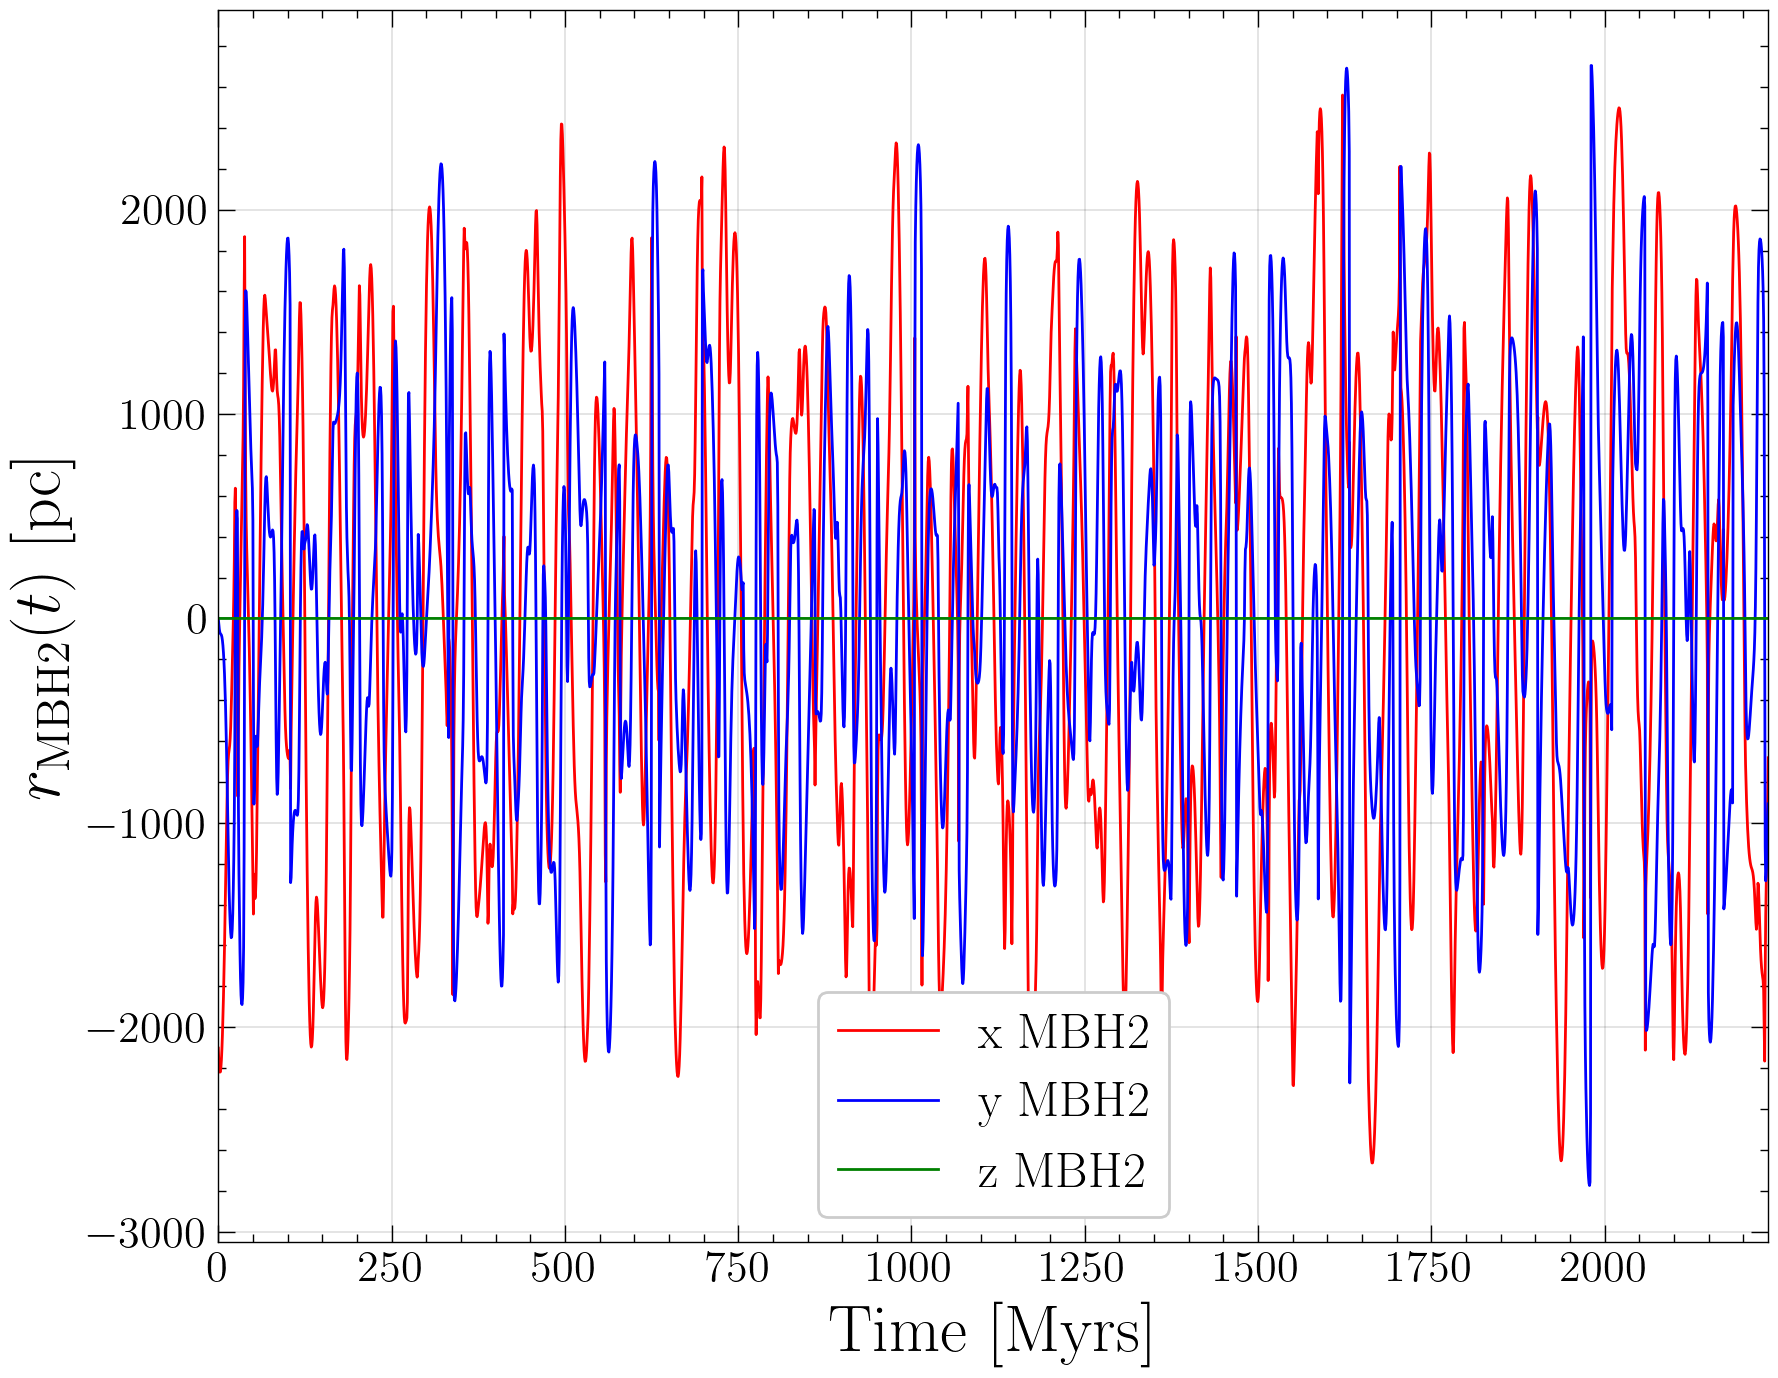

In [39]:
plt.plot(time, pos_BF_mbh2[0], color='red', lw=1, label='x MBH2')
plt.plot(time, pos_BF_mbh2[1], color='blue', lw=1, label='y MBH2')
plt.plot(time, pos_BF_mbh2[2], color='green', lw=1, label='z MBH2')
plt.xlim(0, time[-1])
plt.xlabel('Time [Myrs]')
plt.ylabel('$r_{\\rm{MBH2}} (t)$ [pc]')
plt.legend();

Now, we want to define the Laplace-Runge-Lenz (LRL) vector, which is aligned to the major axis

$\vec{LRL} = \vec{v_\text{rel}} \times \vec{L_\text{rel}} - GM \dfrac{\vec{r_\text{rel}}}{|\vec{r_\text{rel}}|}$

In [40]:
#LRL = np.cross(v_rel.T, angmom_rel.T).T - (M_mbh+M_mbh) * (r_rel / np.linalg.norm(r_rel, axis=0))
#
## x_BF is the normalized LRL vector (major axis)
#x_BF_hat = LRL / np.linalg.norm(LRL, axis=0)
#
## y_BF is perpendicular to both z and x (minor axis)
#y_BF_hat = np.cross(z_BF_hat.T, x_BF_hat.T).T
#y_BF_hat = y_BF_hat / np.linalg.norm(y_BF_hat, axis=0)
#
## Re-orthogonalize x_BF just to be safe
#x_BF_hat = np.cross(y_BF_hat.T, z_BF_hat.T).T
#
## Stack rotation matrix
#Rot = np.stack([x_BF_hat, y_BF_hat, z_BF_hat], axis=1)  # shape [3, 3, N]
#
## Apply transformation
#for i in range(len(time)):
#    pos_BF_mbh1[:, i] = Rot[:, :, i].T @ pos_CMbinary_mbh1[:, i]
#    pos_BF_mbh2[:, i] = Rot[:, :, i].T @ pos_CMbinary_mbh2[:, i]
#    v_BF_mbh1[:, i] = Rot[:, :, i].T @ v_CMbinary_mbh1[:, i]
#    v_BF_mbh2[:, i] = Rot[:, :, i].T @ v_CMbinary_mbh2[:, i]
#    
#    
#plt.plot(time, pos_BF_mbh1[0], color='red', lw=1, label='x MBH1')
#plt.plot(time, pos_BF_mbh1[1], color='blue', lw=1, label='y MBH1')
#plt.plot(time, pos_BF_mbh1[2], color='green', lw=1, label='z MBH1')
#plt.xlim(time[4000], time[4100])
#plt.ylim(-0.01, 0.001)
#plt.legend();

# Dynamical friction formula (only for Singular Isothermal Sphere)

In general, dynamical friction produces an acceleration that is given by Chandrasekhar's formula:

$$\dfrac{d\vec{v}_M}{dt} \, = \, -16 \pi^2 G^2 m \left(m+M\right) \ln \Lambda \left[\int^{v_M}_0 f(v_m) v_m^2 dv_m\right] \dfrac{\vec{v}_M}{v_M^3} \:\:,$$ 
where $M$ stands for the perturber and $m$ for a general background particle.\
$\ln \Lambda$ is a number called "Coulomb logarithm" and it can be safely approximated with $\approx 5-10$.

In the particular case of a singular isothermal sphere, this expression can be greatly simplified:

$$\dfrac{d\vec{v}_M}{dt} \, \simeq \, -0.428 \times 2 \pi G^2 n m M \ln \Lambda \dfrac{\hat{v}_M}{\sigma^2} \:\:,$$
where $n$ is the number density of particles around the perturber.

## Acceleration computed from the data

In [41]:
v_mbh1_vector = np.array([vx[-1], vy[-1], vz[-1]])
v_mbh2_vector = np.array([vx[-2], vy[-2], vz[-2]])

a_mbh1_vector = np.diff(v_mbh1_vector)/np.diff(time)
a_mbh1_vector = np.hstack([a_mbh1_vector, np.array([a_mbh1_vector[:,-1]]).T]) # to have the same length as time

a_mbh2_vector = np.diff(v_mbh2_vector)/np.diff(time)
a_mbh2_vector = np.hstack([a_mbh2_vector, np.array([a_mbh2_vector[:,-1]]).T])

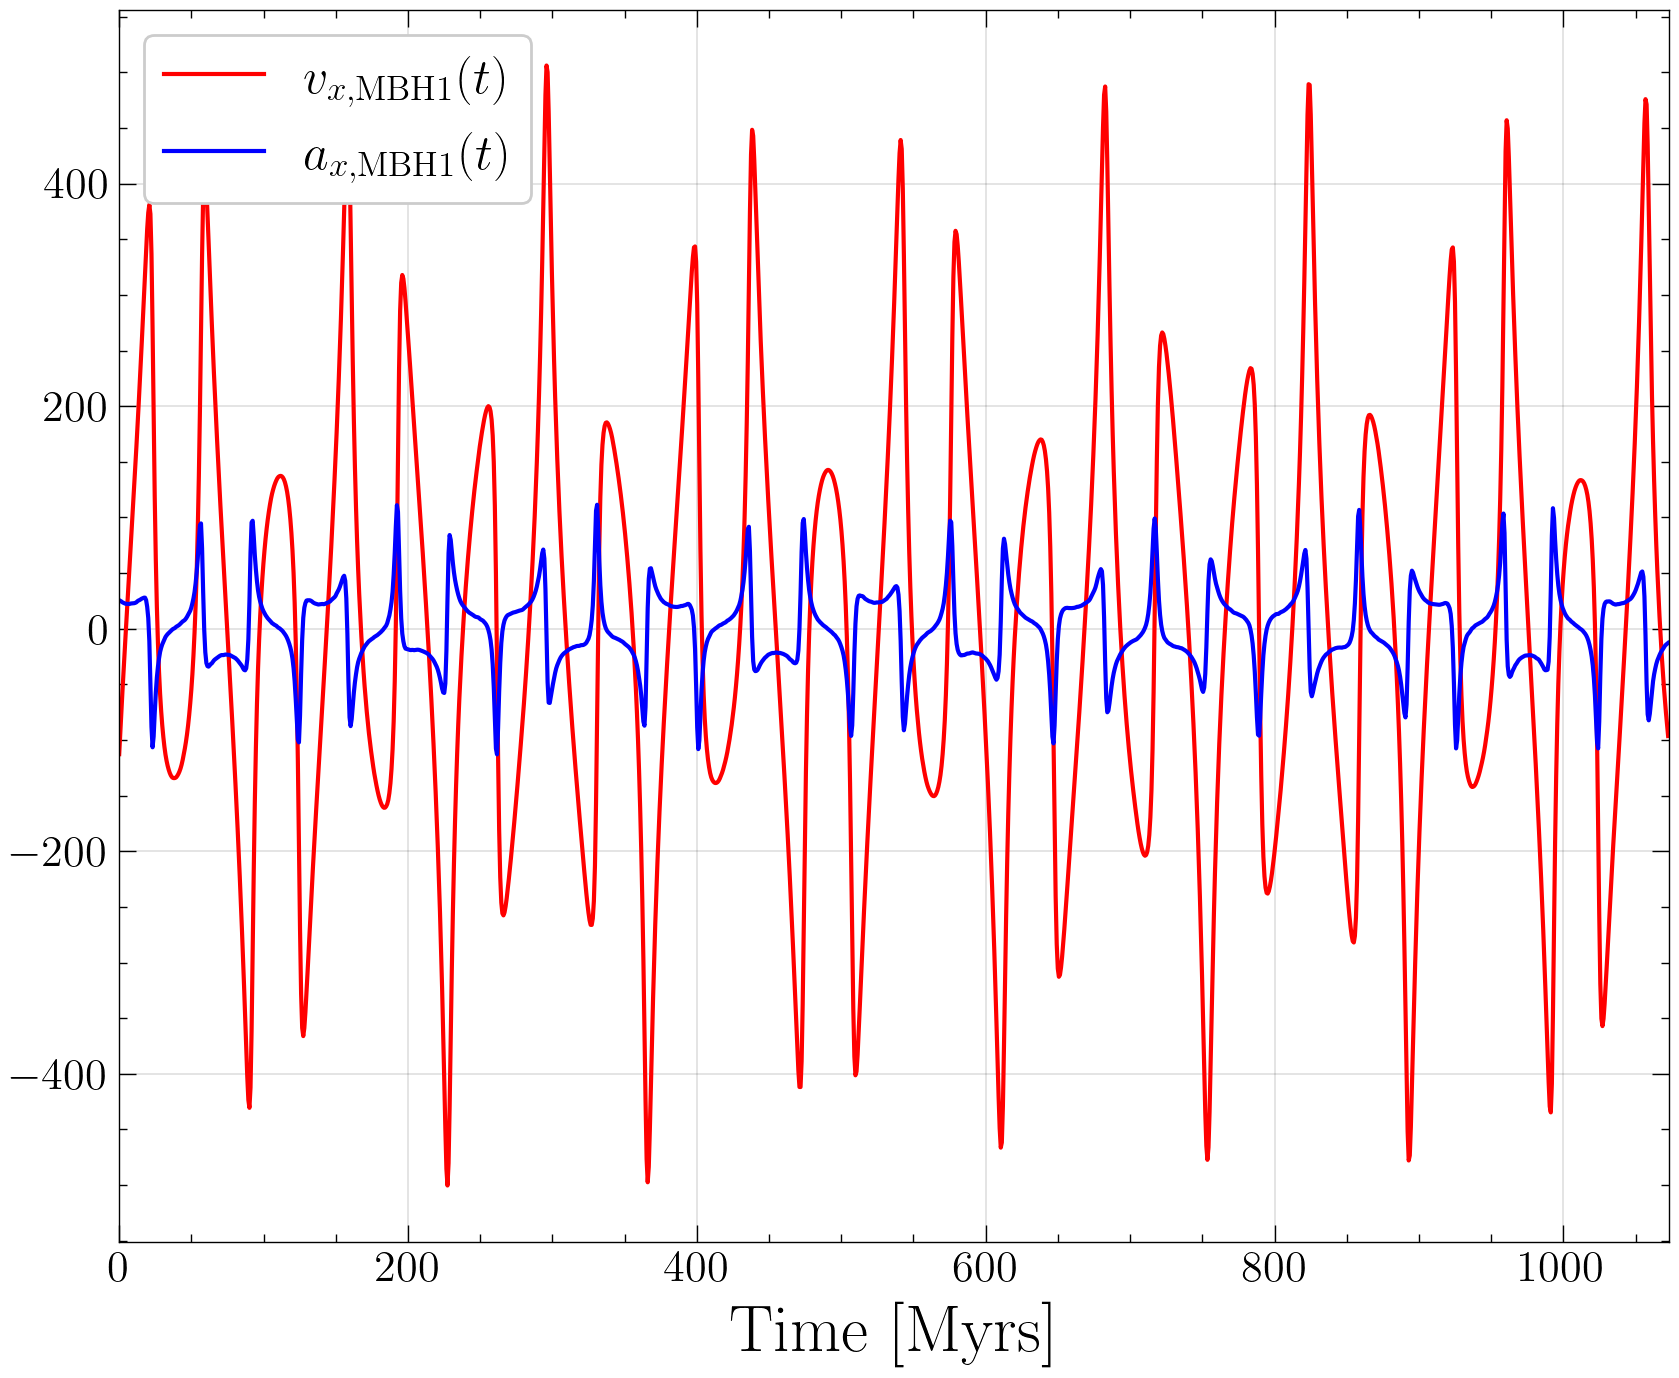

In [42]:
plt.plot(time[:index_binary_formation], v_mbh1_vector[0,:index_binary_formation], color='red', label='$v_{x,\\rm{MBH1}}(t)$')
plt.plot(time[:index_binary_formation], a_mbh1_vector[0,:index_binary_formation], color='blue', label='$a_{x,\\rm{MBH1}}(t)$')
plt.xlim(0, time[index_binary_formation])
plt.xlabel('Time [Myrs]')
plt.legend();

So far we computed the total acceleration of the black holes, which includes also the centripetal acceleration of Keplerian motion.\
We have to remove this in order to isolate the dynamical-friction component.

$\vec{a}_\text{Kepler} \, = \, - \dfrac{G M(r_\text{MBH})}{r_\text{MBH}^3} \vec{r}_\text{MBH}$

In [43]:
def Inner_Mass(dist_particle, time, dist_mbh):
    inner_particles = np.zeros(len(time))
    
    for i in tqdm(range(len(time))):
        mask = dist_particle[:,i]<dist_mbh[i]
        inner_particles[i] = np.sum(mask)
        
    return inner_particles * m_particle

inner_mass_mbh1 = Inner_Mass(dist_particle, time, dist_mbh1)
inner_mass_mbh2 = Inner_Mass(dist_particle, time, dist_mbh2)

100%|██████████| 3001/3001 [00:00<00:00, 26375.18it/s]


In [44]:
r_mbh1_vector = np.array([x[-1], y[-1], z[-1]])
r_mbh2_vector = np.array([x[-2], y[-2], z[-2]])

a_kepler_mbh1 = -G_pu*inner_mass_mbh1*r_mbh1_vector/dist_mbh1**3
a_kepler_mbh2 = -G_pu*inner_mass_mbh2*r_mbh2_vector/dist_mbh2**3

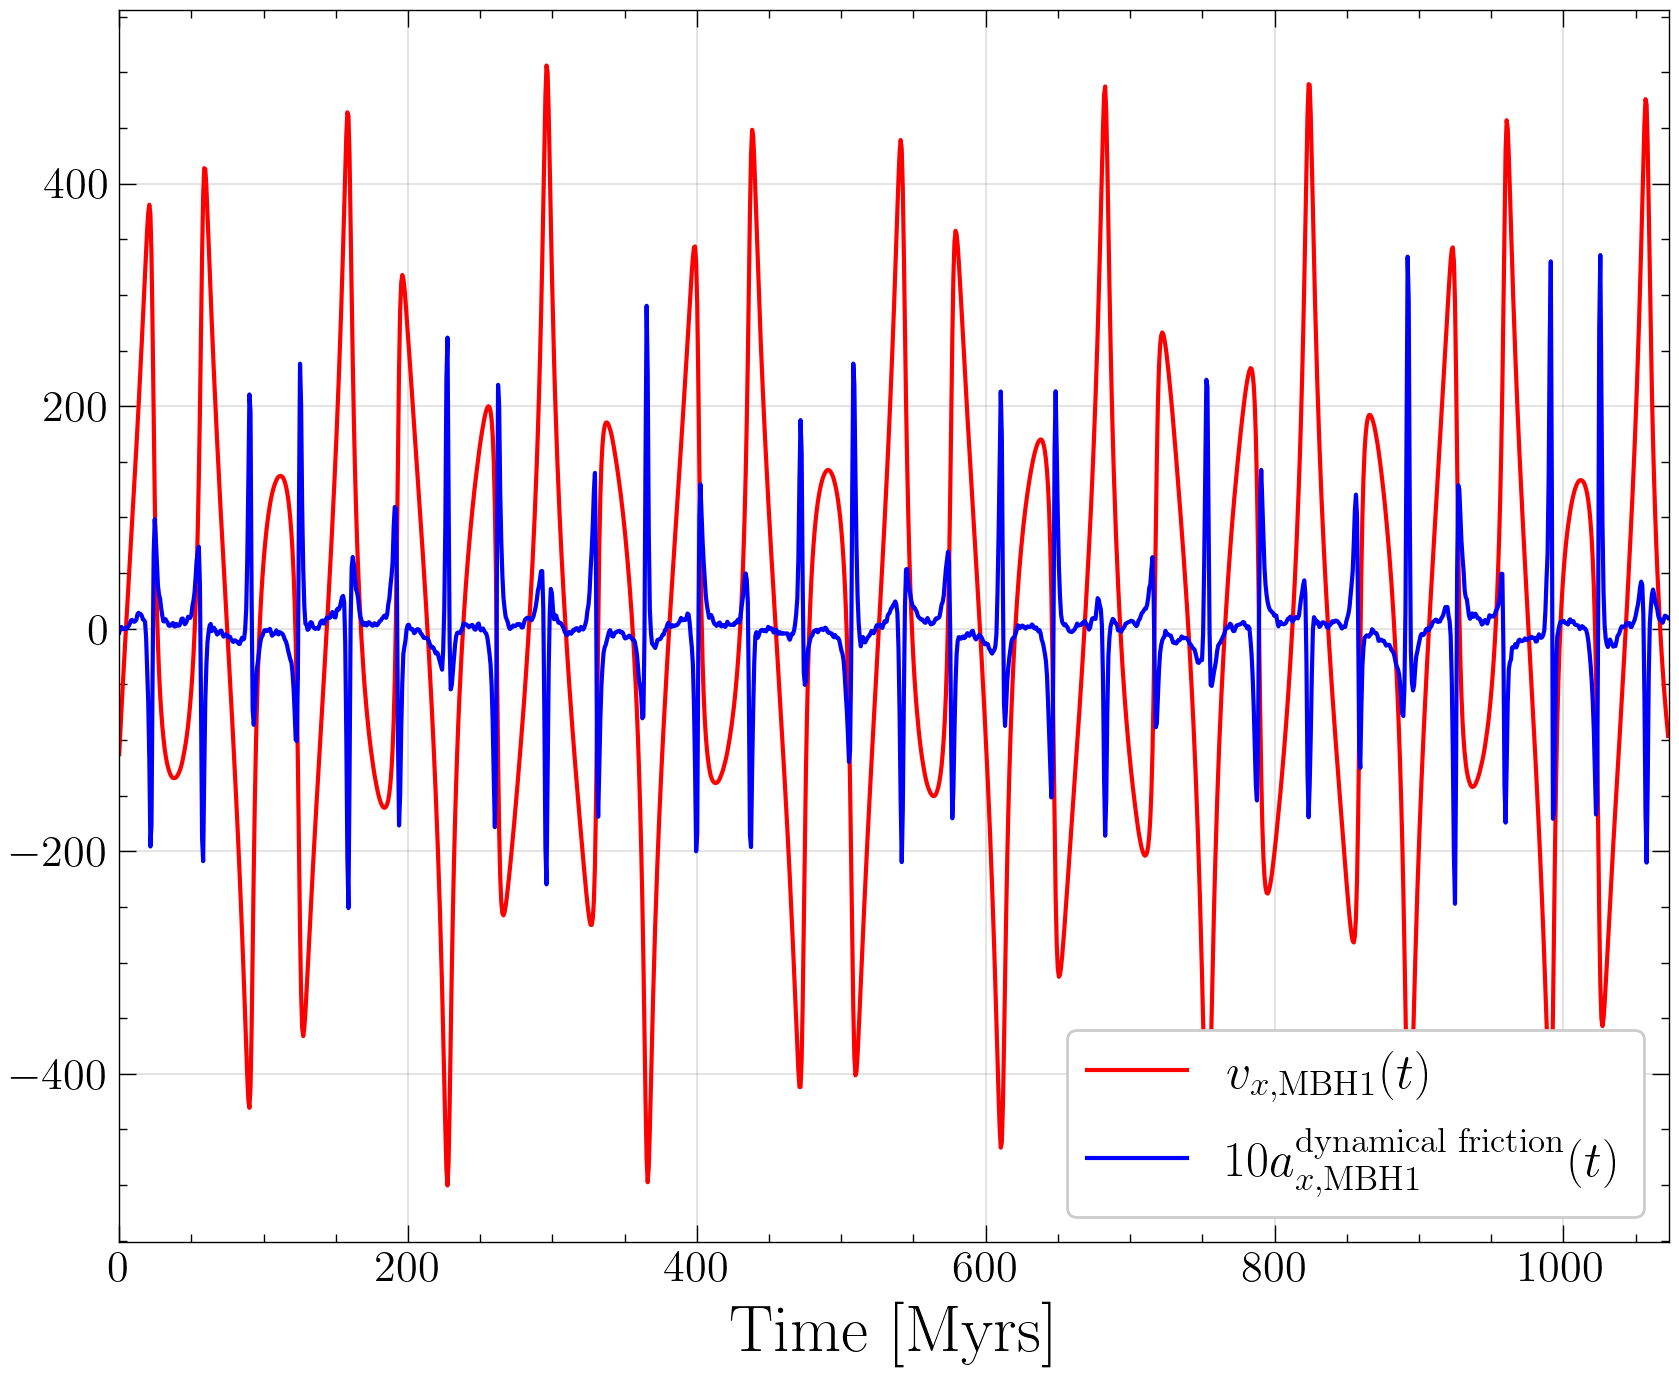

In [45]:
a_DF_mbh1 = a_mbh1_vector - a_kepler_mbh1
a_DF_mbh2 = a_mbh2_vector - a_kepler_mbh2

plt.plot(time[:index_binary_formation], v_mbh1_vector[0,:index_binary_formation], color='red', label='$v_{x,\\rm{MBH1}}(t)$')
plt.plot(time[:index_binary_formation], 10*a_DF_mbh1[0,:index_binary_formation], color='blue', label='$10a_{x,\\rm{MBH1}}^\\text{dynamical friction}(t)$')
plt.xlim(0, time[index_binary_formation])
plt.xlabel('Time [Myrs]')
plt.legend();

## Acceleration computed from the dynamical friction formula

We have already computed the number density around the black holes at each time step

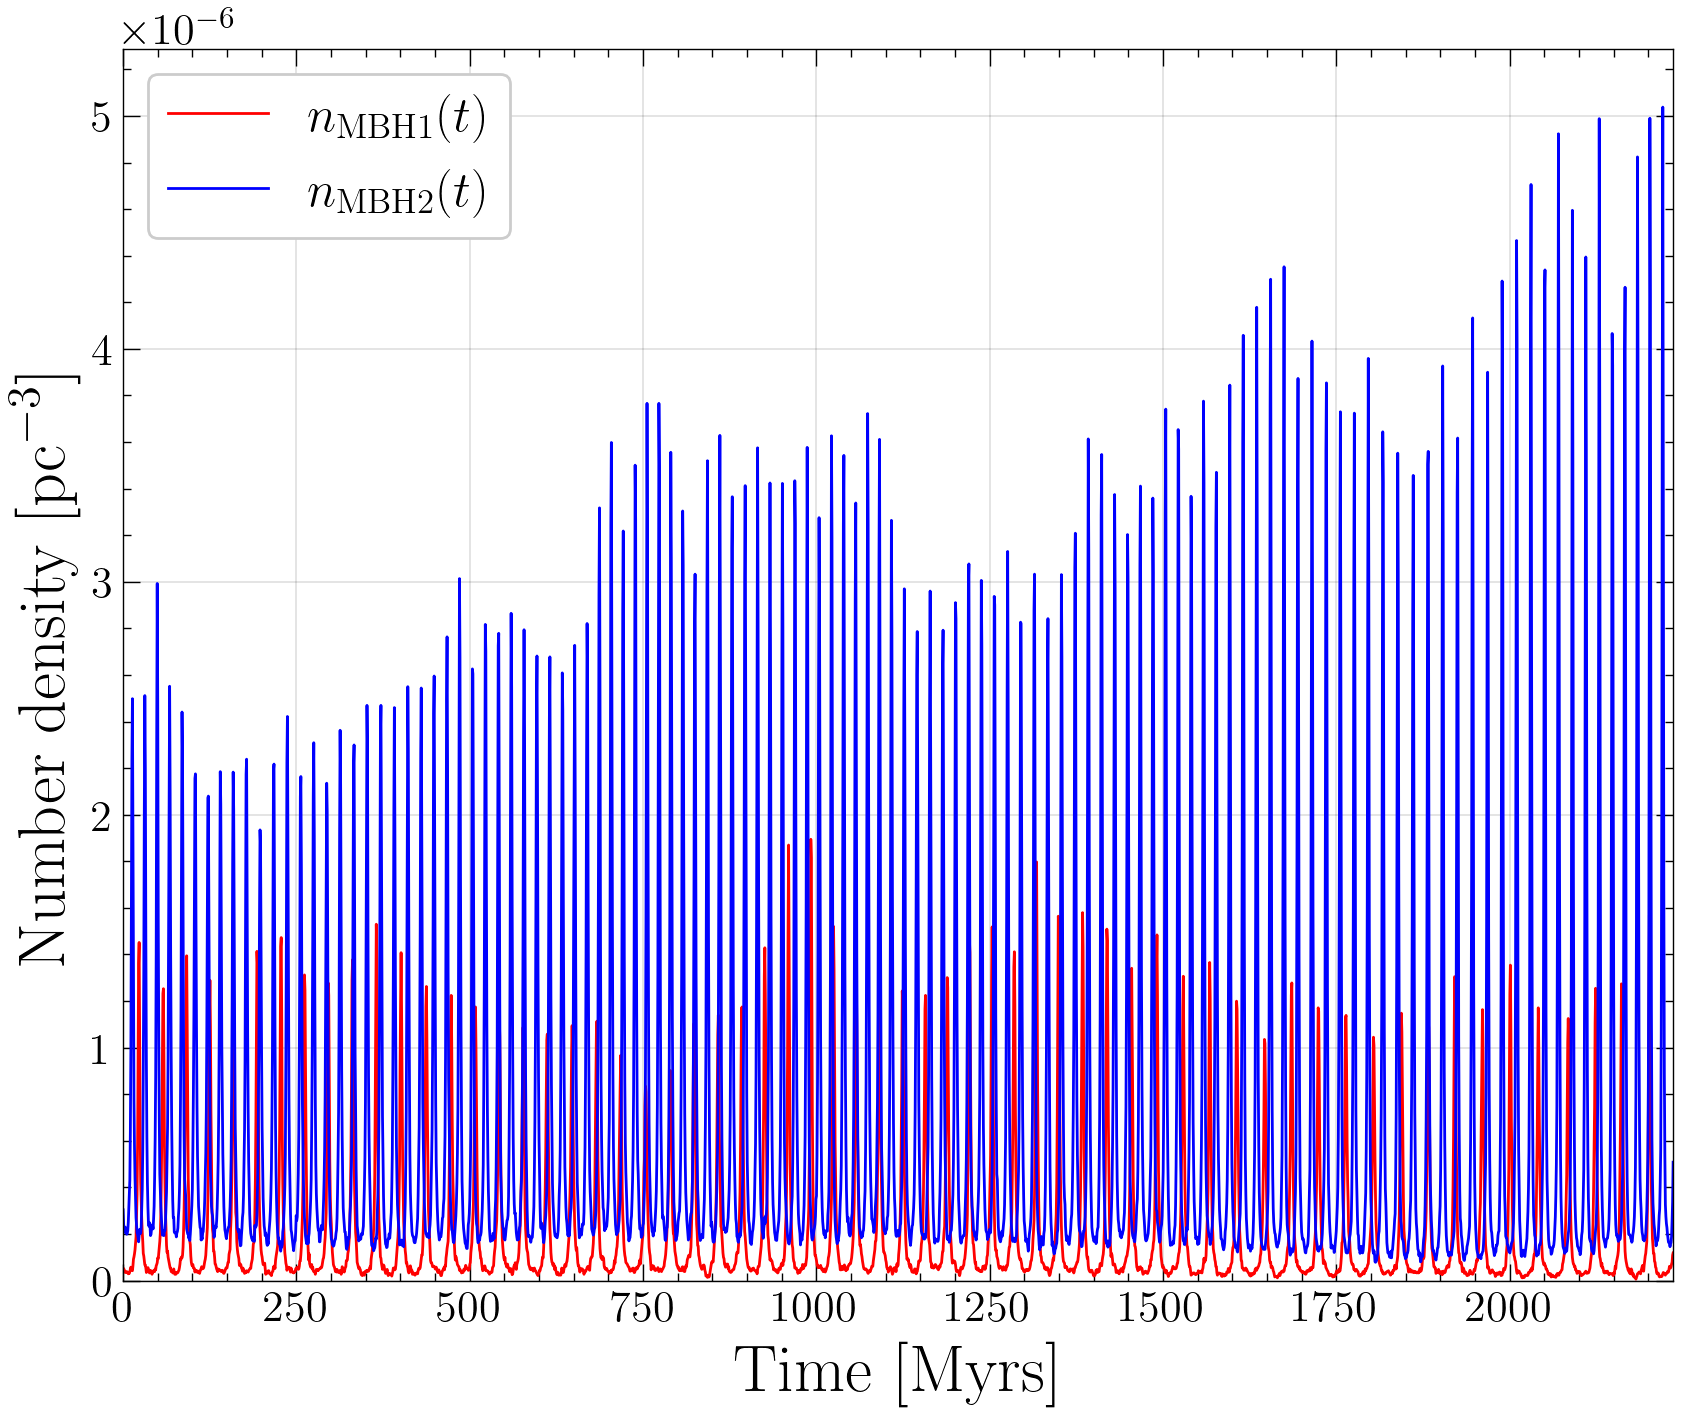

In [46]:
plt.plot(time, number_density_mbh1, color='red', lw=1, label='$n_{\\rm{MBH1}}(t)$')
plt.plot(time, number_density_mbh2, color='blue', lw=1, label='$n_{\\rm{MBH2}}(t)$')
plt.xlim(0, time[-1])
plt.ylim(0)
plt.xlabel('Time [Myrs]')
plt.ylabel('Number density [pc$^{-3}$]')
plt.legend();

We only have to apply the formula, assuming $\ln \Lambda = 5$

In [47]:
# sqrt(pc^2 km^4 M_sun^-2 s^-4)  -->  sqrt(pc^3 km^3 M_sun^-2 s^-4)
G_pu_primed = G_pu*np.sqrt(1e5/(3.08567758128e18))
# sqrt(pc^3 km^3 M_sun^-2 s^-4)  -->  sqrt(pc^3 km^3 M_sun^-2 s^-3 Myrs-1)
G_pu_primed = G_pu_primed*np.sqrt(1e6*(3.156e7))

ln_lambda = 5
Constant = -0.428*2*np.pi*G_pu_primed**2*m_particle*M_mbh*ln_lambda
a_mbh1_expected = Constant*number_density_mbh1*(v_mbh1_vector/v_mbh1)/(sigma_mbh1**2)
a_mbh2_expected = Constant*number_density_mbh2*(v_mbh2_vector/v_mbh2)/(sigma_mbh2**2)

del v_mbh1_vector, v_mbh2_vector, a_mbh1_vector, a_mbh2_vector, inner_mass_mbh1, inner_mass_mbh2, r_mbh1_vector, r_mbh2_vector, a_kepler_mbh1, a_kepler_mbh2

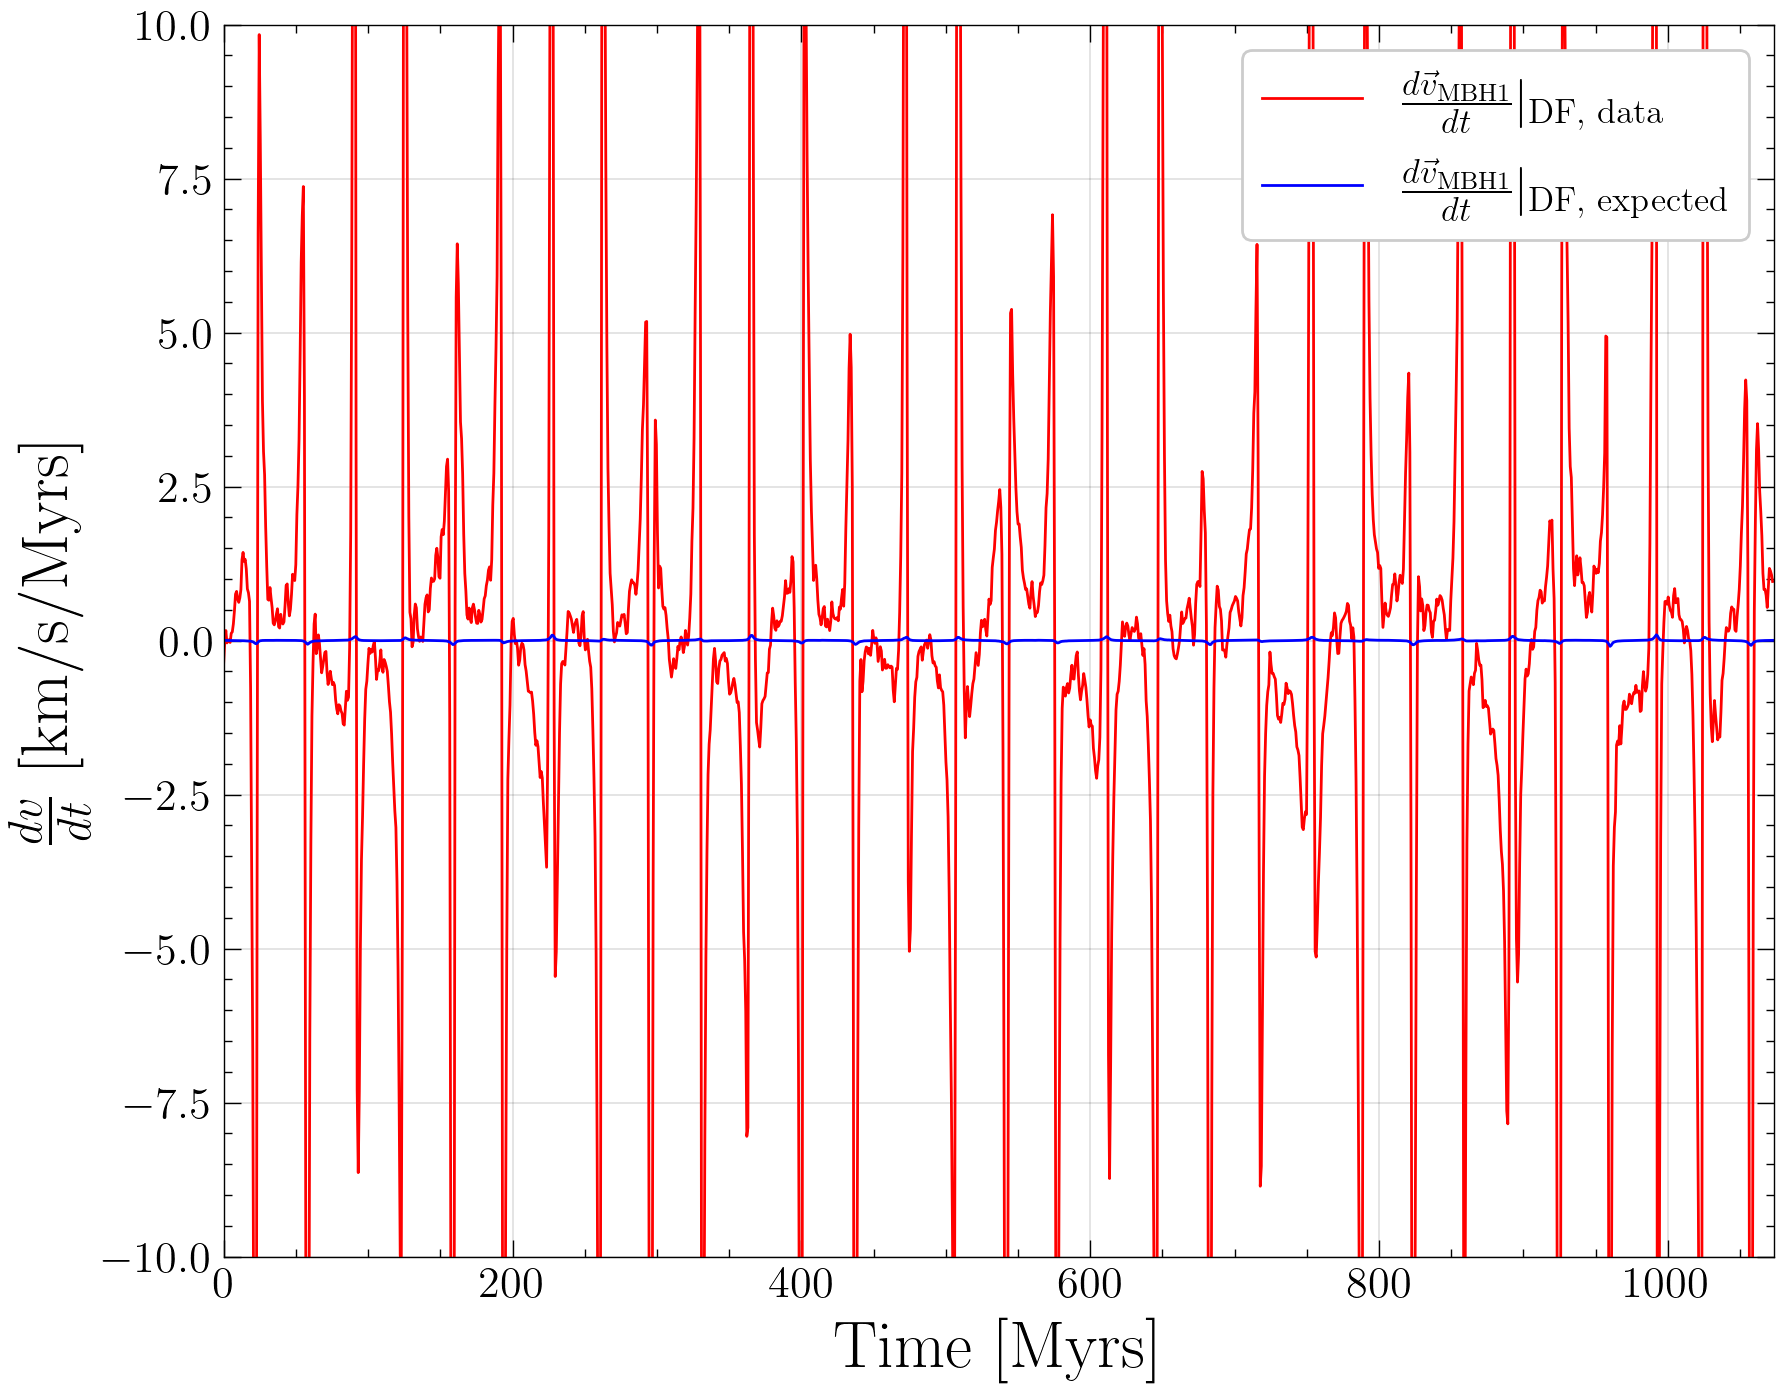

In [48]:
coord_index = 0
plt.plot(time[:index_binary_formation], a_DF_mbh1[coord_index, :index_binary_formation], color='red', lw=1, label='$\\frac{d\\vec{v}_{\\rm{MBH1}}}{dt} |_\\text{DF, data}$')
plt.plot(time[:index_binary_formation], a_mbh1_expected[coord_index, :index_binary_formation], color='blue', lw=1, label='$\\frac{d\\vec{v}_{\\rm{MBH1}}}{dt} |_\\text{DF, expected}$')
plt.xlim(0, time[index_binary_formation])
plt.ylim(-10, 10)
plt.xlabel('Time [Myrs]')
plt.ylabel('$\\frac{d v}{dt}$ [km/s/Myrs]')
plt.legend();

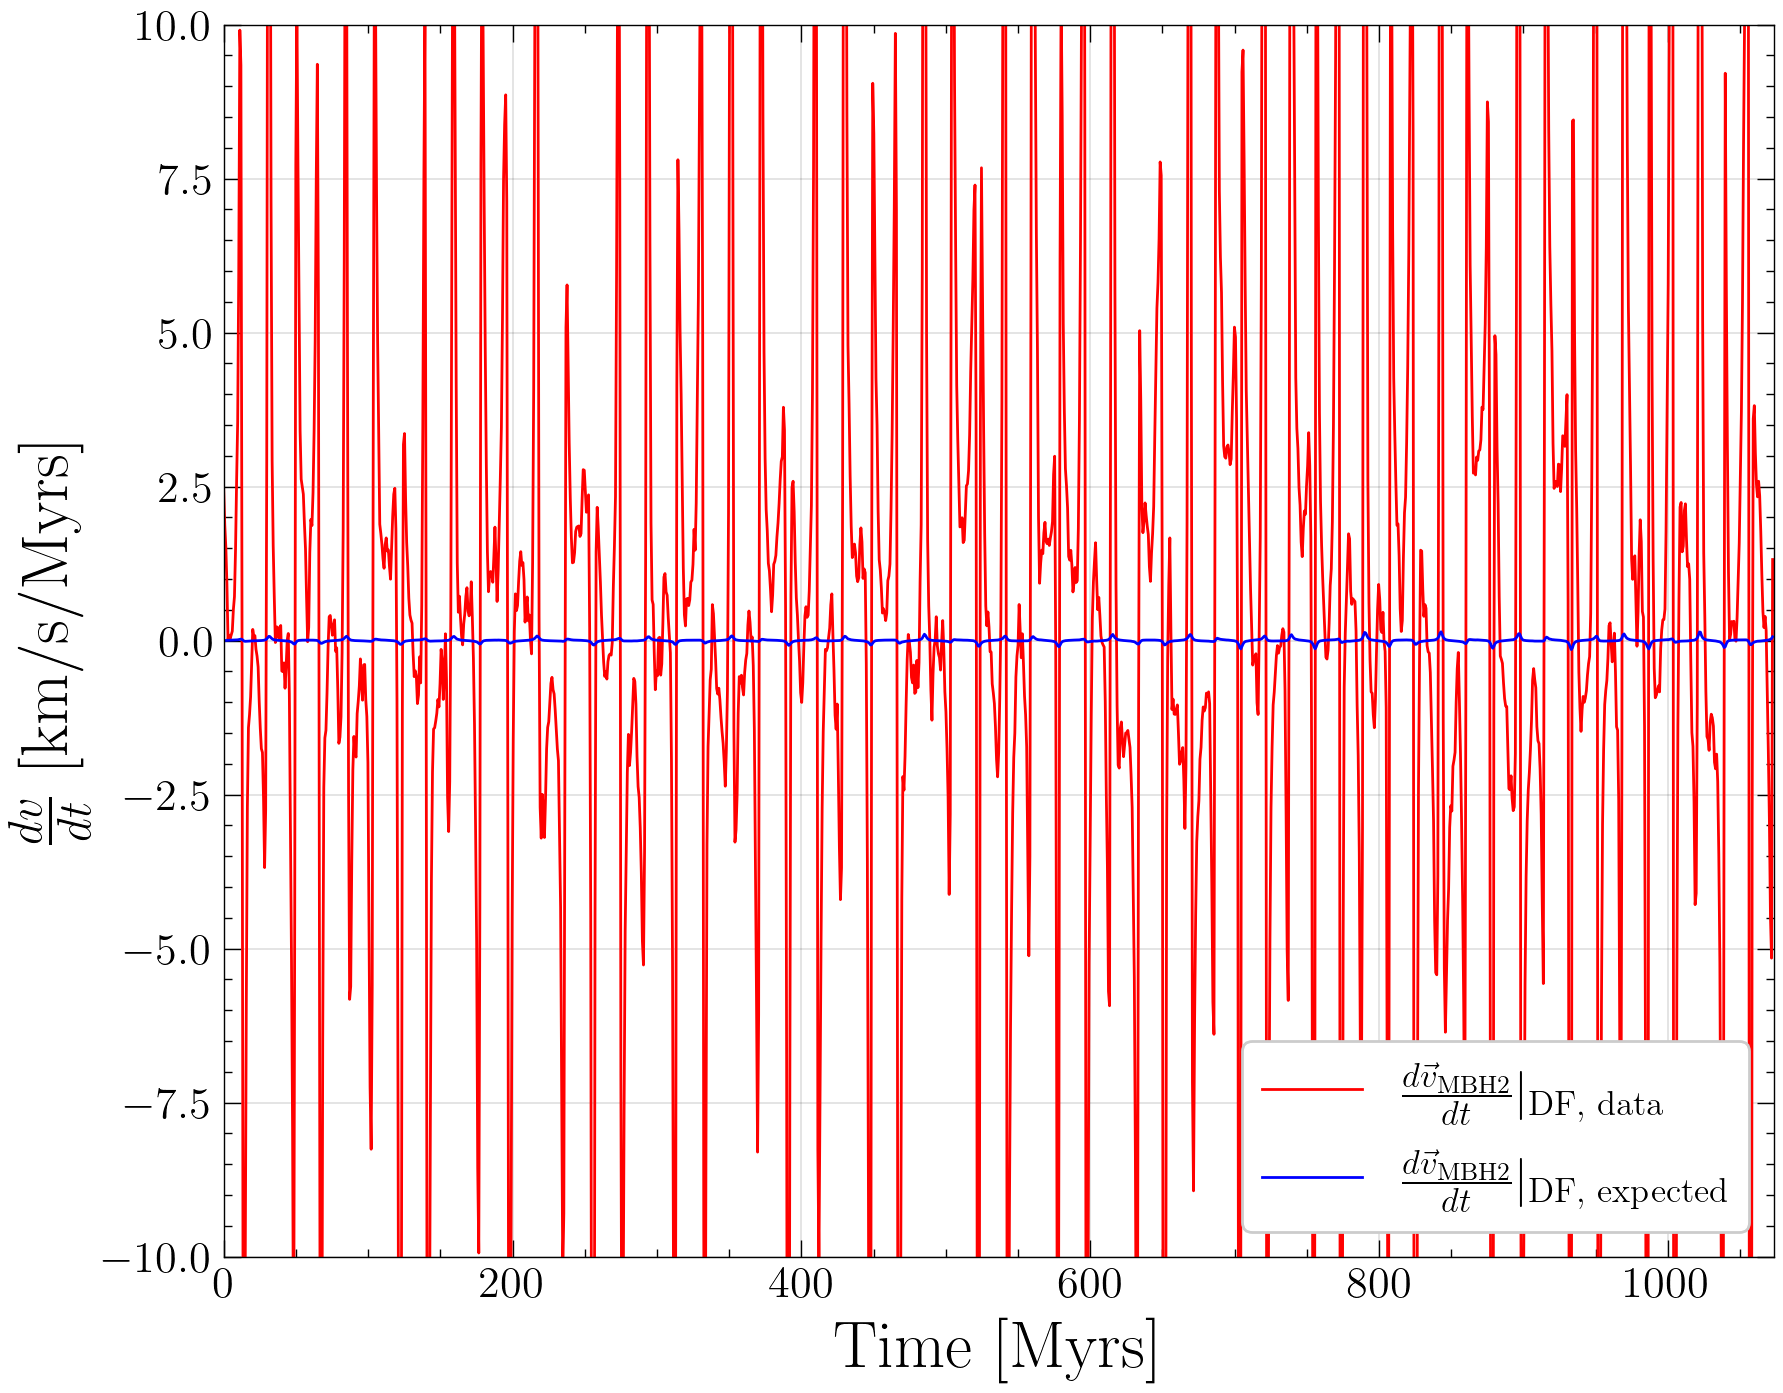

In [49]:
coord_index = 0
plt.plot(time[:index_binary_formation], a_DF_mbh2[coord_index, :index_binary_formation], color='red', lw=1, label='$\\frac{d\\vec{v}_{\\rm{MBH2}}}{dt} |_\\text{DF, data}$')
plt.plot(time[:index_binary_formation], a_mbh2_expected[coord_index, :index_binary_formation], color='blue', lw=1, label='$\\frac{d\\vec{v}_{\\rm{MBH2}}}{dt} |_\\text{DF, expected}$')
plt.xlim(0, time[index_binary_formation])
plt.ylim(-10, 10)
plt.xlabel('Time [Myrs]')
plt.ylabel('$\\frac{d v}{dt}$ [km/s/Myrs]')
plt.legend();

# Animation: 2D-histogram

In [50]:
animate_2Dhist = False
if animate_2Dhist:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    nframes = int(len(time)/k)
    
    # Define the binning
    nbins = int(20*np.log10(N))
    bins = np.linspace(-dist_plotlimits, dist_plotlimits, nbins)
    
    # Define the figure
    fig, axes = plt.subplots(1, 3, figsize=(22, 7))
    title = fig.suptitle(f'${N}$ particles , $M = {M:.0e} M_\odot$ , $M_{{\\text{{MBHs}}}} = {M_mbh:.0e} M_\odot$ , $\\theta = {theta:.2f}$ , $eps = {eps:.2f}$ , \n $t = {time[0]:.0f}$ Myrs', fontsize=25, y=0.95)
    
    # Colorbar
    hist = ax.hist2d(x[:, 0], y[:, 0], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet, alpha=0)
    cax = fig.add_axes([0.91, 0.14, 0.01, 0.71], label='$N_{points}/bin$')
    fig.colorbar(hist[3], cax, label='$N_{points}/bin$')
    hist = []
    
    def animate(i):
        t = k*i
        
        print(f'frame {(i+1)}/{nframes} --> {math.ceil(100*t/len(x[0]))}%', end='\r')
        
        title.set_text(f'${N}$ particles , $M = {M:.0e} M_\odot$ , $M_{{\\text{{MBHs}}}} = {M_mbh:.0e} M_\odot$ , $\\theta = {theta:.2f}$ , $eps = {eps:.2f}$ , \n $t = {time[t]:.0f}$ Myrs')
        
        ax = axes[0]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(x[:, t], y[:, t], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(x[-1, t], y[-1, t], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='MBH1')
        ax.plot(x[-2, t], y[-2, t], 'o', color='darkred', markeredgewidth=1, markeredgecolor='darkred', markersize=10, label='MBH2')
        ax.set_xlim(-dist_plotlimits, dist_plotlimits)
        ax.set_ylim(-dist_plotlimits, dist_plotlimits)
        ax.set_xlabel('x [pc]')
        ax.set_ylabel('y [pc]')
        ax.legend()
    
        ax = axes[1]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(x[:, t], z[:, t], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(x[-1, t], z[-1, t], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='MBH1')
        ax.plot(x[-2, t], z[-2, t], 'o', color='darkred', markeredgewidth=1, markeredgecolor='darkred', markersize=10, label='MBH2')
        ax.set_xlim(-dist_plotlimits, dist_plotlimits)
        ax.set_ylim(-dist_plotlimits, dist_plotlimits)
        ax.set_xlabel('x [pc]')
        ax.set_ylabel('z [pc]')
    
        ax = axes[2]
        ax.clear()
        ax.set_box_aspect(1)
        ax.hist2d(y[:, t], z[:, t], bins=bins, norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
        ax.axvline(0, ls='--', lw=1,color='black')
        ax.axhline(0, ls='--', lw=1,color='black')
        ax.plot(y[-1, t], z[-1, t], 'o', color='black', markeredgewidth=1, markeredgecolor='black', markersize=10, label='MBH1')
        ax.plot(y[-2, t], z[-2, t], 'o', color='darkred', markeredgewidth=1, markeredgecolor='darkred', markersize=10, label='MBH2')
        ax.set_xlim(-dist_plotlimits, dist_plotlimits)
        ax.set_ylim(-dist_plotlimits, dist_plotlimits)
        ax.set_xlabel('y [pc]')
        ax.set_ylabel('z [pc')
            
        return fig,
    
    ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=1, blit=True)
    #ani.save('friction_2Dhist.gif', writer=animation.FFMpegWriter(fps=60), dpi=100)
    ani.save(name+'_2Dhist.mp4', writer=animation.FFMpegWriter(fps=20, bitrate=-1, codec='h264'), dpi=200)

# Animation: orbits of the MBHs

In [51]:
time_interval = int(len(time)/10)
print(f'time_interval = {time[time_interval]}')

orbit_plotlimits = np.max([dist_mbh1, dist_mbh2])
print(f'orbit_plotlimits = {orbit_plotlimits}')

time_interval = 223.59365820554615
orbit_plotlimits = 4168.378945376716


In [52]:
# We define a time at which we want to accelerate the zoom in
index_zoomin = 1100

In [53]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# Custom 3D Arrow class
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

    def update_position(self, xs, ys, zs):
        self._verts3d = xs, ys, zs
        
    def update_properties(self, **kwargs):
        """
        Update visual properties of the arrow.
        Example: arrow.update_properties(color='red', linewidth=2)
        """
        for key, value in kwargs.items():
            if hasattr(self, f"set_{key}"):
                getattr(self, f"set_{key}")(value)
            else:
                setattr(self, key, value)

## Plot setup
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.set_xlim(-2, 2)
#ax.set_ylim(-2, 2)
#ax.set_zlim(0, 1)
#
## Initial arrow
#arrow = Arrow3D([0, 1], [0, 1], [0, 1],
#                mutation_scale=20, arrowstyle='-|>', color='black')
#ax.add_artist(arrow)
#
## Updated arrow
#arrow.update_position([0, 2], [0, 1], [0, 1])
#arrow.update_properties(color='red', linewidth=3)

In [54]:
animate_orbit = False

if animate_orbit:
    # if len(time)=N, then the animation will have N/k frames
    k = 1
    nframes = int(len(time)/k)
    
    # Define the scale of the velocity vectors
    vel_scale1 = np.sqrt((x[-1, 0]**2 + y[-1, 0]**2 + z[-1, 0]**2)/(vx[-1, 0]**2 + vy[-1, 0]**2 + vz[-1, 0]**2))
    vel_scale2 = np.sqrt((x[-2, 0]**2 + y[-2, 0]**2 + z[-2, 0]**2)/(vx[-2, 0]**2 + vy[-2, 0]**2 + vz[-2, 0]**2))
    
    # Set properties of the scatter plot 
    s_cm = 5
    s_mbh = 10
    
    # Define the figure
    fig = plt.figure(figsize=(24, 13.5))
    gs = fig.add_gridspec(3, 2, width_ratios=[1.4, 1])
    ax1 = fig.add_subplot(gs[:, 0], projection='3d')
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 1])
    title = fig.suptitle(f'${N}$ particles , $M = {M:.0e} M_\odot$ , $M_{{\\text{{MBHs}}}} = {M_mbh:.0e} M_\odot$ , $\\theta = {theta:.2f}$ , $eps = {eps:.2f}$ , \n $t = {time[0]:.0f}$ Myrs', fontsize=25, y=0.95)

    # Axis 1
    ax1.set_box_aspect([1, 1, 1])
    ax1.set_xlabel('x [pc]')
    ax1.set_ylabel('y [pc]')
    ax1.set_zlabel('z [pc]')
    ax1.set_xlim(-orbit_plotlimits, orbit_plotlimits)
    ax1.set_ylim(-orbit_plotlimits, orbit_plotlimits)
    ax1.set_zlim(-orbit_plotlimits, orbit_plotlimits)
    plot_CM = ax1.scatter(0, 0, 0, c='red', s=s_cm, edgecolors='black', linewidths=0.1, label='CM')
    plot_mbh1 = ax1.scatter([], [], [], c='black', s=s_mbh, label='MBH1')
    plot_mbh2 = ax1.scatter([], [], [], c='darkred', s=s_mbh, label='MBH2')
    plot_mbh1_orbit, = ax1.plot([], [], [], c='black', ls='--', lw=1, alpha=0.5)
    plot_mbh2_orbit, = ax1.plot([], [], [], c='darkred', ls='--', lw=1, alpha=0.5)
    plot_mbh1_vel = Arrow3D([0, 0], [0, 0], [0, 0], mutation_scale=20, arrowstyle='-|>', color='black')
    ax1.add_artist(plot_mbh1_vel)
    plot_mbh2_vel = Arrow3D([0, 0], [0, 0], [0, 0], mutation_scale=20, arrowstyle='-|>', color='darkred')
    ax1.add_artist(plot_mbh2_vel)
    legend = ax1.legend(loc='upper right', fontsize=20)
    for marker in legend.legend_handles: marker._sizes = marker._sizes*8

    # Axis 2
    ax2.set_xlim(0, time[-1])
    ax2.set_ylim(bottom=0.95*np.min([dist_mbh1, dist_mbh2]) , top=1.05*np.max([dist_mbh1, dist_mbh2]))
    ax2.set_yscale('log')
    ax2.set_ylabel('$r(t)$ [pc]')
    ax2.tick_params(axis='x', which='both', labelbottom=False)
    dist_mbh1_plot, = ax2.plot([], [], c='black', lw=1, label='$r_{\\text{MBH1}} (t)$')
    dist_mbh2_plot, = ax2.plot([], [], c='darkred', lw=1, label='$r_{\\text{MBH2}} (t)$')
    dist_mbh_plot_vline = ax2.axvline(0, linestyle='--', lw=0.7, c='grey', zorder=0)
    ax2.legend(loc='upper right')
    
    # Axis 3
    ax3.set_xlim(0, time[-1])
    ax3.set_ylim(bottom=0.95*np.min([v_mbh1, v_mbh2]) , top=1.05*np.max([v_mbh1, v_mbh2]))
    ax3.set_yscale('log')
    ax3.set_ylabel('$v(t)$ [km/s]')
    ax3.tick_params(axis='x', which='both', labelbottom=False)
    v_mbh1_plot, = ax3.plot([], [], c='black', lw=1, label='$v_{\\text{MBH1}} (t)$')
    v_mbh2_plot, = ax3.plot([], [], c='darkred', lw=1, label='$v_{\\text{MBH2}} (t)$')
    v_mbh_plot_vline = ax3.axvline(0, linestyle='--', lw=0.7, c='grey', zorder=0)
    ax3.legend(loc='upper right')
    
    # Axis 4
    ax4.set_xlim(0, time[-1])
    ax4.set_ylim(bottom=0.95*np.min([dist_mbhs]) , top=1.05*np.max([dist_mbhs]))
    ax4.set_yscale('log')
    ax4.set_xlabel('Time [Myrs]')
    ax4.set_ylabel('Separation $(t)$ [pc]')
    dist_mbhs_plot, = ax4.plot([], [], c='deepskyblue', lw=1, label='$\\text{Separation}(t)$', zorder=2)
    r_influence_plot, = ax4.plot([], [], c='chartreuse', lw=1, label='$r_\\text{influence}(t) \simeq \\frac{G M_\\text{MBH}}{\sigma^2(t)}$', zorder=1)
    dist_mbhs_plot_vline = ax4.axvline(0, linestyle='--', lw=0.7, c='grey', zorder=0)
    ax4.legend(loc='upper right')
 
    def animate(i):
        t = k*i
        
        # Define the coefficient that controls the zoom level
        # We can change it when the binary forms
        coeff = 1 + (i/nframes)*5
        if t > index_zoomin: coeff = 1 + ((index_zoomin/k)/nframes)*5 + ((i-index_zoomin/k)/nframes)*40
        
        time_left = int(t - time_interval/coeff)
        
        print(f'frame {(i+1)}/{nframes} --> {math.ceil(100*t/len(x[0]))}% , Zoom coefficient = {coeff:.1f}', end='\r')
        
        title.set_text(f'${N}$ particles , $M = {M:.0e} M_\odot$ , $M_{{\\text{{MBHs}}}} = {M_mbh:.0e} M_\odot$ , $\\theta = {theta:.2f}$ , $eps = {eps:.2f}$ , \n $t = {time[t]:.0f}$ Myrs')    
            
        # Axis 1
        # Shrink the axes
        orbit_plotlimits_temp = orbit_plotlimits/coeff
        ax1.set_xlim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        ax1.set_ylim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        ax1.set_zlim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        
        if t<time_interval:
            plot_mbh1_orbit.set_data(x[-1, :t], y[-1, :t])
            plot_mbh1_orbit.set_3d_properties(z[-1, :t])
            plot_mbh2_orbit.set_data(x[-2, :t], y[-2, :t])
            plot_mbh2_orbit.set_3d_properties(z[-2, :t])
        else:
            plot_mbh1_orbit.set_data(x[-1, time_left:t], y[-1, time_left:t])
            plot_mbh1_orbit.set_3d_properties(z[-1, time_left:t])
            plot_mbh2_orbit.set_data(x[-2, time_left:t], y[-2, time_left:t])
            plot_mbh2_orbit.set_3d_properties(z[-2, time_left:t])
        
        plot_mbh1._offsets3d = ([x[-1, t]], [y[-1, t]], [z[-1, t]])
        plot_mbh1.set(sizes=[s_mbh*(coeff)])
        
        plot_mbh2._offsets3d = ([x[-2, t]], [y[-2, t]], [z[-2, t]])
        plot_mbh2.set(sizes=[s_mbh*(coeff)])
        
        vel_scale_temp1 = vel_scale1/coeff
        plot_mbh1_vel.update_position([x[-1, t], x[-1, t]+vel_scale_temp1*vx[-1, t]], 
                                      [y[-1, t], y[-1, t]+vel_scale_temp1*vy[-1, t]], 
                                      [z[-1, t], z[-1, t]+vel_scale_temp1*vz[-1, t]])
        plot_mbh1_vel.update_properties(mutation_scale=20)
        
        vel_scale_temp2 = vel_scale2/coeff
        plot_mbh2_vel.update_position([x[-2, t], x[-2, t]+vel_scale_temp2*vx[-2, t]], 
                                      [y[-2, t], y[-2, t]+vel_scale_temp2*vy[-2, t]], 
                                      [z[-2, t], z[-2, t]+vel_scale_temp2*vz[-2, t]])
        plot_mbh2_vel.update_properties(mutation_scale=20)
        
        
        # Axis 2
        dist_mbh1_plot.set_data([time[:t]], [dist_mbh1[:t]])
        dist_mbh2_plot.set_data([time[:t]], [dist_mbh2[:t]])
        dist_mbh_plot_vline.set_xdata([time[t], time[t]])


        # Axis 3
        v_mbh1_plot.set_data([time[:t]], [v_mbh1[:t]])
        v_mbh2_plot.set_data([time[:t]], [v_mbh2[:t]])
        v_mbh_plot_vline.set_xdata([time[t], time[t]])
        
        
        # Axis 3
        dist_mbhs_plot.set_data([time[:t]], [dist_mbhs[:t]])
        r_influence_plot.set_data([time[:t]], [r_influence[:t]])
        dist_mbhs_plot_vline.set_xdata([time[t], time[t]])
        
        
        return fig,
    
    ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=1, blit=True)
    #ani.save('friction_orbit.gif', writer=animation.FFMpegWriter(fps=60), dpi=100)
    ani.save(name+'_orbit.mp4', writer=animation.FFMpegWriter(fps=20, bitrate=-1, codec='h264'), dpi=200)

# Animation: angular momentum 

In [55]:
# Computes the cross product between two vectors of size [3, N, M] in a batched manner, to avoid memory issues
def Batched_Cross(x1, y1, z1, x2, y2, z2, batch_size=1000):
    N, K = x1.shape
    result = np.empty((N, K, 3), dtype=x1.dtype)
    for i in tqdm(range(0, N, batch_size)):
        x1_batch = x1[i:i+batch_size]
        y1_batch = y1[i:i+batch_size]
        z1_batch = z1[i:i+batch_size]
        x2_batch = x2[i:i+batch_size]
        y2_batch = y2[i:i+batch_size]
        z2_batch = z2[i:i+batch_size]
        v1 = np.stack((x1_batch, y1_batch, z1_batch), axis=-1)
        v2 = np.stack((x2_batch, y2_batch, z2_batch), axis=-1)
        result[i:i+batch_size] = np.cross(v1, v2, axis=-1)
    return result # shape [N, K, 3]

In [56]:
# Compute the norm of the angular momentum of each particle
# This is more efficient than np.linalg.norm(np.cross(np.array([x, y, z)]).T, np.array([vx, vy, vz)]).T, axis=2).T
angmom_particles = Batched_Cross(x, y, z, vx, vy, vz)
del vx, vy, vz
angmom_particles.shape

100%|██████████| 50/50 [00:14<00:00,  3.57it/s]


(50000, 3001, 3)

In [57]:
angmom_particles = np.sqrt(angmom_particles[:,:,0]**2 + angmom_particles[:,:,1]**2 + angmom_particles[:,:,2]**2)
angmom_particles.shape

(50000, 3001)

In [58]:
angmom_particles_dot = np.diff(angmom_particles)/np.diff(time)
del angmom_particles
angmom_particles_dot.shape

(50000, 3000)

In [59]:
angmom_particles_dot = np.hstack([angmom_particles_dot, np.array([angmom_particles_dot[:,-1]]).T])
angmom_particles_dot.shape

(50000, 3001)

In [60]:
# Create the color array
angmom_log = np.log10(np.abs(angmom_particles_dot[:-2,:]))
del angmom_particles_dot
norm = plt.Normalize(vmin=np.quantile(angmom_log, 0.1), vmax=np.max(angmom_log))
colors = plt.cm.jet(norm(angmom_log))

In [61]:
animate_distribution = False

if animate_distribution:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    nframes = int(len(time)/k)
    
    # Set properties of the scatter plot
    s_cm = 5
    s_mbh = 20
    s_particles = 7
    alpha_particles = 0.6
    
    # Define the figure
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d'}, figsize=(20, 20))
    title = fig.suptitle(f'${N}$ particles , $M = {M:.0e} M_\odot$ , $M_{{\\text{{MBHs}}}} = {M_mbh:.0e} M_\odot$ , $\\theta = {theta:.2f}$ , $eps = {eps:.2f}$ , \n $t = {time[0]:.0f}$ Myrs', fontsize=25, y=0.95)
    
    ax.set_box_aspect([1, 1, 1])
    ax.set_xlabel('x [pc]')
    ax.set_ylabel('y [pc]')
    ax.set_zlabel('z [pc]')
    ax.set_xlim(-orbit_plotlimits, orbit_plotlimits)
    ax.set_ylim(-orbit_plotlimits, orbit_plotlimits)
    ax.set_zlim(-orbit_plotlimits, orbit_plotlimits)
    
    # Define the objects
    plot_CM = ax.scatter(0, 0, 0, c='red', s=s_cm, edgecolors='black', linewidths=0.1, label='CM')
    plot_mbh1 = ax.scatter([], [], [], c='black', s=s_mbh, label='MBH1')
    plot_mbh2 = ax.scatter([], [], [], c='darkred', s=s_mbh, label='MBH2')
    plot_mbh1_orbit, = ax.plot([], [], [], c='black', ls='--', lw=1, alpha=0.5)
    plot_mbh2_orbit, = ax.plot([], [], [], c='darkred', ls='--', lw=1, alpha=0.5)
    plot_particles = ax.scatter([], [], [], s=s_particles, alpha=alpha_particles, linewidths=0)
    ax.legend(loc='upper right', fontsize=30)
    
    # Colorbar
    plot_particles_colorbar = ax.scatter(x[:-2, 0], y[:-2, 0], z[:-2, 0], c=angmom_log[:,0], norm=norm, cmap=plt.cm.jet, s=0, alpha=alpha_particles, linewidths=0)
    cax = fig.add_axes([0.9, 0.2, 0.02, 0.5])
    fig.colorbar(plot_particles_colorbar, cax=cax, label='$\log_{10}|\dot{\\vec{L}}|$')
    plot_particles_colorbar = []
    
    
    def animate(i):
        t = k*i
        time_left = t - time_interval
        
        print(f'frame {(i+1)}/{nframes} --> {math.ceil(100*t/len(x[0]))}%', end='\r')
        
        title.set_text(f'${N}$ particles , $M = {M:.0e} M_\odot$ , $M_{{\\text{{MBHs}}}} = {M_mbh:.0e} M_\odot$ , $\\theta = {theta:.2f}$ , $eps = {eps:.2f}$ , \n $t = {time[t]:.0f}$ Myrs')
        
        if t<time_interval:
            plot_mbh1_orbit.set_data(x[-1, :t], y[-1, :t])
            plot_mbh1_orbit.set_3d_properties(z[-1, :t])
            plot_mbh2_orbit.set_data(x[-2, :t], y[-2, :t])
            plot_mbh2_orbit.set_3d_properties(z[-2, :t])
        else:
            plot_mbh1_orbit.set_data(x[-1, time_left:t], y[-1, time_left:t])
            plot_mbh1_orbit.set_3d_properties(z[-1, time_left:t])
            plot_mbh2_orbit.set_data(x[-2, time_left:t], y[-2, time_left:t])
            plot_mbh2_orbit.set_3d_properties(z[-2, time_left:t])
        
        plot_mbh1._offsets3d = ([x[-1, t]], [y[-1, t]], [z[-1, t]])
        plot_mbh2._offsets3d = ([x[-2, t]], [y[-2, t]], [z[-2, t]])      
        
        plot_particles._offsets3d = (x[:-2, t], y[:-2, t], z[:-2, t])
        plot_particles.set(color=colors[:,t,:])
        
        return fig,
    
    ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=1, blit=True)
    #ani.save('friction.gif', writer=animation.FFMpegWriter(fps=60), dpi=100)
    ani.save(name+'_angmom.mp4', writer=animation.FFMpegWriter(fps=20, bitrate=-1, codec='h264'), dpi=100)

# Animation: complete

In [62]:
animate_distribution = False
if animate_distribution:
    # if len(x)=N, then the animation will have N/k frames
    k = 1
    nframes = int(len(time)/k)
    
    # Set properties of the scatter plot 
    s_cm = 5
    s_mbh = 10
    s_particles = 5
    alpha_particles = 0.6
    
    # Define the figure
    fig = plt.figure(figsize=(24, 13.5))
    gs = fig.add_gridspec(3, 2, width_ratios=[1.4, 1])
    ax1 = fig.add_subplot(gs[:, 0], projection='3d')
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[2, 1])
    title = fig.suptitle(f'${N}$ particles , $M = {M:.0e} M_\odot$ , $M_{{\\text{{MBHs}}}} = {M_mbh:.0e} M_\odot$ , $\\theta = {theta:.2f}$ , $eps = {eps:.2f}$ , \n $t = {time[0]:.0f}$ Myrs', fontsize=25, y=0.95)
    
    # Axis 1
    ax1.set_box_aspect([1, 1, 1])
    ax1.set_xlabel('x [pc]')
    ax1.set_ylabel('y [pc]')
    ax1.set_zlabel('z [pc]')
    ax1.set_xlim(-orbit_plotlimits, orbit_plotlimits)
    ax1.set_ylim(-orbit_plotlimits, orbit_plotlimits)
    ax1.set_zlim(-orbit_plotlimits, orbit_plotlimits)
    plot_CM = ax1.scatter(0, 0, 0, c='red', s=s_cm, edgecolors='black', linewidths=0.1, label='CM')
    plot_mbh1 = ax1.scatter([], [], [], c='black', s=s_mbh, label='MBH1')
    plot_mbh2 = ax1.scatter([], [], [], c='darkred', s=s_mbh, label='MBH2')
    plot_mbh1_orbit, = ax1.plot([], [], [], c='black', ls='--', lw=0.5, alpha=0.5)
    plot_mbh2_orbit, = ax1.plot([], [], [], c='darkred', ls='--', lw=0.5, alpha=0.5)
    plot_particles = ax1.scatter([], [], [], s=s_particles, alpha=alpha_particles, linewidths=0)
    legend = ax1.legend(loc='upper right', fontsize=20)
    for marker in legend.legend_handles: marker._sizes = marker._sizes*8
    
    # Axis 2
    ax2.set_xlim(0, time[-1])
    ax2.set_ylim(bottom=0.95*np.min([dist_mbh1, dist_mbh2]) , top=1.05*np.max([dist_mbh1, dist_mbh2]))
    ax2.set_yscale('log')
    ax2.set_ylabel('$r(t)$ [pc]')
    ax2.tick_params(axis='x', which='both', labelbottom=False)
    dist_mbh1_plot, = ax2.plot([], [], c='black', lw=1, label='$r_{\\text{MBH1}} (t)$')
    dist_mbh2_plot, = ax2.plot([], [], c='darkred', lw=1, label='$r_{\\text{MBH2}} (t)$')
    dist_mbh_plot_vline = ax2.axvline(0, linestyle='--', lw=0.7, c='grey', zorder=0)
    ax2.legend(loc='upper right')
    
    # Axis 3
    ax3.set_xlim(0, time[-1])
    ax3.set_ylim(bottom=0.95*np.min([v_mbh1, v_mbh2]) , top=1.05*np.max([v_mbh1, v_mbh2]))
    ax3.set_yscale('log')
    ax3.set_ylabel('$v(t)$ [km/s]')
    ax3.tick_params(axis='x', which='both', labelbottom=False)
    v_mbh1_plot, = ax3.plot([], [], c='black', lw=1, label='$v_{\\text{MBH1}} (t)$')
    v_mbh2_plot, = ax3.plot([], [], c='darkred', lw=1, label='$v_{\\text{MBH2}} (t)$')
    v_mbh_plot_vline = ax3.axvline(0, linestyle='--', lw=0.7, c='grey', zorder=0)
    ax3.legend(loc='upper right')
    
    # Axis 4
    ax4.set_xlim(0, time[-1])
    ax4.set_ylim(bottom=0.95*np.min([dist_mbhs]) , top=1.05*np.max([dist_mbhs]))
    ax4.set_yscale('log')
    ax4.set_xlabel('Time [Myrs]')
    ax4.set_ylabel('Separation $(t)$ [pc]')
    dist_mbhs_plot, = ax4.plot([], [], c='deepskyblue', lw=1, label='$\\text{Separation}(t)$', zorder=2)
    r_influence_plot, = ax4.plot([], [], c='chartreuse', lw=1, label='$r_\\text{influence}(t) \simeq \\frac{G M_\\text{MBH}}{\sigma^2(t)}$', zorder=1)
    dist_mbhs_plot_vline = ax4.axvline(0, linestyle='--', lw=0.7, c='grey', zorder=0)
    ax4.legend(loc='upper right')
    
    # Colorbar
    plot_particles_colorbar = ax1.scatter(x[:-2, 0], y[:-2, 0], z[:-2, 0], c=angmom_log[:,0], norm=norm, cmap=plt.cm.jet, s=0, alpha=alpha_particles, linewidths=0)
    cax = fig.add_axes([0.08, 0.13, 0.01, 0.73])
    colorbar = fig.colorbar(plot_particles_colorbar, cax=cax)
    colorbar.ax.tick_params(labelsize=15)
    colorbar.set_label('$\log_{10}|\dot{\\vec{L}}|$', labelpad=-80, y=0.45)
    plot_particles_colorbar = []
    
    def animate(i):
        t = k*i
        
        # Define the coefficient that controls the zoom level
        # We can change it when the binary forms
        coeff = 1 + (i/nframes)*5
        if t > index_zoomin: coeff = 1 + ((index_zoomin/k)/nframes)*5 + ((i-index_zoomin/k)/nframes)*40
        
        time_left = int(t - time_interval/coeff)
        
        print(f'frame {(i+1)}/{nframes} --> {math.ceil(100*t/len(x[0]))}% , Zoom coefficient = {coeff:.1f}', end='\r')
        
        title.set_text(f'${N}$ particles , $M = {M:.0e} M_\odot$ , $M_{{\\text{{MBHs}}}} = {M_mbh:.0e} M_\odot$ , $\\theta = {theta:.2f}$ , $eps = {eps:.2f}$ , \n $t = {time[t]:.0f}$ Myrs')
        
        # Axis 1
        # Shrink the axes
        orbit_plotlimits_temp = orbit_plotlimits/coeff
        ax1.set_xlim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        ax1.set_ylim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        ax1.set_zlim(-orbit_plotlimits_temp, orbit_plotlimits_temp)
        
        if t<time_interval:
            plot_mbh1_orbit.set_data(x[-1, :t], y[-1, :t])
            plot_mbh1_orbit.set_3d_properties(z[-1, :t])
            plot_mbh2_orbit.set_data(x[-2, :t], y[-2, :t])
            plot_mbh2_orbit.set_3d_properties(z[-2, :t])
        else:
            plot_mbh1_orbit.set_data(x[-1, time_left:t], y[-1, time_left:t])
            plot_mbh1_orbit.set_3d_properties(z[-1, time_left:t])
            plot_mbh2_orbit.set_data(x[-2, time_left:t], y[-2, time_left:t])
            plot_mbh2_orbit.set_3d_properties(z[-2, time_left:t])
        
        plot_mbh1._offsets3d = ([x[-1, t]], [y[-1, t]], [z[-1, t]])
        plot_mbh1.set(sizes=[s_mbh*(coeff**2)])
        
        plot_mbh2._offsets3d = ([x[-2, t]], [y[-2, t]], [z[-2, t]])
        plot_mbh2.set(sizes=[s_mbh*(coeff**2)])
        
        # Masking the particles in the frame does not reduce the computational time
        #mask_particles_in_frame = np.logical_or(np.logical_or(np.abs(x[:-2, t]) < orbit_plotlimits_temp, np.abs(y[:-2, t]) < orbit_plotlimits_temp) , np.abs(z[:-2, t]) < orbit_plotlimits_temp)
        #plot_particles._offsets3d = (x[:-2, t][mask_particles_in_frame], y[:-2, t][mask_particles_in_frame], z[:-2, t][mask_particles_in_frame])
        #plot_particles.set(sizes=[s_particles*(coeff**2)], alpha=alpha_particles/(1+coeff/3), color=colors[:,t,:][mask_particles_in_frame])
        plot_particles._offsets3d = (x[:-2, t], y[:-2, t], z[:-2, t])
        plot_particles.set(sizes=[s_particles*(coeff)], alpha=alpha_particles/(1+coeff/5), color=colors[:,t,:])
        
        
        # Axis 2
        dist_mbh1_plot.set_data([time[:t]], [dist_mbh1[:t]])
        dist_mbh2_plot.set_data([time[:t]], [dist_mbh2[:t]])
        dist_mbh_plot_vline.set_xdata([time[t], time[t]])


        # Axis 3
        v_mbh1_plot.set_data([time[:t]], [v_mbh1[:t]])
        v_mbh2_plot.set_data([time[:t]], [v_mbh2[:t]])
        v_mbh_plot_vline.set_xdata([time[t], time[t]])
        
        
        # Axis 3
        dist_mbhs_plot.set_data([time[:t]], [dist_mbhs[:t]])
        r_influence_plot.set_data([time[:t]], [r_influence[:t]])
        dist_mbhs_plot_vline.set_xdata([time[t], time[t]])
        
        return fig,
    
    ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=1, blit=True)
    #ani.save(name+'_complete.gif', writer=animation.FFMpegWriter(fps=60), dpi=100)
    ani.save(name+'_complete.mp4', writer=animation.FFMpegWriter(fps=20, bitrate=24000, codec='h264'), dpi=100)